# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split,learning_curve
from sklearn.linear_model import LogisticRegression
import mlflow
import mlflow.sklearn
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    fbeta_score, roc_curve, auc, precision_recall_curve,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)
from imblearn.over_sampling import SMOTE
import statsmodels.api as sm
import warnings
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
# Changing the pandas option to display all columns of table
pd.set_option('display.max_columns',None)

# Importing Dataset

In [3]:
loan_data = pd.read_csv('logistic_regression.csv')

In [4]:
loan_data.head()

loan_amnt        term  int_rate  installment grade sub_grade  \
0    10000.0   36 months     11.44       329.48     B        B4   
1     8000.0   36 months     11.99       265.68     B        B5   
2    15600.0   36 months     10.49       506.97     B        B3   
3     7200.0   36 months      6.49       220.65     A        A2   
4    24375.0   60 months     17.27       609.33     C        C5   

                 emp_title emp_length home_ownership  annual_inc  \
0                Marketing  10+ years           RENT    117000.0   
1          Credit analyst     4 years       MORTGAGE     65000.0   
2             Statistician   < 1 year           RENT     43057.0   
3          Client Advocate    6 years           RENT     54000.0   
4  Destiny Management Inc.    9 years       MORTGAGE     55000.0   

  verification_status   issue_d  loan_status             purpose  \
0        Not Verified  Jan-2015   Fully Paid            vacation   
1        Not Verified  Jan-2015   Fully Paid  debt_consolidation   
2     Source Verified  Jan-2015   Fully Paid         credit_card   
3        Not Verified  Nov-2014   Fully Paid         credit_card   
4            Verified  Apr-2013  Charged Off         credit_card   

                     title    dti earliest_cr_line  open_acc  pub_rec  \
0                 Vacation  26.24         Jun-1990      16.0      0.0   
1       Debt consolidation  22.05         Jul-2004      17.0      0.0   
2  Credit card refinancing  12.79         Aug-2007      13.0      0.0   
3  Credit card refinancing   2.60         Sep-2006       6.0      0.0   
4    Credit Card Refinance  33.95         Mar-1999      13.0      0.0   

   revol_bal  revol_util  total_acc initial_list_status application_type  \
0    36369.0        41.8       25.0                   w       INDIVIDUAL   
1    20131.0        53.3       27.0                   f       INDIVIDUAL   
2    11987.0        92.2       26.0                   f       INDIVIDUAL   
3     5472.0        21.5       13.0                   f       INDIVIDUAL   
4    24584.0        69.8       43.0                   f       INDIVIDUAL   

   mort_acc  pub_rec_bankruptcies  \
0       0.0                   0.0   
1       3.0                   0.0   
2       0.0                   0.0   
3       0.0                   0.0   
4       1.0                   0.0   

                                             address  
0     0174 Michelle Gateway\r\nMendozaberg, OK 22690  
1  1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113  
2  87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113  
3            823 Reid Ford\r\nDelacruzside, MA 00813  
4             679 Luna Roads\r\nGreggshire, VA 11650

# Description regaarding the dataset columns

|Column Name|Description|
|-----------|------------|
|loan_amnt|The listed amount of the loan applied by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.|
|term|The number of payments on the loan. Values are in months and can be either 36 or 60.|
|int_rate|Interest Rate on the loan|
|installment|The monthly payment owed by the borrower if the loan originates. **Formulae: EMI = installment = (loan_amnt * (int_rate/100) * (1+(int_rate/100))^term)/((1+(int_rate/100))^(term-1))**|
|grade|LoanTap assigned loan grade.(**Loan grading is the process of assigning a quality score to a loan application to identify a risk of default. This score is based on the borrower’s credit history, quality of the collateral, and likelihood of repayment.Generally A grade means Lower interest, Lower loan losses, Lower expected returns. G grade means Higher interest, Higher loan losses, Higher expected returns**)|
|sub_grade|LoanTap assigned loan subgrade(**each loan grade is again subdivided into subgrades. Generally 1 means lowest interest rate in that loan grade. 5 means highest interest rate in that loan grade**)|
|emp_title|The job title supplied by the Borrower when applying for the loan.*|
|emp_length|Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.|
|home_ownership|The home ownership status provided by the borrower during registration or obtained from the credit report.|
|annual_inc|The self-reported annual income provided by the borrower during registration.|
|verification_status|Indicates if income was verified by LoanTap, not verified, or if the income source was verified|
|issue_d|The month which the loan was funded|
|loan_status|Current status of the loan **Target Variable**|
|purpose|A category provided by the borrower for the loan request.|
|title|The loan title provided by the borrower|
|dti|A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LoanTap loan, divided by the borrower’s self-reported monthly income. **total debt(excluding mortgage and loan tap loan)/monthly income**|
|earliest_cr_line|The month the borrower's earliest reported credit line was opened (**credit line means a debt account**)|
|open_acc|The number of open credit lines in the borrower's credit file. **implies number of debt accounts at present**|
|pub_rec|Number of derogatory public records **implies number of negative records publicly**|
|revol_bal|Total credit revolving balance **implies present total credit amount yet to be paid by the borrower**|
|revol_util|Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit. **implies total debt/total available credit**|
|total_acc|The total number of credit lines currently in the borrower's credit file **implies total number of debt accounts opened in borrower life. Some of them may be closed/cleared by now.**|
|initial_list_status|The initial listing status of the loan. Possible values are – W, F. **W = Whole loan amount funded by single investor, F = Fractional Loan invest implies Number of investors funded the loan amount**|
|application_type|Indicates whether the loan is an individual application or a joint application with two co-borrowers|
|mort_acc|Number of mortgage accounts **implies Number of accounts related to home loan or real estate related loan**|
|pub_rec_bankruptcies|Number of public record bankruptcies **implies number of times borrower has filed bankruptcies in court**|
|Address|Address of the individual|

# Exploratory Data Analysis

## Info regarding the dataset

In [5]:
loan_data.shape

(396030, 27)

In [6]:
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             396030 non-null  float64
 1   term                  396030 non-null  object 
 2   int_rate              396030 non-null  float64
 3   installment           396030 non-null  float64
 4   grade                 396030 non-null  object 
 5   sub_grade             396030 non-null  object 
 6   emp_title             373103 non-null  object 
 7   emp_length            377729 non-null  object 
 8   home_ownership        396030 non-null  object 
 9   annual_inc            396030 non-null  float64
 10  verification_status   396030 non-null  object 
 11  issue_d               396030 non-null  object 
 12  loan_status           396030 non-null  object 
 13  purpose               396030 non-null  object 
 14  title                 394274 non-null  object 
 15  

## Descriptive Statistics

In [7]:
loan_data.describe().T

count          mean           std     min       25%  \
loan_amnt             396030.0  14113.888089   8357.441341  500.00   8000.00   
int_rate              396030.0     13.639400      4.472157    5.32     10.49   
installment           396030.0    431.849698    250.727790   16.08    250.33   
annual_inc            396030.0  74203.175798  61637.621158    0.00  45000.00   
dti                   396030.0     17.379514     18.019092    0.00     11.28   
open_acc              396030.0     11.311153      5.137649    0.00      8.00   
pub_rec               396030.0      0.178191      0.530671    0.00      0.00   
revol_bal             396030.0  15844.539853  20591.836109    0.00   6025.00   
revol_util            395754.0     53.791749     24.452193    0.00     35.80   
total_acc             396030.0     25.414744     11.886991    2.00     17.00   
mort_acc              358235.0      1.813991      2.147930    0.00      0.00   
pub_rec_bankruptcies  395495.0      0.121648      0.356174    0.00      0.00   

                           50%       75%         max  
loan_amnt             12000.00  20000.00    40000.00  
int_rate                 13.33     16.49       30.99  
installment             375.43    567.30     1533.81  
annual_inc            64000.00  90000.00  8706582.00  
dti                      16.91     22.98     9999.00  
open_acc                 10.00     14.00       90.00  
pub_rec                   0.00      0.00       86.00  
revol_bal             11181.00  19620.00  1743266.00  
revol_util               54.80     72.90      892.30  
total_acc                24.00     32.00      151.00  
mort_acc                  1.00      3.00       34.00  
pub_rec_bankruptcies      0.00      0.00        8.00

In [8]:
loan_data.describe(include = 'object').T

count  unique                        top    freq
term                 396030       2                  36 months  302005
grade                396030       7                          B  116018
sub_grade            396030      35                         B3   26655
emp_title            373103  173105                    Teacher    4389
emp_length           377729      11                  10+ years  126041
home_ownership       396030       6                   MORTGAGE  198348
verification_status  396030       3                   Verified  139563
issue_d              396030     115                   Oct-2014   14846
loan_status          396030       2                 Fully Paid  318357
purpose              396030      14         debt_consolidation  234507
title                394274   48816         Debt consolidation  152472
earliest_cr_line     396030     684                   Oct-2000    3017
initial_list_status  396030       2                          f  238066
application_type     396030       3                 INDIVIDUAL  395319
address              396030  393700  USS Smith\r\nFPO AP 70466       8

In [9]:
loan_data.duplicated().sum()

np.int64(0)

## Missing value Detection

In [10]:
# Filtering the columns which have zero null values and sorting in descending order
def missing_loan_data(loan_data):
    total_missing_loan_data = loan_data.isna().sum().sort_values(ascending = False)
    percentage_missing_loan_data = ((loan_data.isna().sum()/len(loan_data)*100)).sort_values(ascending = False)
    missingloan_data = pd.concat([total_missing_loan_data, percentage_missing_loan_data],axis = 1, keys=['Total', 'Percent'])
    return missingloan_data


missing_loan_data = missing_loan_data(loan_data)
missing_loan_data[missing_loan_data["Total"]>0]

Total   Percent
mort_acc              37795  9.543469
emp_title             22927  5.789208
emp_length            18301  4.621115
title                  1756  0.443401
pub_rec_bankruptcies    535  0.135091
revol_util              276  0.069692

## Unique value counts wrt each column

In [11]:
#checking the unique values for columns
for i in loan_data.columns:
    print()
    print(f'Total Unique Values in {i} column are :- {loan_data[i].nunique()}')
    print(f'Unique Values in {i} column are :-\n {loan_data[i].unique()}')
    print(f'Value_counts of {i} column :-\n {loan_data[i].value_counts()}')
    print()
    print('-'*120)


Total Unique Values in loan_amnt column are :- 1397
Unique Values in loan_amnt column are :-
 [10000.  8000. 15600. ... 36275. 36475.   725.]
Value_counts of loan_amnt column :-
 loan_amnt
10000.0    27668
12000.0    21366
15000.0    19903
20000.0    18969
35000.0    14576
           ...  
39200.0        1
38750.0        1
36275.0        1
36475.0        1
725.0          1
Name: count, Length: 1397, dtype: int64

------------------------------------------------------------------------------------------------------------------------

Total Unique Values in term column are :- 2
Unique Values in term column are :-
 [' 36 months' ' 60 months']
Value_counts of term column :-
 term
36 months    302005
60 months     94025
Name: count, dtype: int64

------------------------------------------------------------------------------------------------------------------------

Total Unique Values in int_rate column are :- 566
Unique Values in int_rate column are :-
 [11.44 11.99 10.49  6.49 17.27 13.

Observations:
- The dataset has 396030 rows and 27 columns. With 12 columns with numerical values and 15 with object datatype.
- `Target variable`: **Loan Status**
- issue_d, earliest_cr_line are datetime features,, form which month and year could be extracted.
- 15% rows are having null values. 15% is higher value. Should not delete them. Should handle the null value properly.
- May be it is possible to impute some of the null values of title using purpose column as both columns are similar in nature.
- emp title null can be modified to UNKNOWN title 
- As Loan Tap main motto is to provide as many loans as possible (even it is less secure), pub_rec_bankruptcies can be treated as 0.


# Missing Value Imputation

In [12]:
loan_data['emp_title'].fillna('Unknown', inplace = True)


C:\Users\sreem\AppData\Local\Temp\ipykernel_34316\2501973861.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  loan_data['emp_title'].fillna('Unknown', inplace = True)


In [13]:
Null_replace_dict_purpose_title = {}
for i in loan_data["purpose"].unique():
    Null_replace_dict_purpose_title[i] = loan_data[loan_data["purpose"] == i]["title"].mode()[0]
print(Null_replace_dict_purpose_title)

{'vacation': 'Vacation', 'debt_consolidation': 'Debt consolidation', 'credit_card': 'Credit card refinancing', 'home_improvement': 'Home improvement', 'small_business': 'Business', 'major_purchase': 'Major purchase', 'other': 'Other', 'medical': 'Medical expenses', 'wedding': 'Wedding Loan', 'car': 'Car financing', 'moving': 'Moving and relocation', 'house': 'Home buying', 'educational': 'Student Loan', 'renewable_energy': 'Green loan'}


In [14]:
loan_data["title"] = loan_data["title"].fillna(loan_data["purpose"].map(Null_replace_dict_purpose_title))

### Checking if `emp_lenght` is related to any other feature using kde and count plots.

C:\Users\sreem\AppData\Local\Temp\ipykernel_34316\3191714987.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Emp Length Missing')


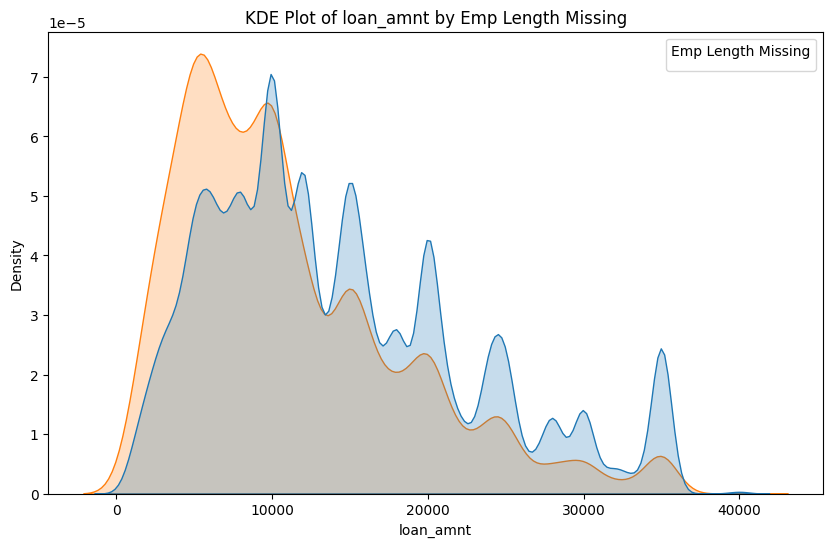

C:\Users\sreem\AppData\Local\Temp\ipykernel_34316\3191714987.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Emp Length Missing')


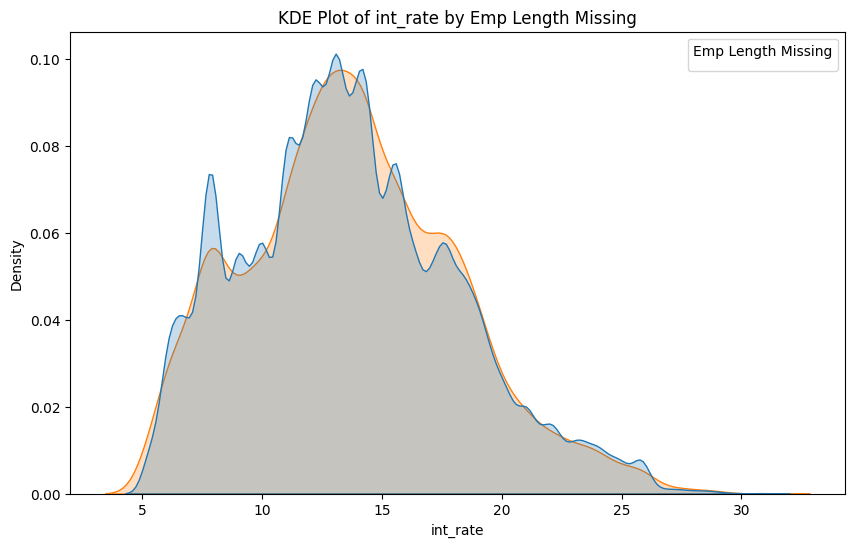

C:\Users\sreem\AppData\Local\Temp\ipykernel_34316\3191714987.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Emp Length Missing')


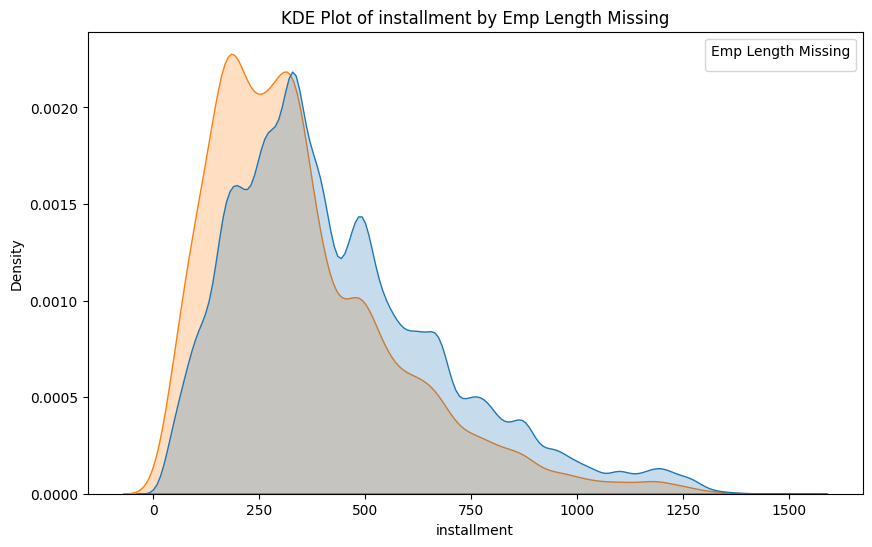

C:\Users\sreem\AppData\Local\Temp\ipykernel_34316\3191714987.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Emp Length Missing')


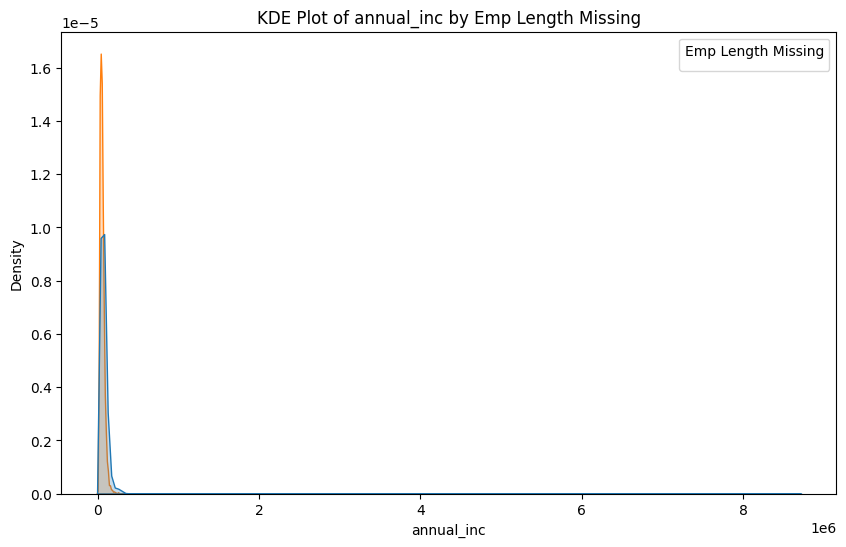

C:\Users\sreem\AppData\Local\Temp\ipykernel_34316\3191714987.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Emp Length Missing')


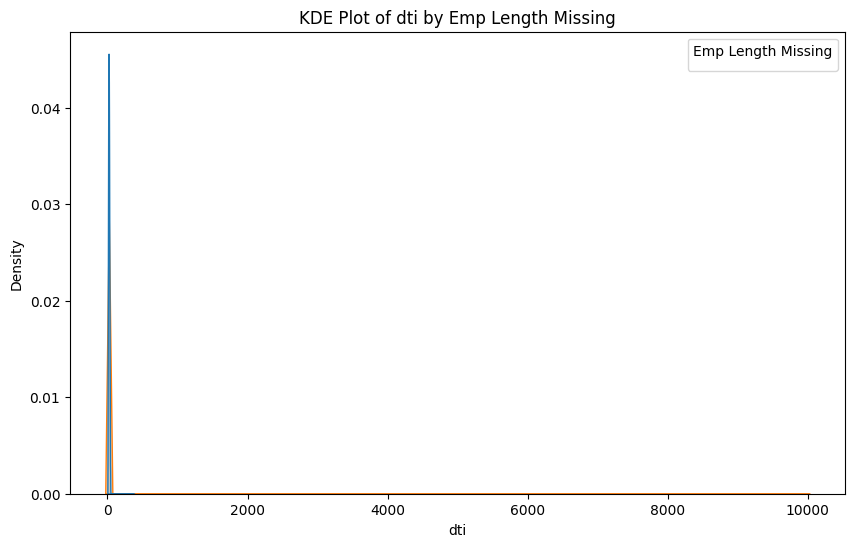

C:\Users\sreem\AppData\Local\Temp\ipykernel_34316\3191714987.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Emp Length Missing')


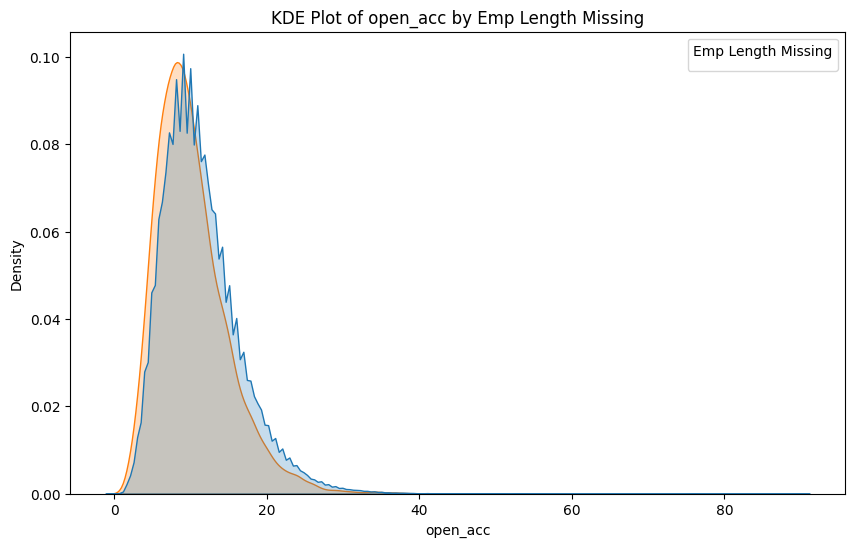

C:\Users\sreem\AppData\Local\Temp\ipykernel_34316\3191714987.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Emp Length Missing')


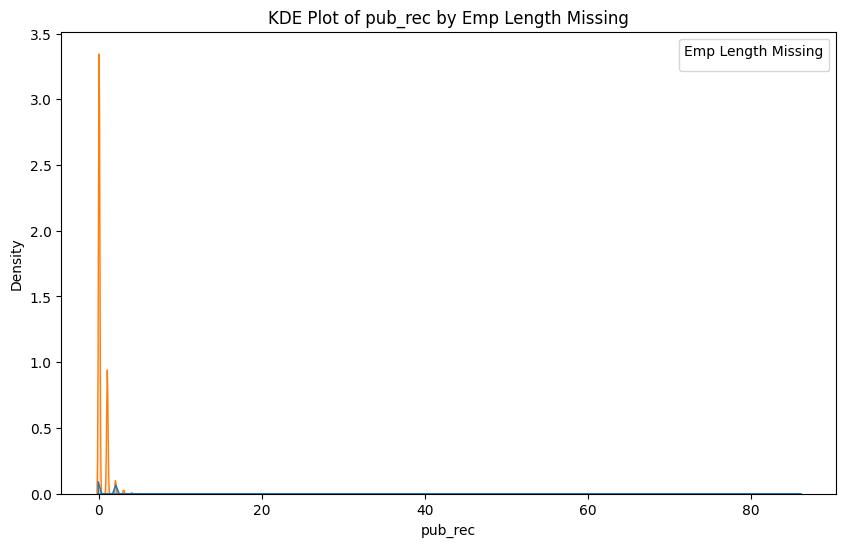

C:\Users\sreem\AppData\Local\Temp\ipykernel_34316\3191714987.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Emp Length Missing')


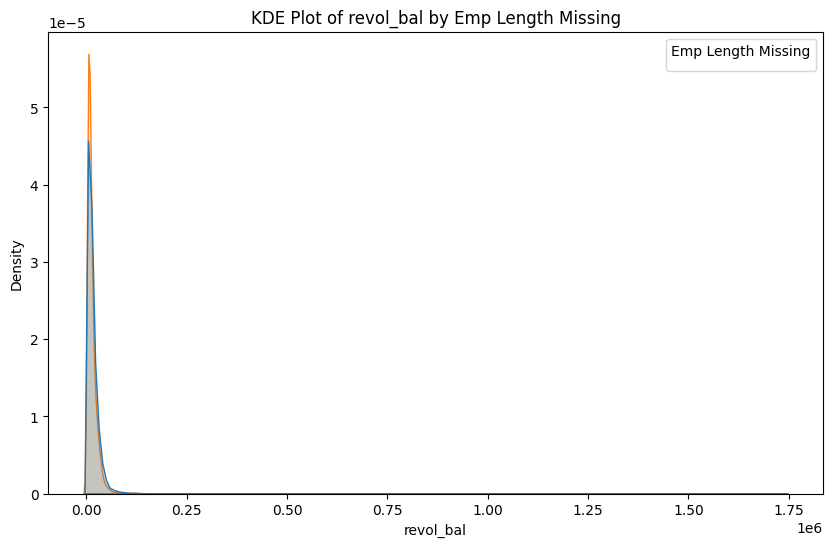

C:\Users\sreem\AppData\Local\Temp\ipykernel_34316\3191714987.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Emp Length Missing')


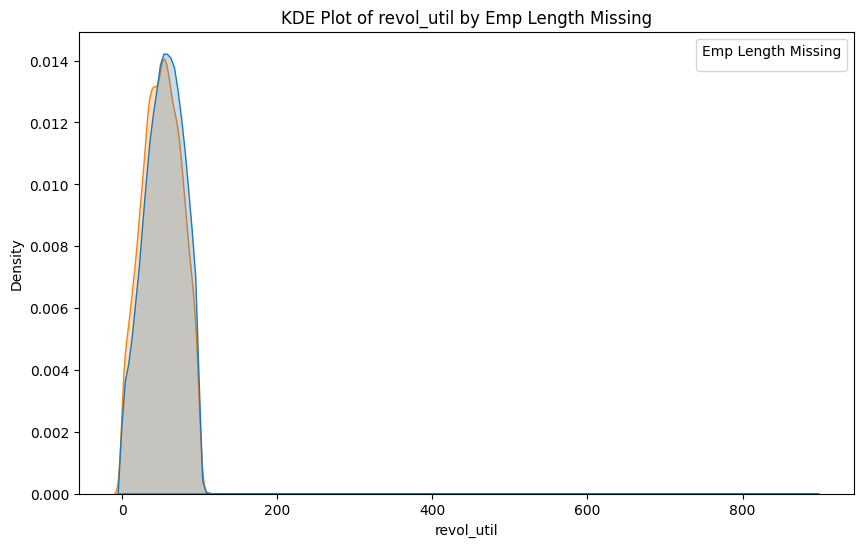

C:\Users\sreem\AppData\Local\Temp\ipykernel_34316\3191714987.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Emp Length Missing')


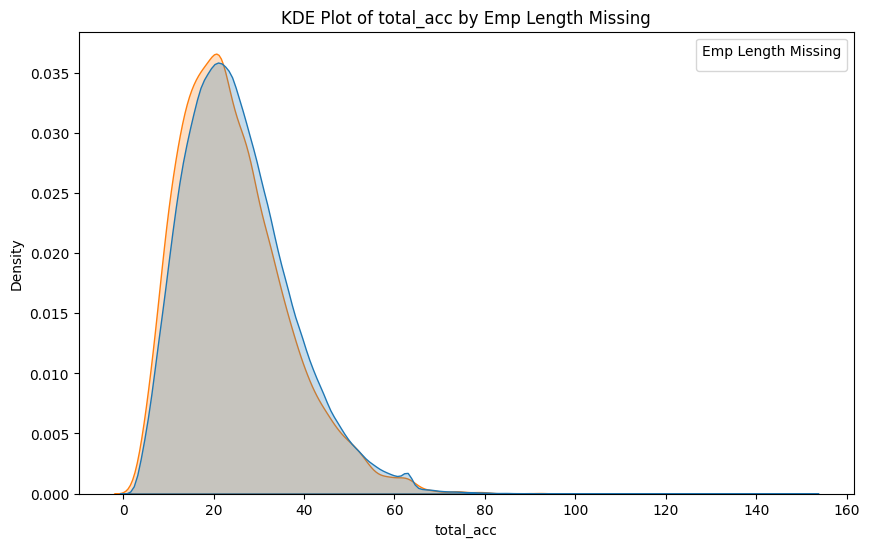

C:\Users\sreem\AppData\Local\Temp\ipykernel_34316\3191714987.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Emp Length Missing')


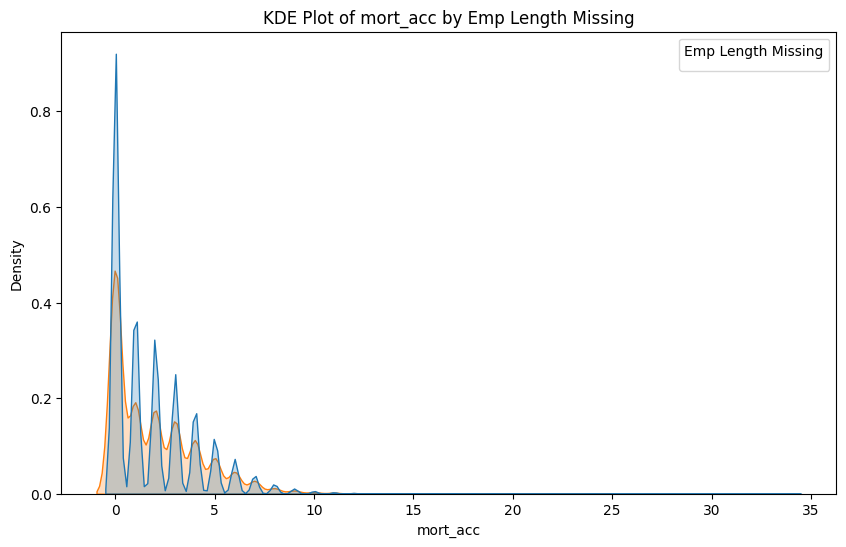

C:\Users\sreem\AppData\Local\Temp\ipykernel_34316\3191714987.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Emp Length Missing')


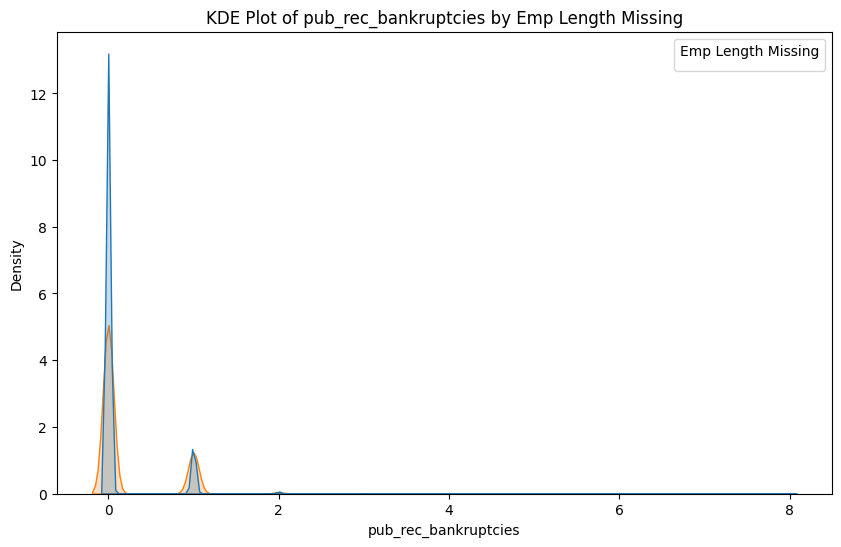

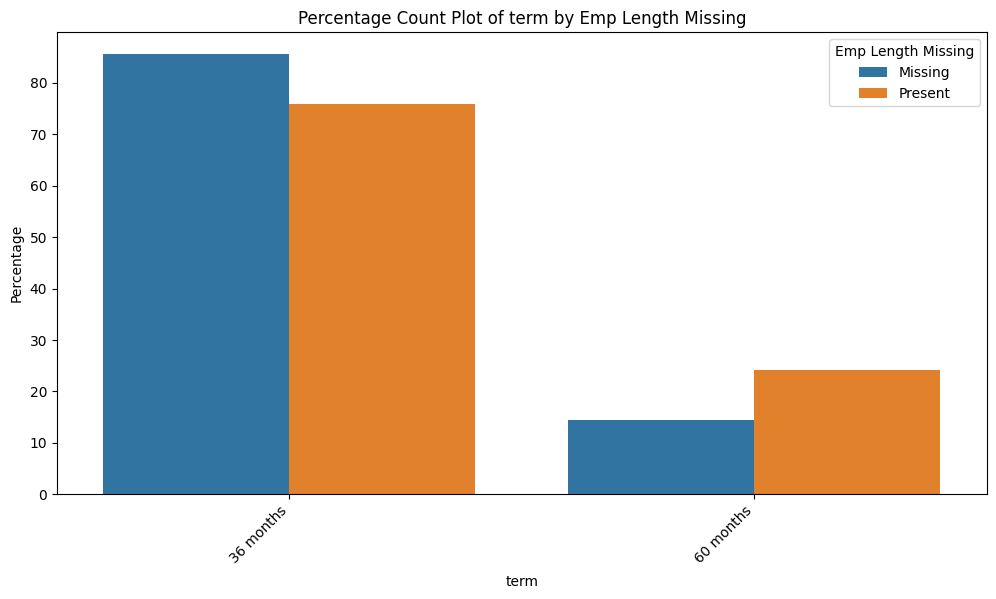

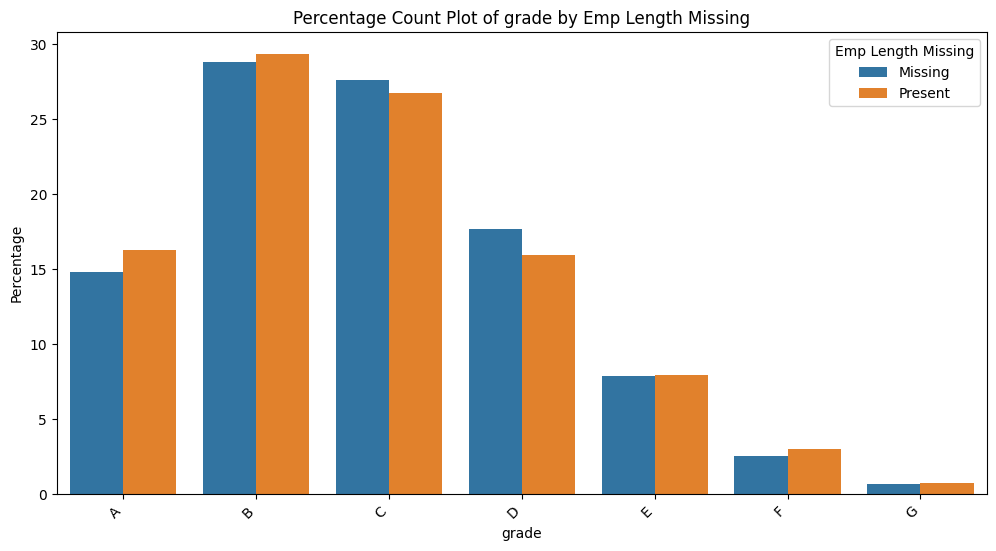

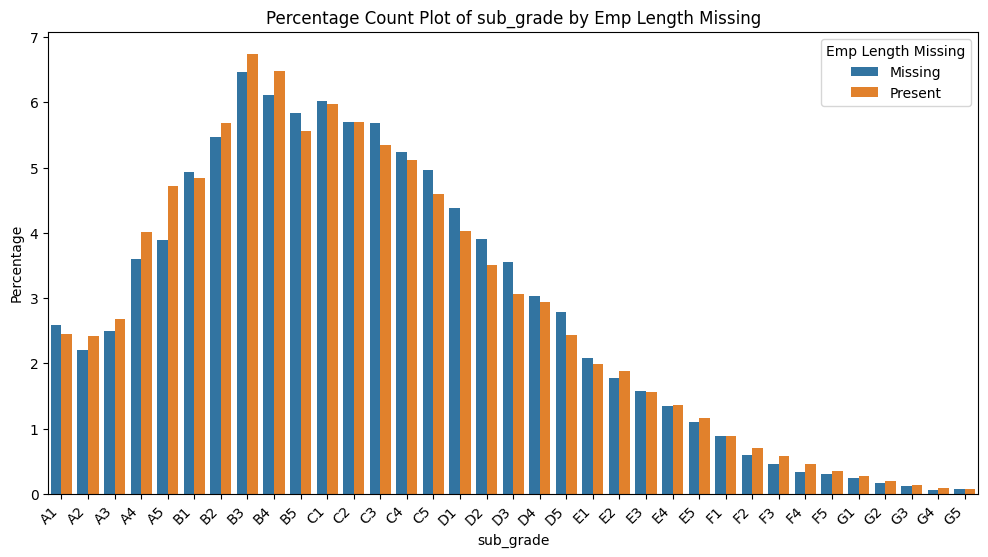

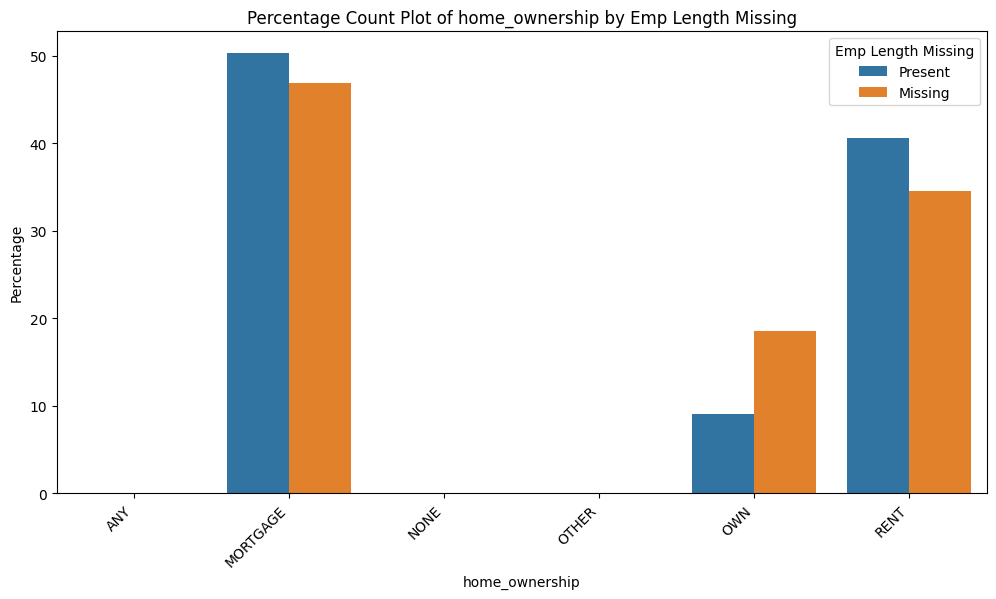

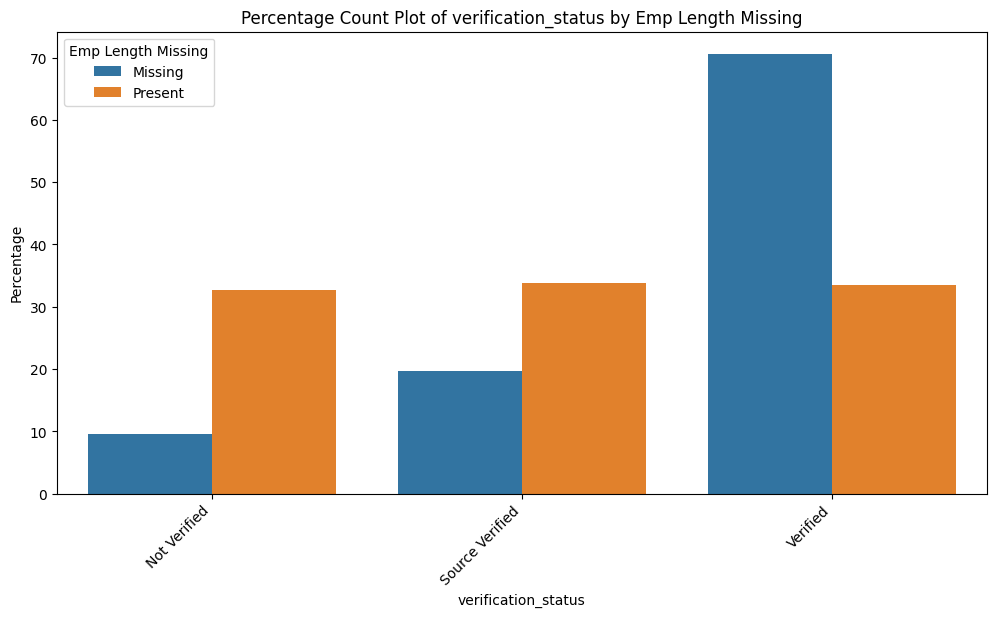

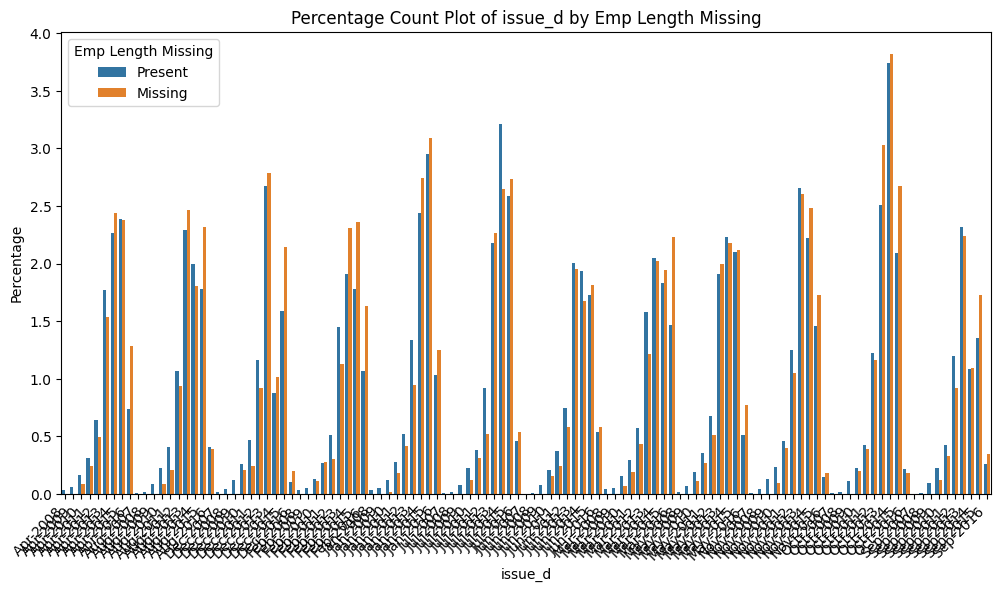

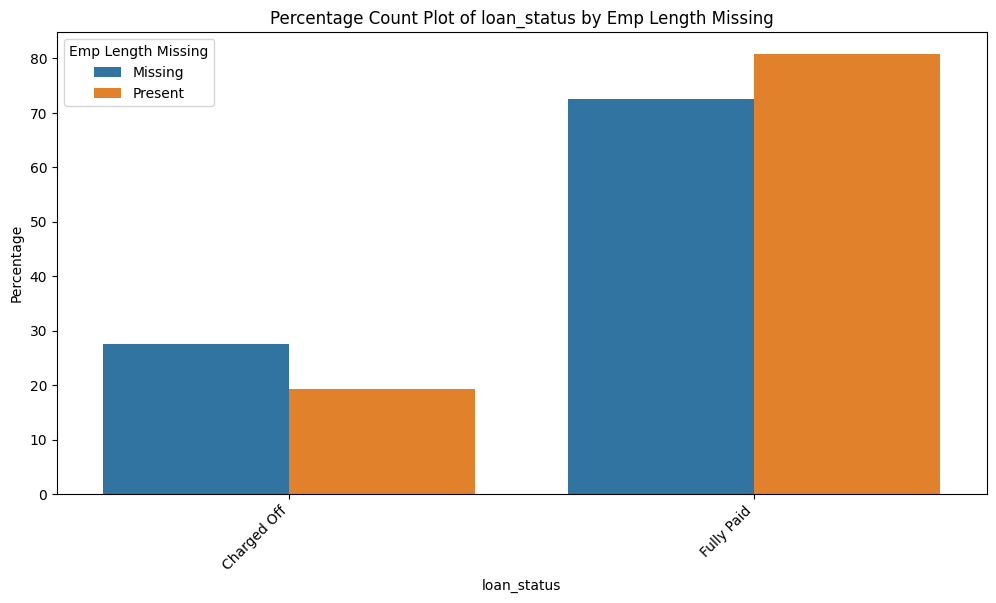

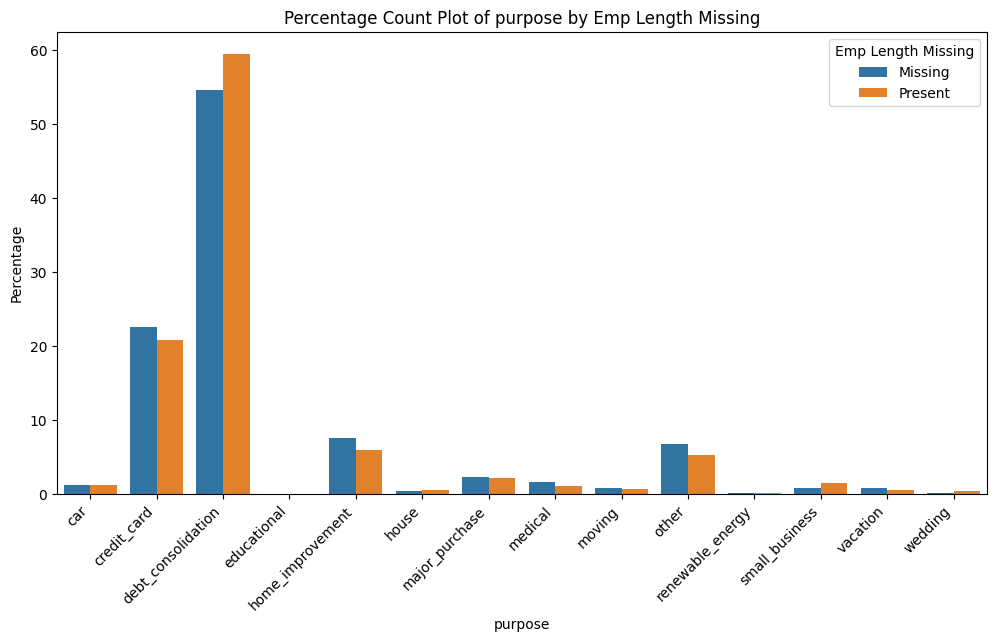

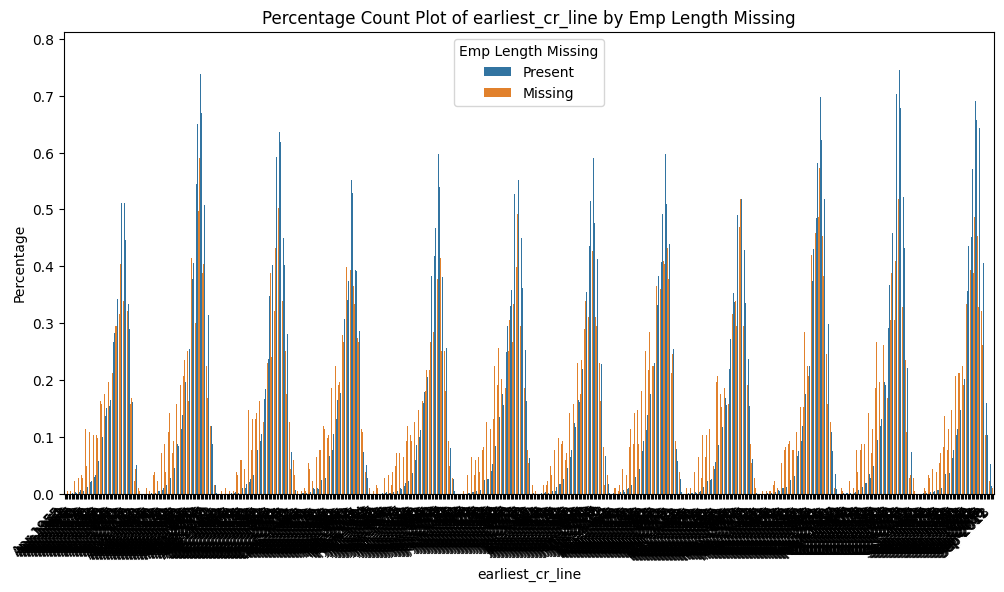

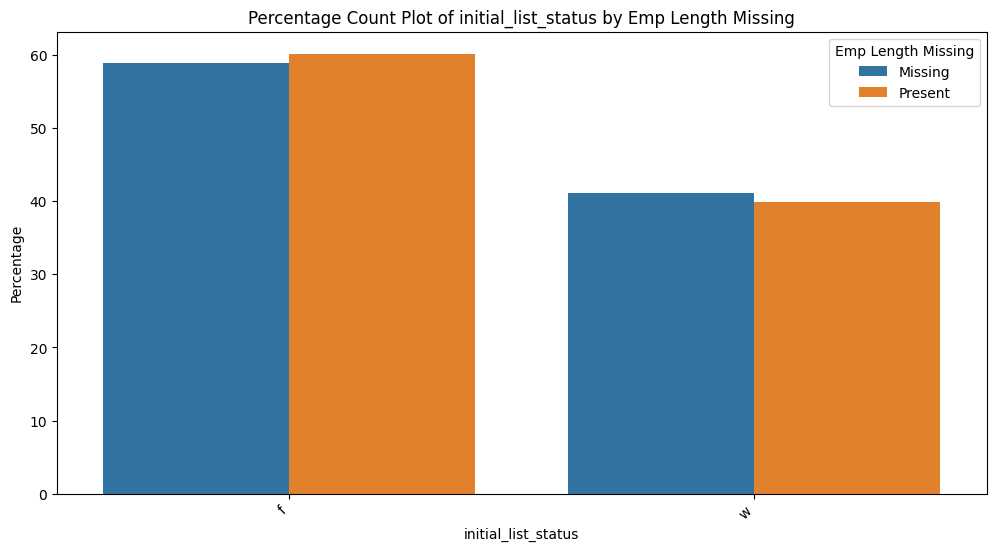

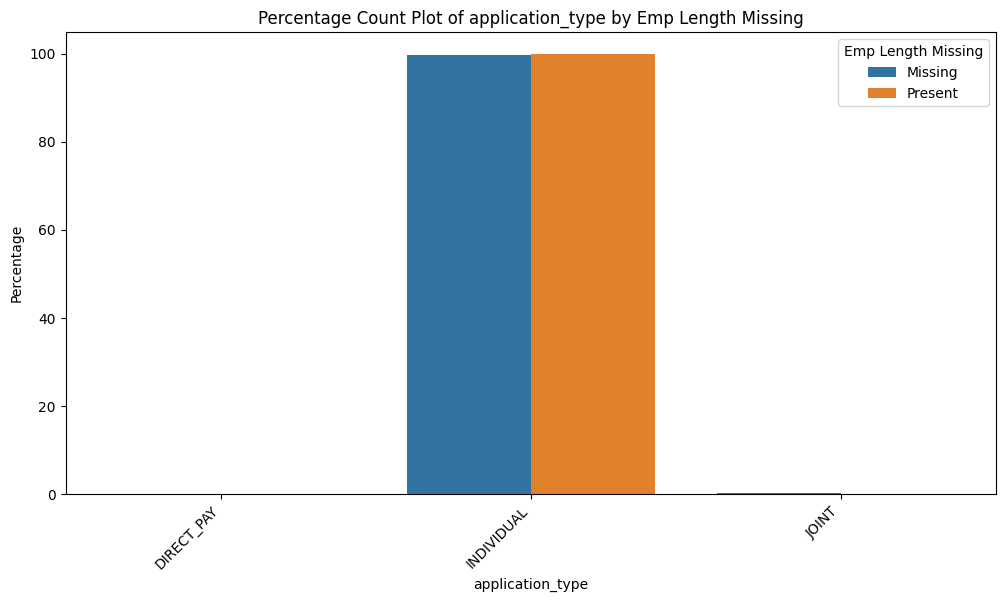

In [15]:
# Step 1: Create a new column indicating if emp_length is missing
loan_data['emp_length_missing'] = loan_data['emp_length'].isna().map({True: 'Missing', False: 'Present'})

# Step 2: Separate numerical and categorical columns
numerical_cols = loan_data.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_cols = loan_data.select_dtypes(include=['object']).columns.tolist()

# We don't want to include the newly added or unnecessary columns
categorical_cols = [col for col in categorical_cols if col not in ['address', 'emp_title', 'title', 'emp_length', 'emp_length_missing']]

# Step 3: KDE plots for numerical columns
for col in numerical_cols:
    plt.figure(figsize=(10,6))
    ax = sns.kdeplot(
        data=loan_data, 
        x=col, 
        hue='emp_length_missing', 
        fill=True,
        common_norm=False,  # Normalize separately for Missing and Present
        bw_adjust=1         # Controls smoothness (optional)
    )

    # No need to multiply y_labels by 100 manually now
    # Set y-axis label to Percentage (conceptual — because KDE shows probability)
    plt.title(f'KDE Plot of {col} by Emp Length Missing')
    plt.xlabel(col)
    plt.ylabel('Density')  # Density area is 1 for each group separately
    plt.legend(title='Emp Length Missing')
    plt.show()

# Step 4: Correct Count plots with Percentage
for col in categorical_cols:
    plt.figure(figsize=(12,6))

    # Calculate percentage manually for correct scaling
    temp_df = loan_data.groupby([col, 'emp_length_missing']).size().reset_index(name='count')
    total_counts = temp_df.groupby('emp_length_missing')['count'].transform('sum')
    temp_df['percentage'] = (temp_df['count'] / total_counts) * 100

    ax = sns.barplot(
        data=temp_df, 
        x=col, 
        y='percentage', 
        hue='emp_length_missing'
    )
    
    plt.title(f'Percentage Count Plot of {col} by Emp Length Missing')
    plt.xlabel(col)
    plt.ylabel('Percentage')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Emp Length Missing')
    plt.show()


Observations:
- There is no significant relation between `emp_lenght` and other features, since above plots are the same before and after.


### Data Imputation

In [16]:
loan_data['emp_length'] = loan_data['emp_length'].fillna('< 1 year')

In [17]:
loan_data.loc[loan_data['revol_util'].isna(),'revol_util'] = 0.0
loan_data.loc[loan_data['mort_acc'].isna(),'mort_acc'] = 0.0
loan_data.loc[loan_data['pub_rec_bankruptcies'].isna(),'pub_rec_bankruptcies'] = 0.0

Checking Null values again after Imputation.

In [18]:
sum(loan_data.isna().sum())

0

In [19]:
loan_data.head()

loan_amnt        term  int_rate  installment grade sub_grade  \
0    10000.0   36 months     11.44       329.48     B        B4   
1     8000.0   36 months     11.99       265.68     B        B5   
2    15600.0   36 months     10.49       506.97     B        B3   
3     7200.0   36 months      6.49       220.65     A        A2   
4    24375.0   60 months     17.27       609.33     C        C5   

                 emp_title emp_length home_ownership  annual_inc  \
0                Marketing  10+ years           RENT    117000.0   
1          Credit analyst     4 years       MORTGAGE     65000.0   
2             Statistician   < 1 year           RENT     43057.0   
3          Client Advocate    6 years           RENT     54000.0   
4  Destiny Management Inc.    9 years       MORTGAGE     55000.0   

  verification_status   issue_d  loan_status             purpose  \
0        Not Verified  Jan-2015   Fully Paid            vacation   
1        Not Verified  Jan-2015   Fully Paid  debt_consolidation   
2     Source Verified  Jan-2015   Fully Paid         credit_card   
3        Not Verified  Nov-2014   Fully Paid         credit_card   
4            Verified  Apr-2013  Charged Off         credit_card   

                     title    dti earliest_cr_line  open_acc  pub_rec  \
0                 Vacation  26.24         Jun-1990      16.0      0.0   
1       Debt consolidation  22.05         Jul-2004      17.0      0.0   
2  Credit card refinancing  12.79         Aug-2007      13.0      0.0   
3  Credit card refinancing   2.60         Sep-2006       6.0      0.0   
4    Credit Card Refinance  33.95         Mar-1999      13.0      0.0   

   revol_bal  revol_util  total_acc initial_list_status application_type  \
0    36369.0        41.8       25.0                   w       INDIVIDUAL   
1    20131.0        53.3       27.0                   f       INDIVIDUAL   
2    11987.0        92.2       26.0                   f       INDIVIDUAL   
3     5472.0        21.5       13.0                   f       INDIVIDUAL   
4    24584.0        69.8       43.0                   f       INDIVIDUAL   

   mort_acc  pub_rec_bankruptcies  \
0       0.0                   0.0   
1       3.0                   0.0   
2       0.0                   0.0   
3       0.0                   0.0   
4       1.0                   0.0   

                                             address emp_length_missing  
0     0174 Michelle Gateway\r\nMendozaberg, OK 22690            Present  
1  1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113            Present  
2  87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113            Present  
3            823 Reid Ford\r\nDelacruzside, MA 00813            Present  
4             679 Luna Roads\r\nGreggshire, VA 11650            Present

# Feature Engineering

In [20]:
loan_data['pub_rec'] = [1 if i > 1 else 0 for i in loan_data['pub_rec']]
loan_data['mort_acc'] = [1 if i > 1 else 0 for i in loan_data['mort_acc']]
loan_data['pub_rec_bankruptcies'] = [1 if i > 1 else 0 for i in loan_data['pub_rec_bankruptcies']]

In [21]:
#Split issue_date into month and year
loan_data[['issue_month', 'issue_year']] = loan_data['issue_d'].str.split('-', expand=True)


In [22]:
#Split er_cr_line date into month and year
loan_data[['er_cr_line_m', 'er_cr_line_y']] = loan_data['earliest_cr_line'].str.split('-', expand=True)


In [23]:
# Conversion of issue_d and earliest_cr_line columns to datetime datatype
loan_data["issue_d"] = loan_data["issue_d"].astype('datetime64[ns]')
loan_data["earliest_cr_line"] = loan_data["earliest_cr_line"].astype('datetime64[ns]')
loan_data["days_from_first_loan"] =  (loan_data["issue_d"]-loan_data["earliest_cr_line"]).dt.days

In [24]:
loan_data.drop(['earliest_cr_line'], axis=1, inplace=True)
loan_data.drop(['issue_d'], axis=1, inplace=True)

In [25]:
#Split address into State and Zip code
loan_data[['state','zipcode']] = loan_data['address'].str.extract(r'([A-Z]{2}) (\d{5})')
loan_data.drop(['address'], axis=1, inplace=True)

In [26]:
state_dict = {"AA":"Armed Forces America", "AE":"Armed Forces","AK":"Alaska","AL":"Alabama",
              "AP":"Armed Forces Pacific","AR":"Arkansas","AZ":"Arizona","CA":"California",
              "CO":"Colorodo","CT":"Connecticut","DC":"Washington DC","DE":"Delaware",
              "FL":"Florida","GA":"Georgia","HI":"Hawaii","IA":"Iowa","ID":"Idaho","IL":"Illinois",
              "IN":"Indiana","KS":"Kansas","KY":"Kentucky","LA":"Louisiana","MA":"Massachusetts",
              "MD":"Maryland","ME":"Maine","MI":"Michigan","MN":"Minnesota","MO":"Missouri",
              "MS":"Mississippi","MT":"Montana","NC":"North Carolina","ND":"North Dakota",
              "NE":"Nebraska","NH":"New Hampshire","NJ":"New Jersey","NM":"New Mexico","NV":"Nevada",
              "NY":"New York","OH":"Ohio","OK":"Oklahoma","OR":"Oregon","PA":"Pennsylvania",
              "RI":"Rhode Island","SC":"South Carolina","SD":"South Dakota","TN":"Tennessee",
              "TX":"Texas","UT":"Utah","VA":"Virginia","VT":"Vermont","WA":"Washington",
              "WI":"Wisconsin","WV":"West Virginia","WY":"Wyoming"}

In [27]:
loan_data["state"] = loan_data.state.map(state_dict)

In [28]:
loan_data['term'] = loan_data['term'].str.split().str[0].astype(int)

In [29]:
loan_data['emp_length_yrs'] =loan_data['emp_length'].str.extract('(\d+)').astype(int)

In [30]:
loan_data.drop(['emp_length'], axis=1, inplace=True)

In [31]:
loan_data['emp_length_yrs'].value_counts()

emp_length_yrs
10    126041
1      75908
2      35827
3      31665
5      26495
4      23952
6      20841
7      20819
8      19168
9      15314
Name: count, dtype: int64

In [32]:
loan_data.head()

loan_amnt  term  int_rate  installment grade sub_grade  \
0    10000.0    36     11.44       329.48     B        B4   
1     8000.0    36     11.99       265.68     B        B5   
2    15600.0    36     10.49       506.97     B        B3   
3     7200.0    36      6.49       220.65     A        A2   
4    24375.0    60     17.27       609.33     C        C5   

                 emp_title home_ownership  annual_inc verification_status  \
0                Marketing           RENT    117000.0        Not Verified   
1          Credit analyst        MORTGAGE     65000.0        Not Verified   
2             Statistician           RENT     43057.0     Source Verified   
3          Client Advocate           RENT     54000.0        Not Verified   
4  Destiny Management Inc.       MORTGAGE     55000.0            Verified   

   loan_status             purpose                    title    dti  open_acc  \
0   Fully Paid            vacation                 Vacation  26.24      16.0   
1   Fully Paid  debt_consolidation       Debt consolidation  22.05      17.0   
2   Fully Paid         credit_card  Credit card refinancing  12.79      13.0   
3   Fully Paid         credit_card  Credit card refinancing   2.60       6.0   
4  Charged Off         credit_card    Credit Card Refinance  33.95      13.0   

   pub_rec  revol_bal  revol_util  total_acc initial_list_status  \
0        0    36369.0        41.8       25.0                   w   
1        0    20131.0        53.3       27.0                   f   
2        0    11987.0        92.2       26.0                   f   
3        0     5472.0        21.5       13.0                   f   
4        0    24584.0        69.8       43.0                   f   

  application_type  mort_acc  pub_rec_bankruptcies emp_length_missing  \
0       INDIVIDUAL         0                     0            Present   
1       INDIVIDUAL         1                     0            Present   
2       INDIVIDUAL         0                     0            Present   
3       INDIVIDUAL         0                     0            Present   
4       INDIVIDUAL         0                     0            Present   

  issue_month issue_year er_cr_line_m er_cr_line_y  days_from_first_loan  \
0         Jan       2015          Jun         1990                  8980   
1         Jan       2015          Jul         2004                  3836   
2         Jan       2015          Aug         2007                  2710   
3         Nov       2014          Sep         2006                  2983   
4         Apr       2013          Mar         1999                  5145   

           state zipcode  emp_length_yrs  
0       Oklahoma   22690              10  
1   South Dakota   05113               4  
2  West Virginia   05113               1  
3  Massachusetts   00813               6  
4       Virginia   11650               9

Observations:
- `pub_rec`, `mort_accounts`, `pub_rec_bankruptcies` are very important features for the prediction of **Defaulters**. Even if the values are greater than or equal to 1, the person is to be treated as a defaulter. Therefore these features are coverted to binary (1 = person with 1 or more bad records in these features)
- Date and month are seperated from the datetime related columns[issue_d,earliest_cr_line]. No of days from `days_from_first_loan`.
- State and Zipcode is extracted from address using regex.
- `term`, `emp_lenght` extracted the numbers from these columns.

# Data Visulaization

In [33]:
loan_data.dtypes

loan_amnt               float64
term                      int64
int_rate                float64
installment             float64
grade                    object
sub_grade                object
emp_title                object
home_ownership           object
annual_inc              float64
verification_status      object
loan_status              object
purpose                  object
title                    object
dti                     float64
open_acc                float64
pub_rec                   int64
revol_bal               float64
revol_util              float64
total_acc               float64
initial_list_status      object
application_type         object
mort_acc                  int64
pub_rec_bankruptcies      int64
emp_length_missing       object
issue_month              object
issue_year               object
er_cr_line_m             object
er_cr_line_y             object
days_from_first_loan      int64
state                    object
zipcode                  object
emp_leng

In [34]:
numerical_cols = loan_data.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_cols = loan_data.select_dtypes(include=['object']).columns.tolist()
print(numerical_cols)
print(categorical_cols)

['loan_amnt', 'term', 'int_rate', 'installment', 'annual_inc', 'dti', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'mort_acc', 'pub_rec_bankruptcies', 'days_from_first_loan', 'emp_length_yrs']
['grade', 'sub_grade', 'emp_title', 'home_ownership', 'verification_status', 'loan_status', 'purpose', 'title', 'initial_list_status', 'application_type', 'emp_length_missing', 'issue_month', 'issue_year', 'er_cr_line_m', 'er_cr_line_y', 'state', 'zipcode']


## Univariate

### Distribution of all numerical cols

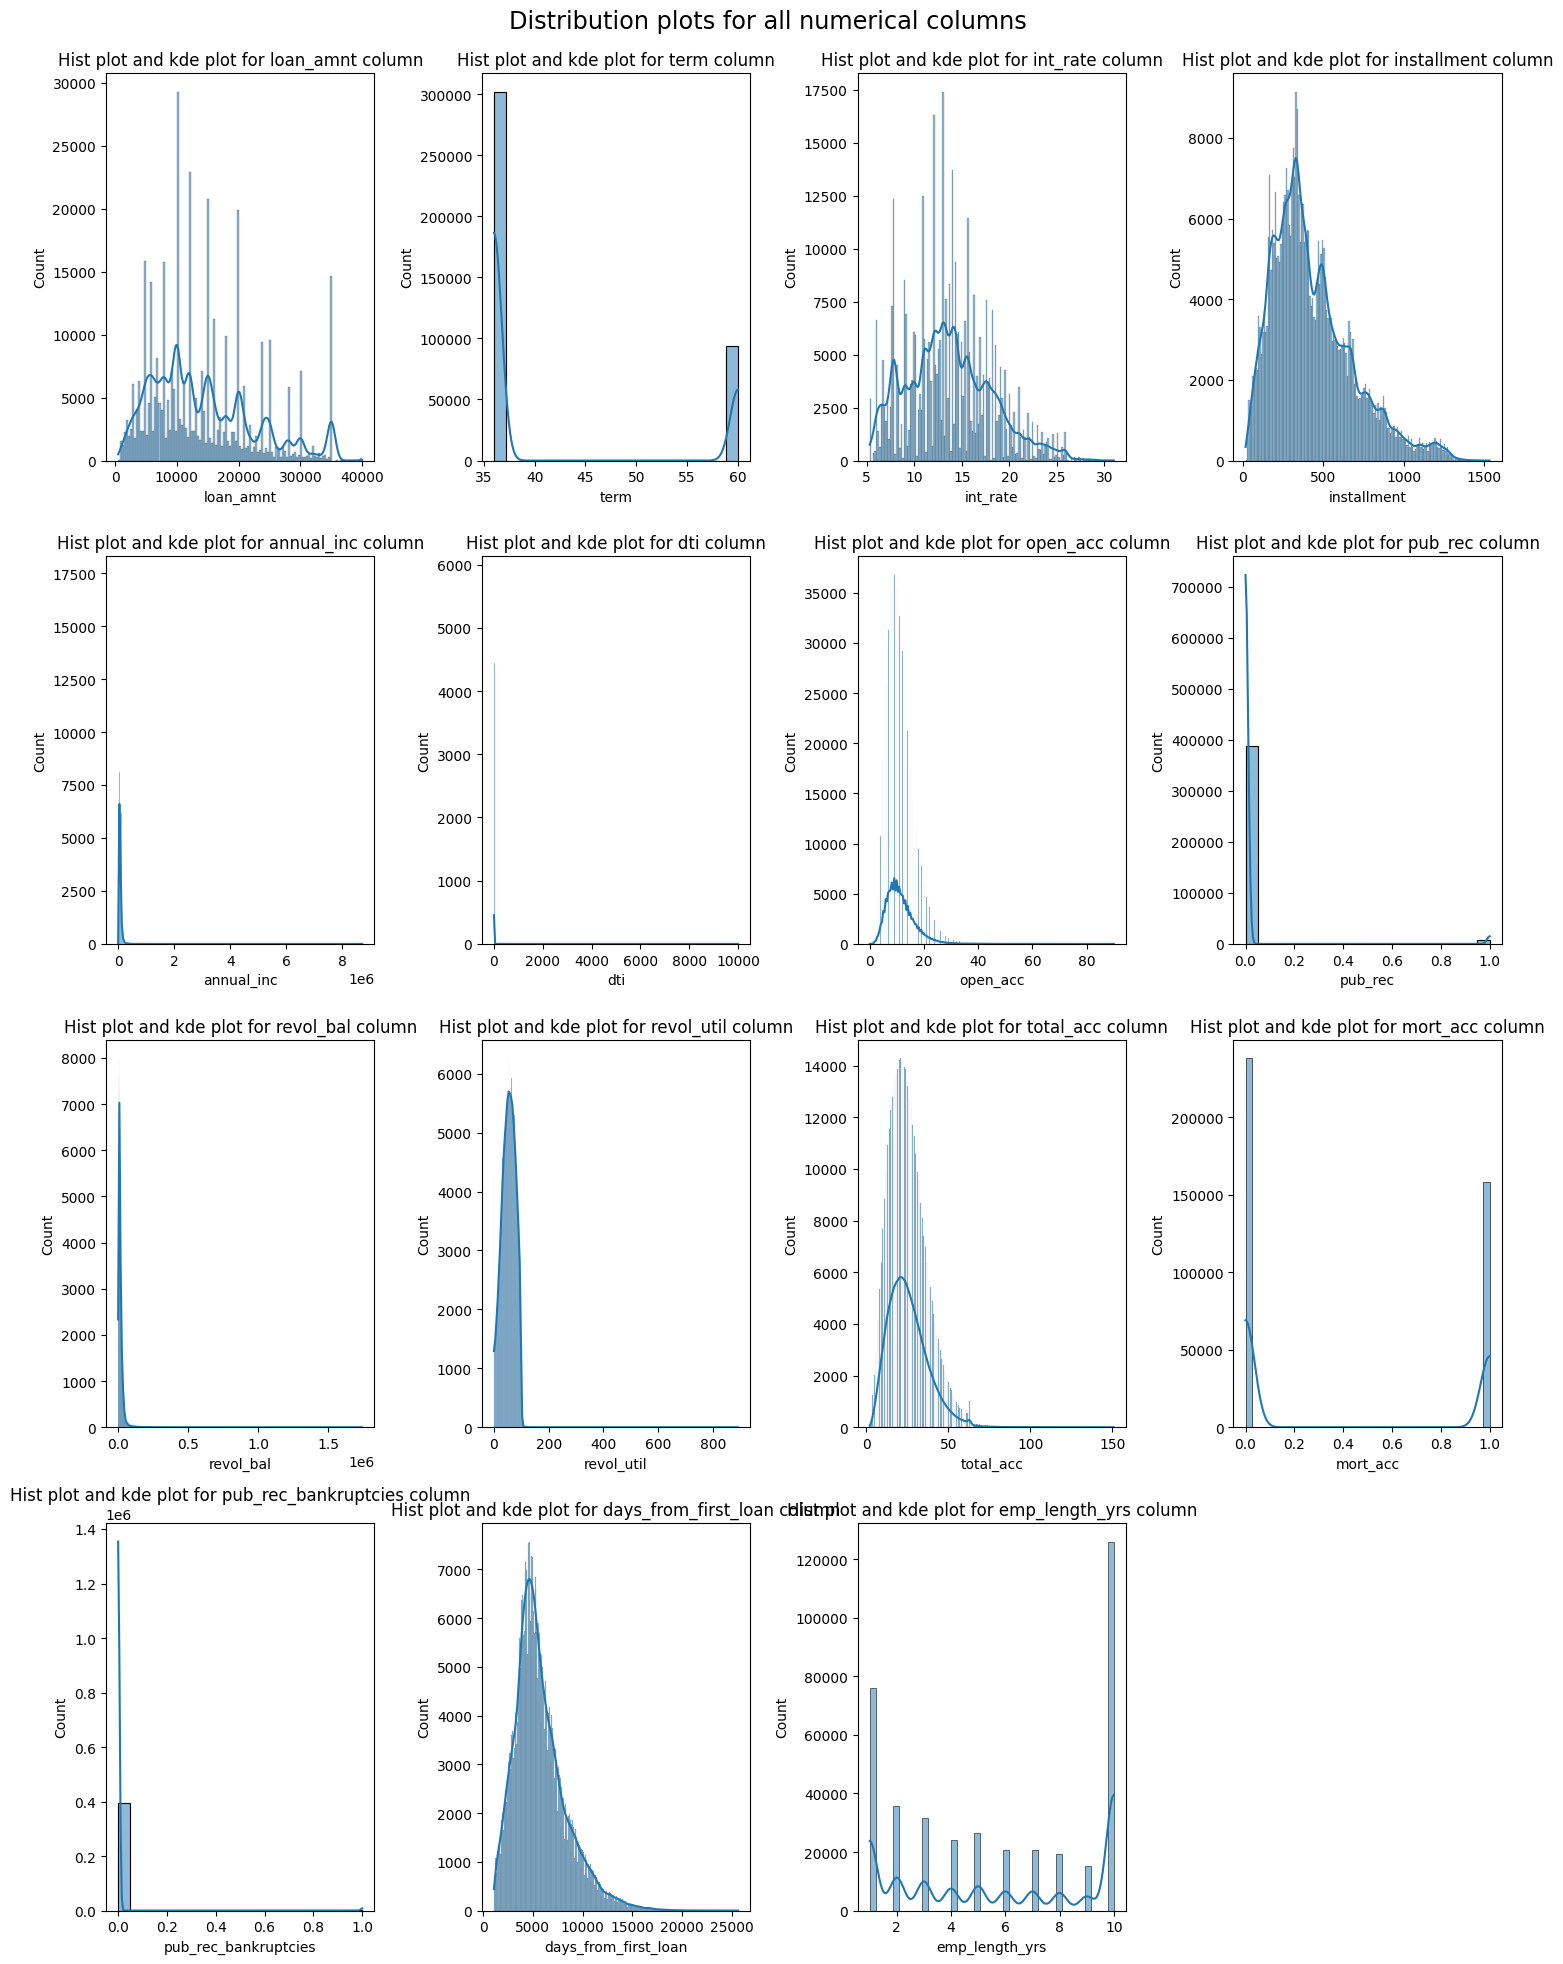

In [35]:
fig = plt.figure(figsize = (15,20))
fig.suptitle("Distribution plots for all numerical columns\n",fontsize = "xx-large" )
k = 1
for i in numerical_cols:
    plt.subplot(4,4,k)
    plt.title("Hist plot and kde plot for {} column".format(i))
    sns.histplot(data=loan_data, x=i, kde=True)
    k = k+1
plt.tight_layout()
plt.show()

### Box plot of all numerical cols

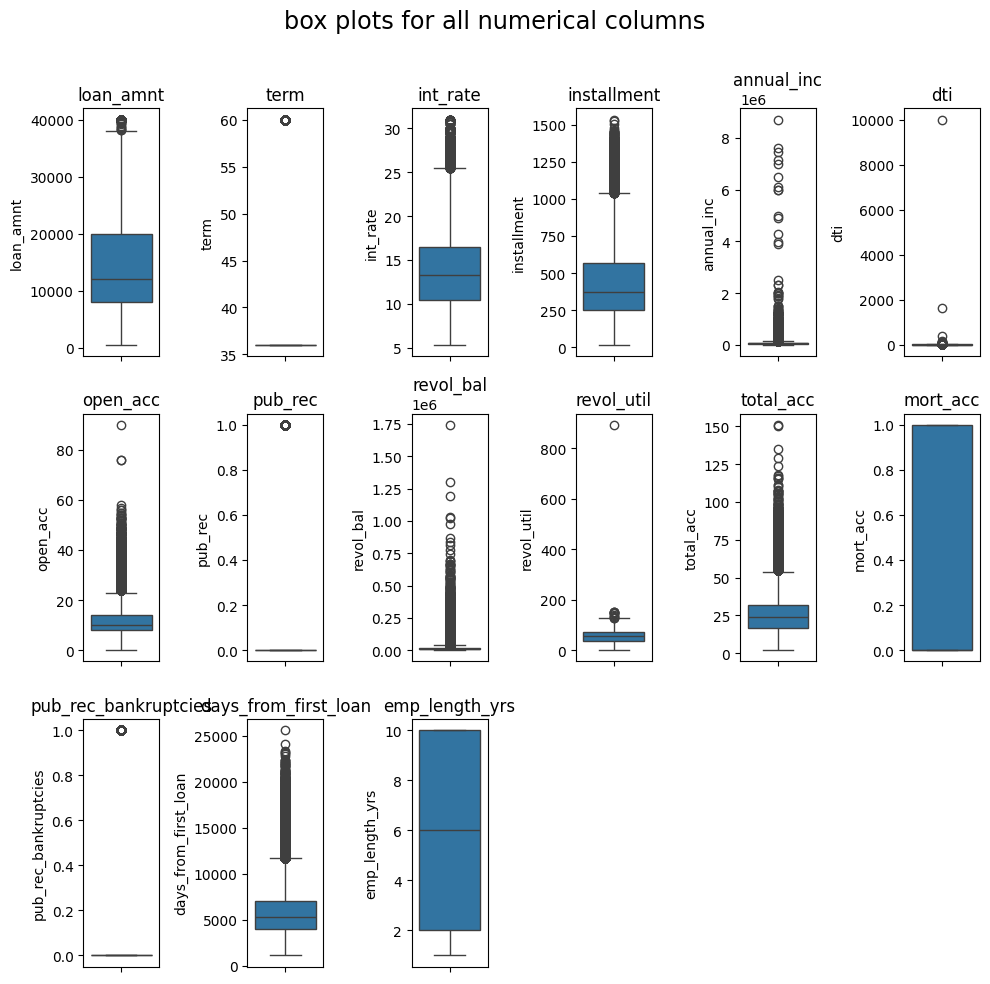

In [36]:
fig = plt.figure(figsize = (10,10))
fig.suptitle("box plots for all numerical columns\n",fontsize = "xx-large" )
k = 1
for i in numerical_cols:
    plt.subplot(3,6,k)
    plt.title("{}".format(i))
    sns.boxplot(data=loan_data[i])
    k = k+1
plt.tight_layout()
plt.show()

### Count Plots of all categorical columns

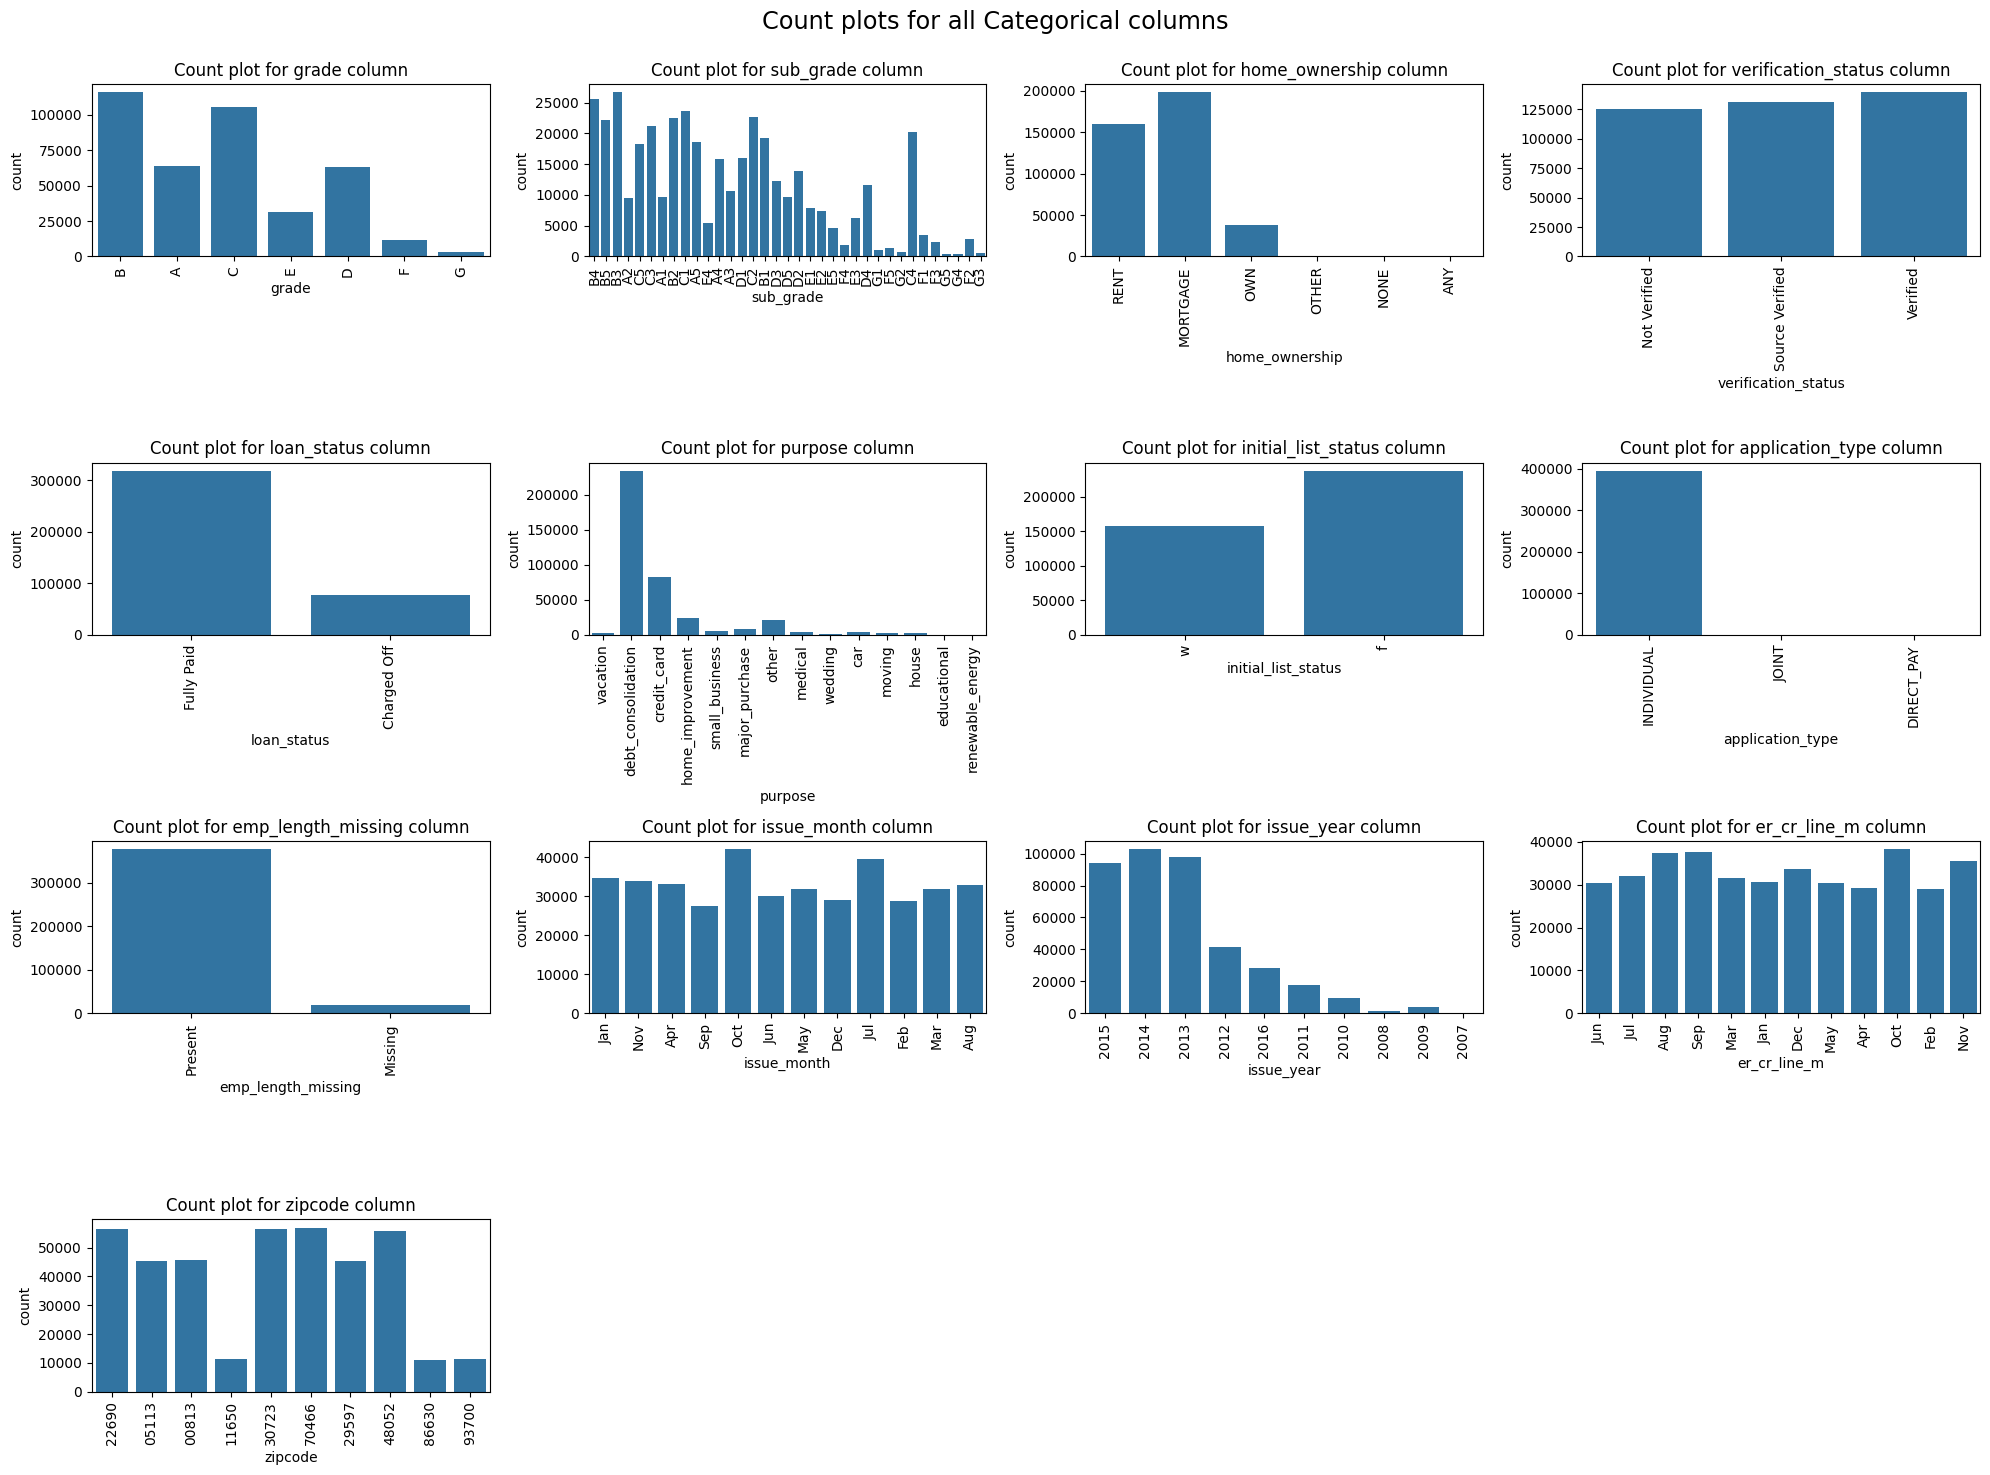

In [37]:
fig = plt.figure(figsize = (20,15))
fig.suptitle("Count plots for all Categorical columns\n",fontsize = "xx-large" )
k = 1
for i in categorical_cols:
    if loan_data[i].nunique()<50:
        plt.subplot(4,4,k)
        plt.title("Count plot for {} column".format(i))
        sns.countplot(data=loan_data, x=i)
        plt.xticks(rotation = 90)
        k = k+1
plt.tight_layout()
plt.show()

Observations:
- Most numerical features such as annual_inc, dti, revol_bal, and days_from_first_loan are highly right-skewed with significant outliers.
- Categorical variables like loan_status and application_type show heavy imbalance, suggesting the importance of sampling.
- Employment length (emp_length_yrs) exhibits a sharp spike at 10 years and also has many entries around 0–1 years, with missing values needing thoughtful imputation since employment stability may influence loan risk.
- The issue year shows most loans concentrated between 2015–2016, and while issue months are fairly uniformly distributed, creating time-based features like loan vintage or seasonality indicators could enhance model performance.

## Bivariate

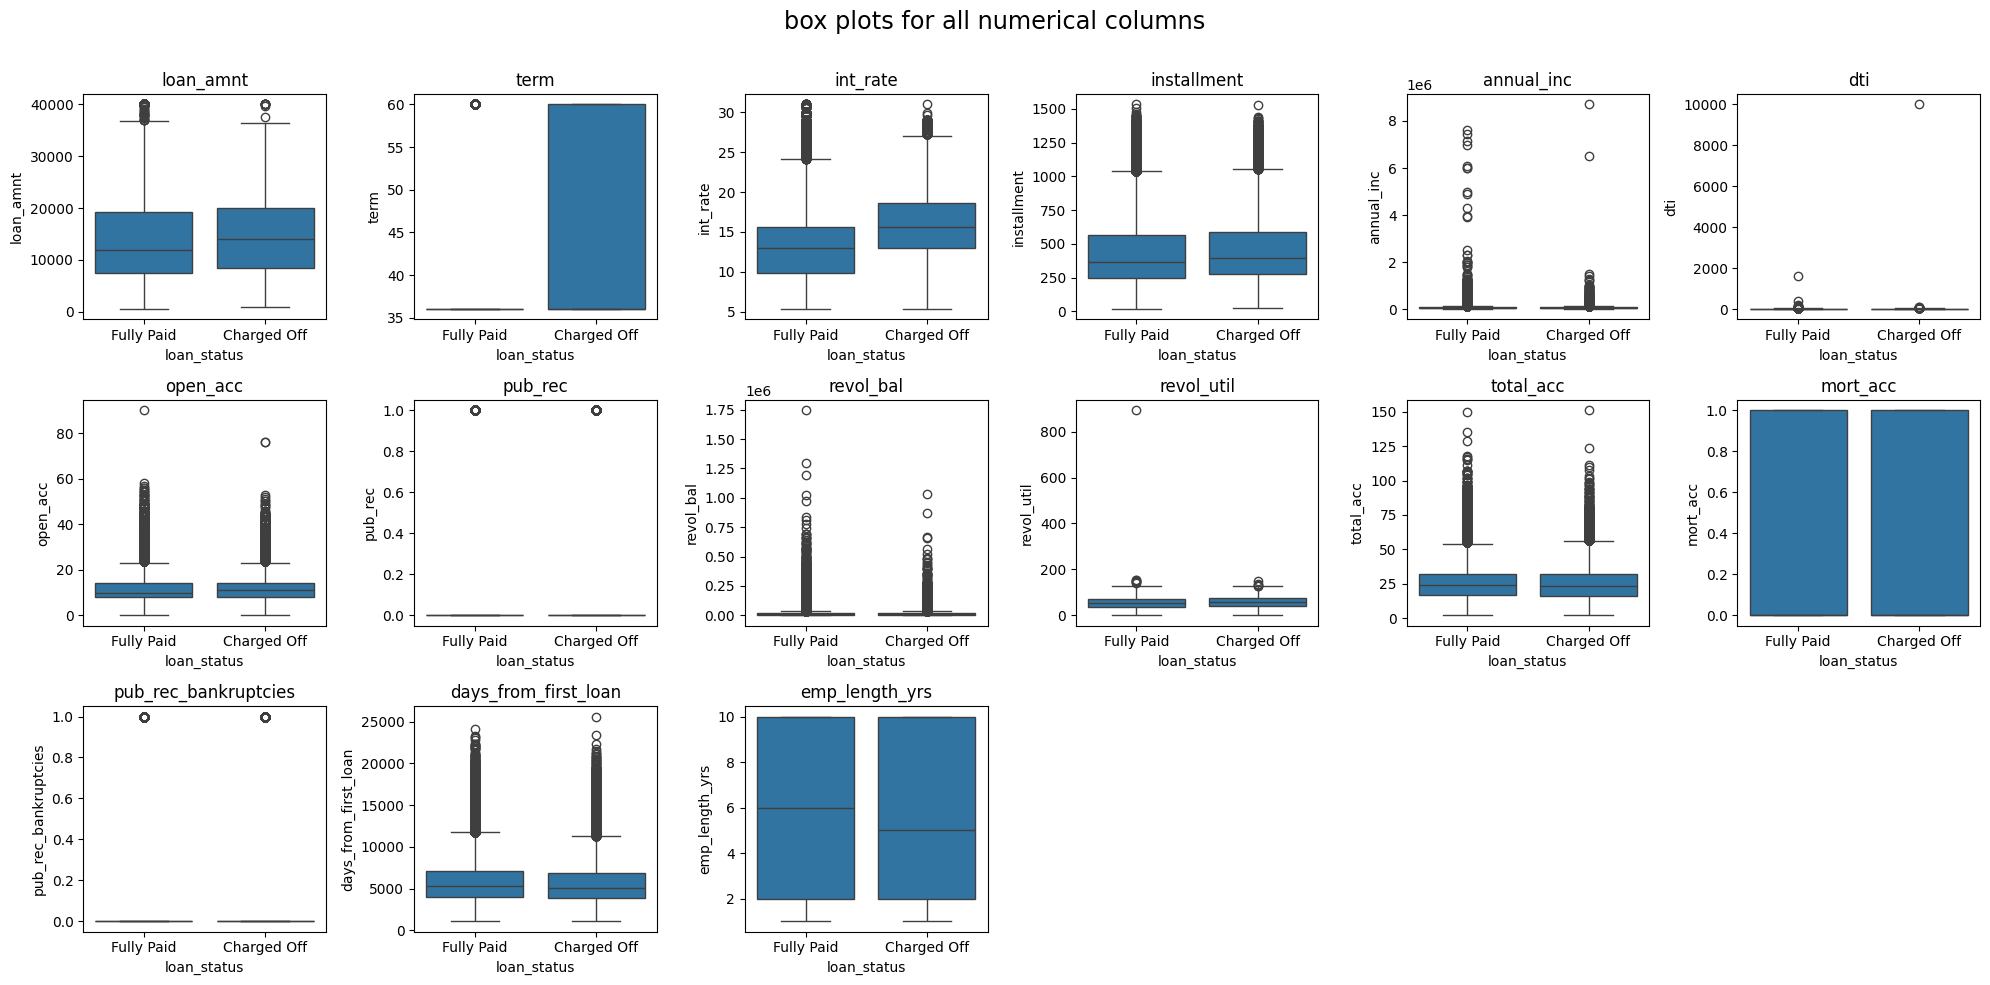

In [38]:
fig = plt.figure(figsize = (20,10))
fig.suptitle("box plots for all numerical columns\n",fontsize = "xx-large" )
k = 1
for i in numerical_cols:
    plt.subplot(3,6,k)
    plt.title("{}".format(i))
    sns.boxplot(data=loan_data,x = 'loan_status',y = i)
    k = k+1
plt.tight_layout()
plt.show()

C:\Users\sreem\AppData\Local\Temp\ipykernel_34316\2846516677.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title = 'loan_status')


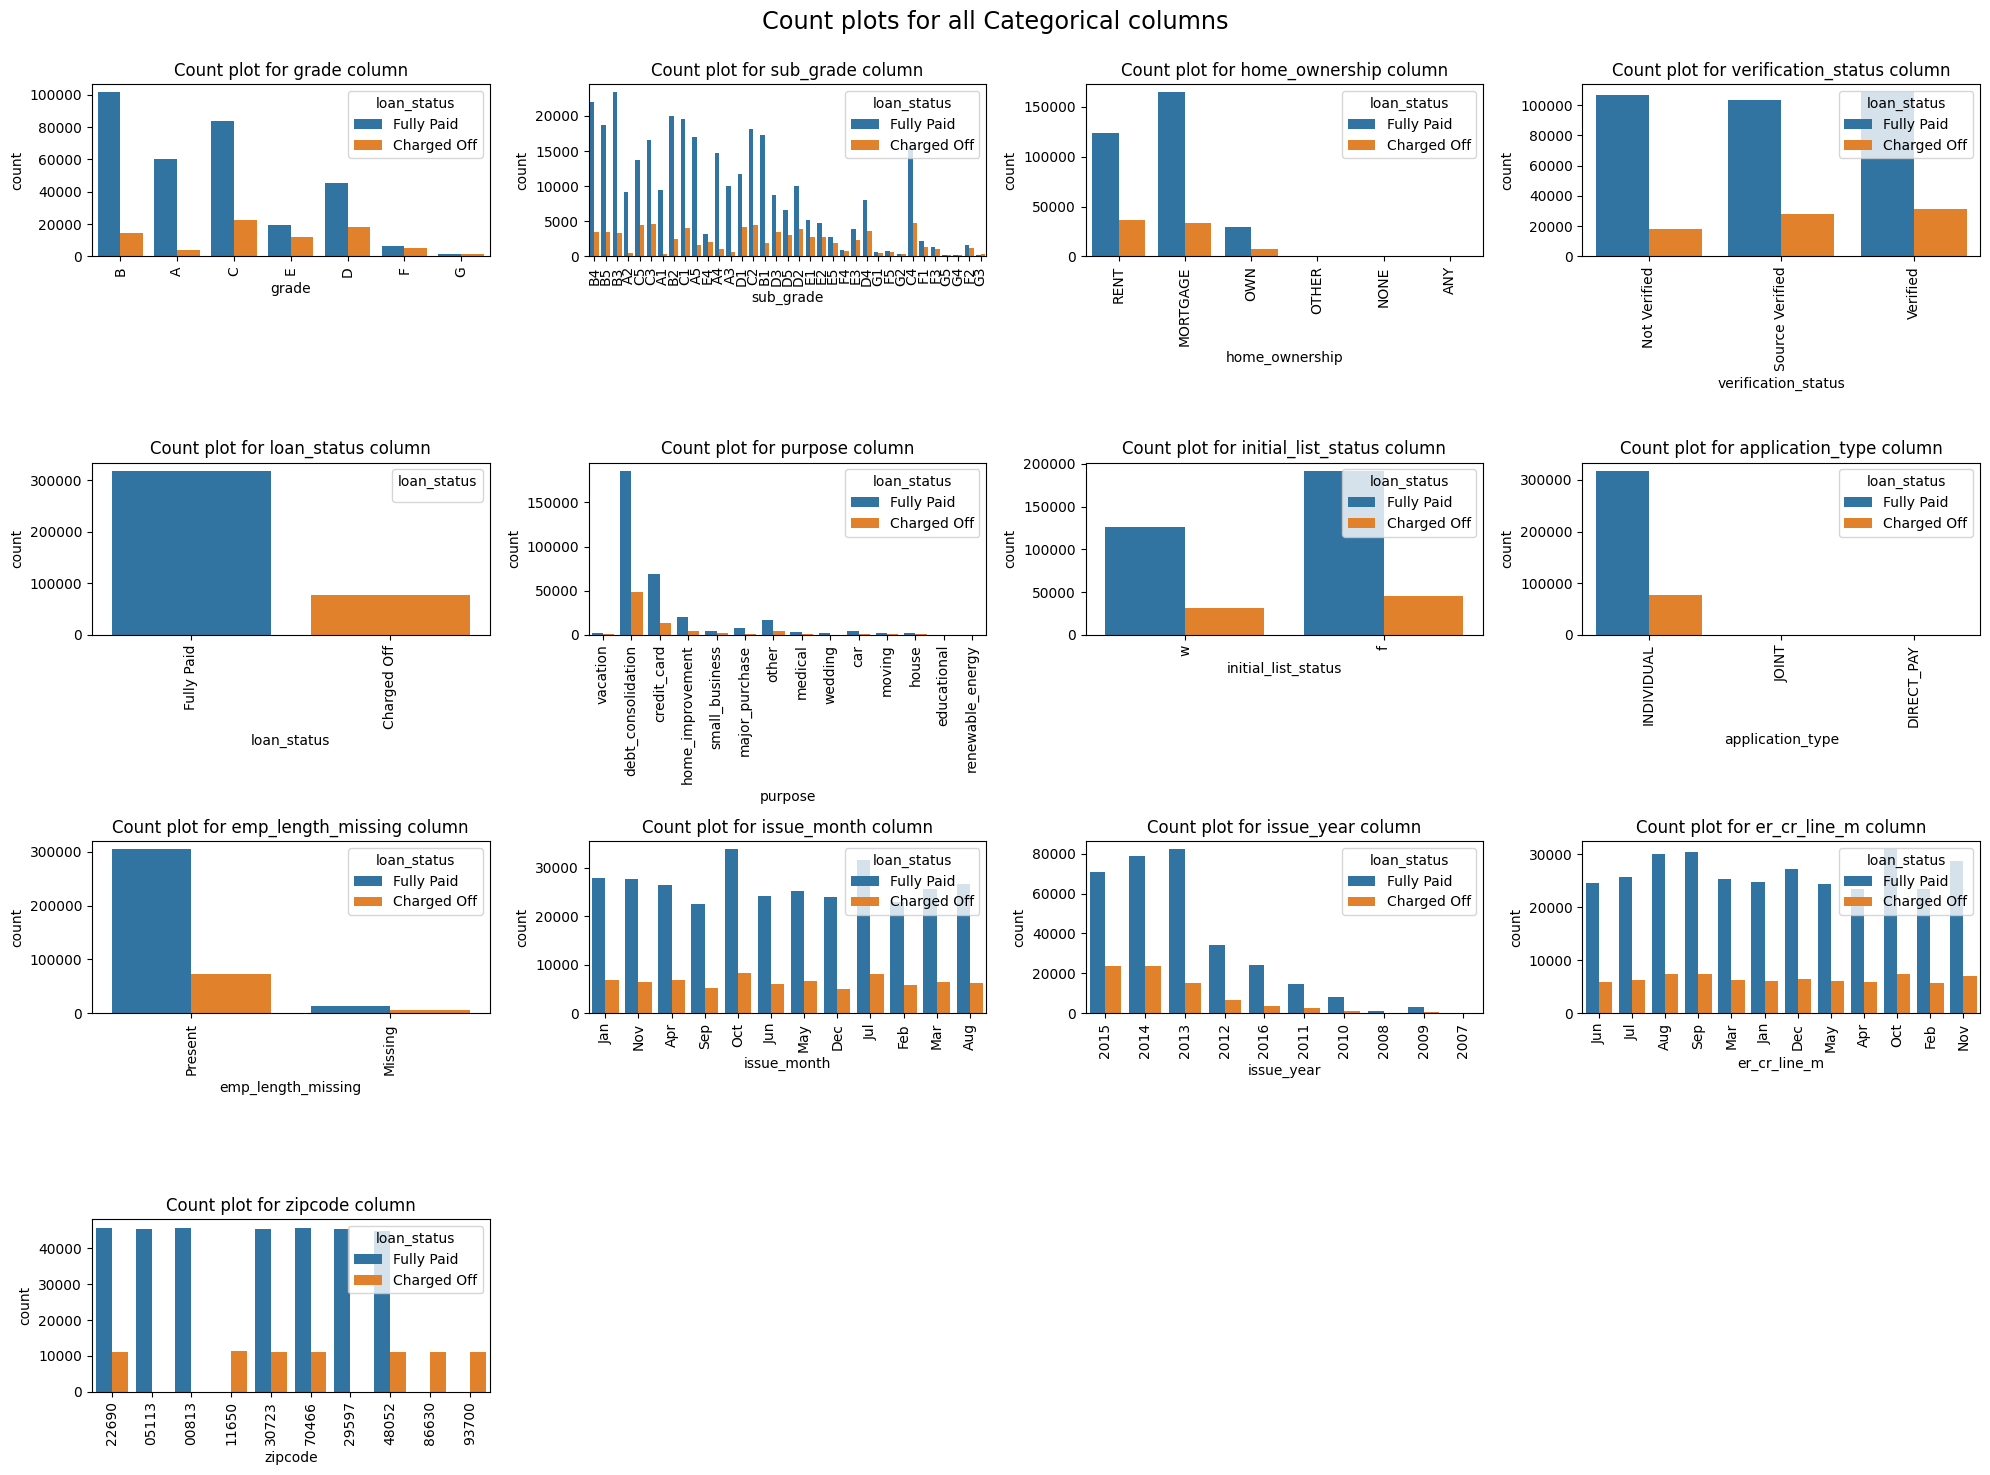

In [39]:
fig = plt.figure(figsize = (20,15))
fig.suptitle("Count plots for all Categorical columns\n",fontsize = "xx-large" )
k = 1
for i in categorical_cols:
    if loan_data[i].nunique()<50:
        plt.subplot(4,4,k)
        plt.title("Count plot for {} column".format(i))
        sns.countplot(data=loan_data, x=i, hue = 'loan_status')
        plt.legend(title = 'loan_status')
        plt.xticks(rotation = 90)
        k = k+1
plt.tight_layout()
plt.show()

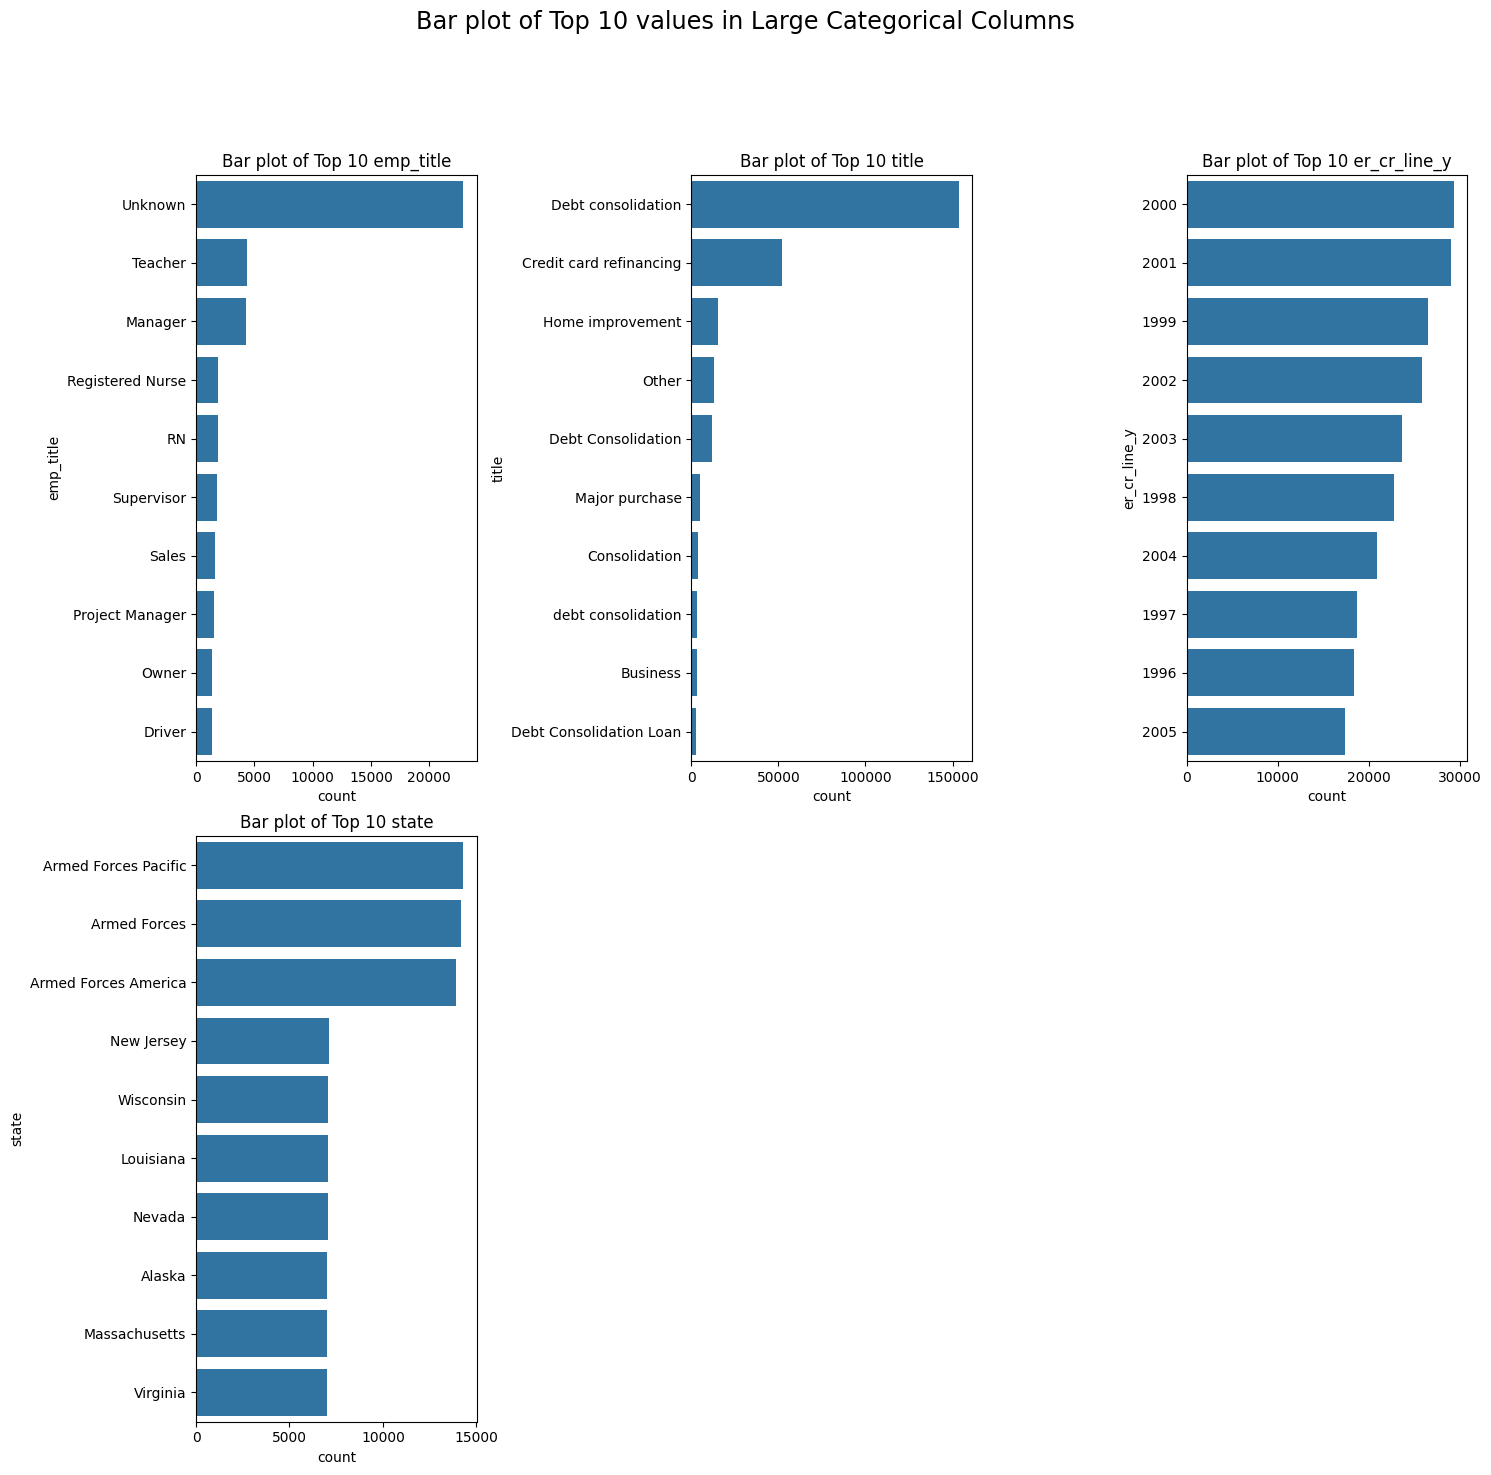

In [40]:
fig = plt.figure(figsize = (15, 15))
plt.suptitle("Bar plot of Top 10 values in Large Categorical Columns\n",fontsize = "xx-large")
k = 1
for p in categorical_cols:
    if loan_data[p].nunique()>=50:
        plt.subplot(2,3,k)
        plt.title(f"Bar plot of Top 10 {p}")
        k += 1
        top_10 = loan_data[p].value_counts()[:10].reset_index()
        top_10.columns = [p, 'count']
        sns.barplot(x='count', y=p, data=top_10, orient='h')
plt.tight_layout()
plt.subplots_adjust(top=0.87)
plt.show()

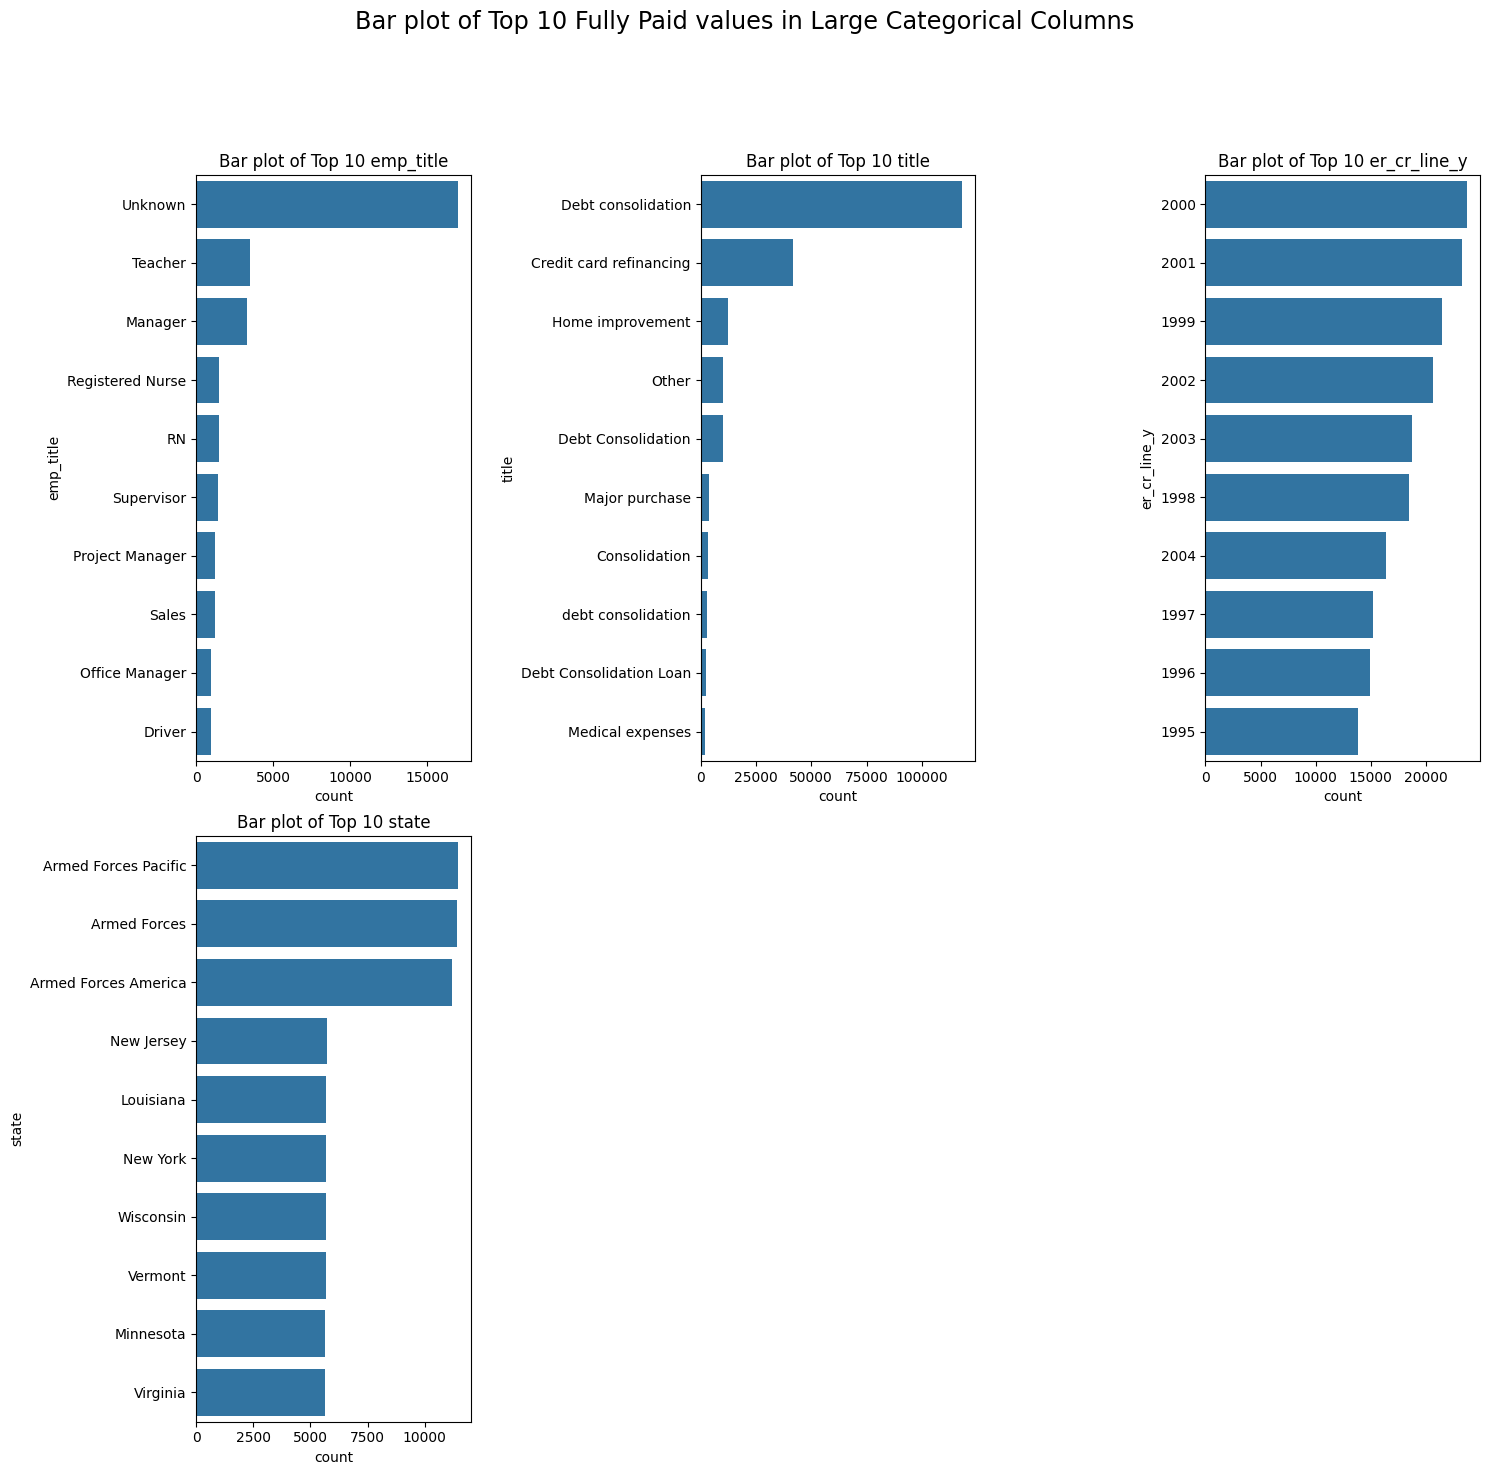

In [41]:
fig = plt.figure(figsize = (15, 15))
plt.suptitle("Bar plot of Top 10 Fully Paid values in Large Categorical Columns\n",fontsize = "xx-large")
k = 1
for p in categorical_cols:
    if loan_data[p].nunique()>=50:
        plt.subplot(2,3,k)
        plt.title(f"Bar plot of Top 10 {p}")
        k += 1
        top_10 = loan_data[loan_data['loan_status'] == 'Fully Paid'][p].value_counts()[:10].reset_index()
        top_10.columns = [p, 'count']
        sns.barplot(x='count', y=p, data=top_10, orient='h')
plt.tight_layout()
plt.subplots_adjust(top=0.87)
plt.show()

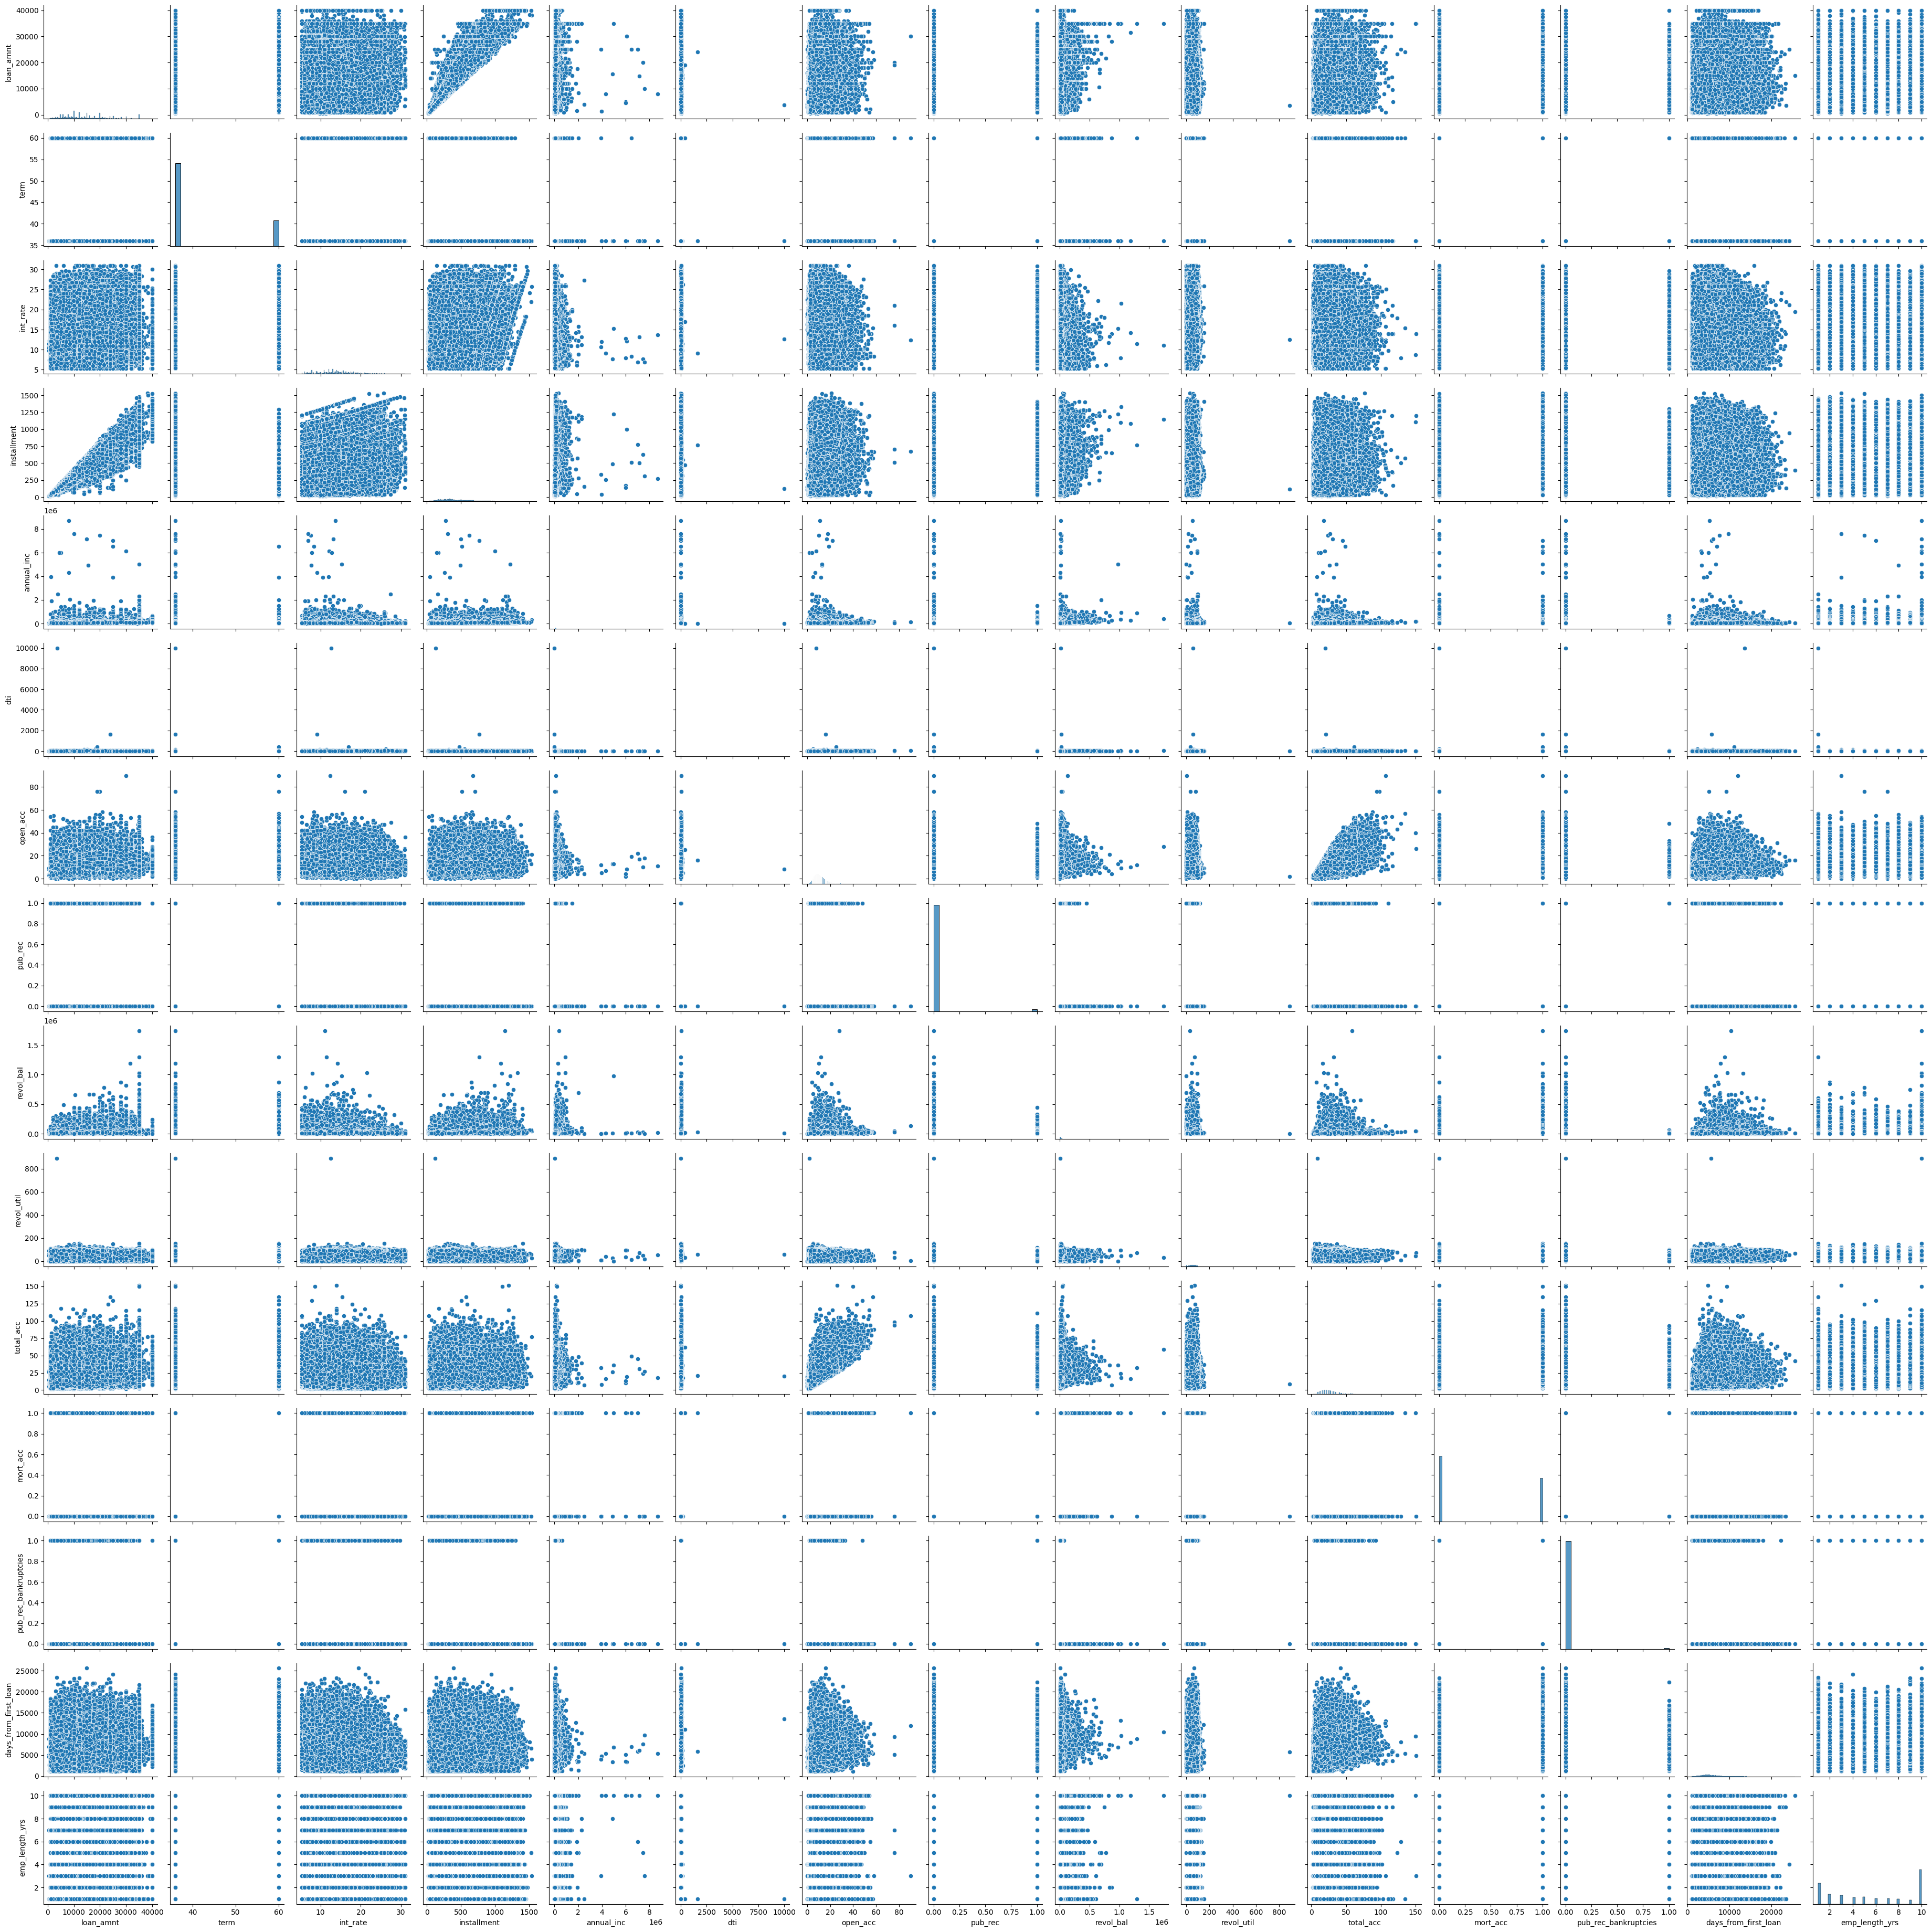

In [42]:
sns.pairplot(data = loan_data)

<Axes: >

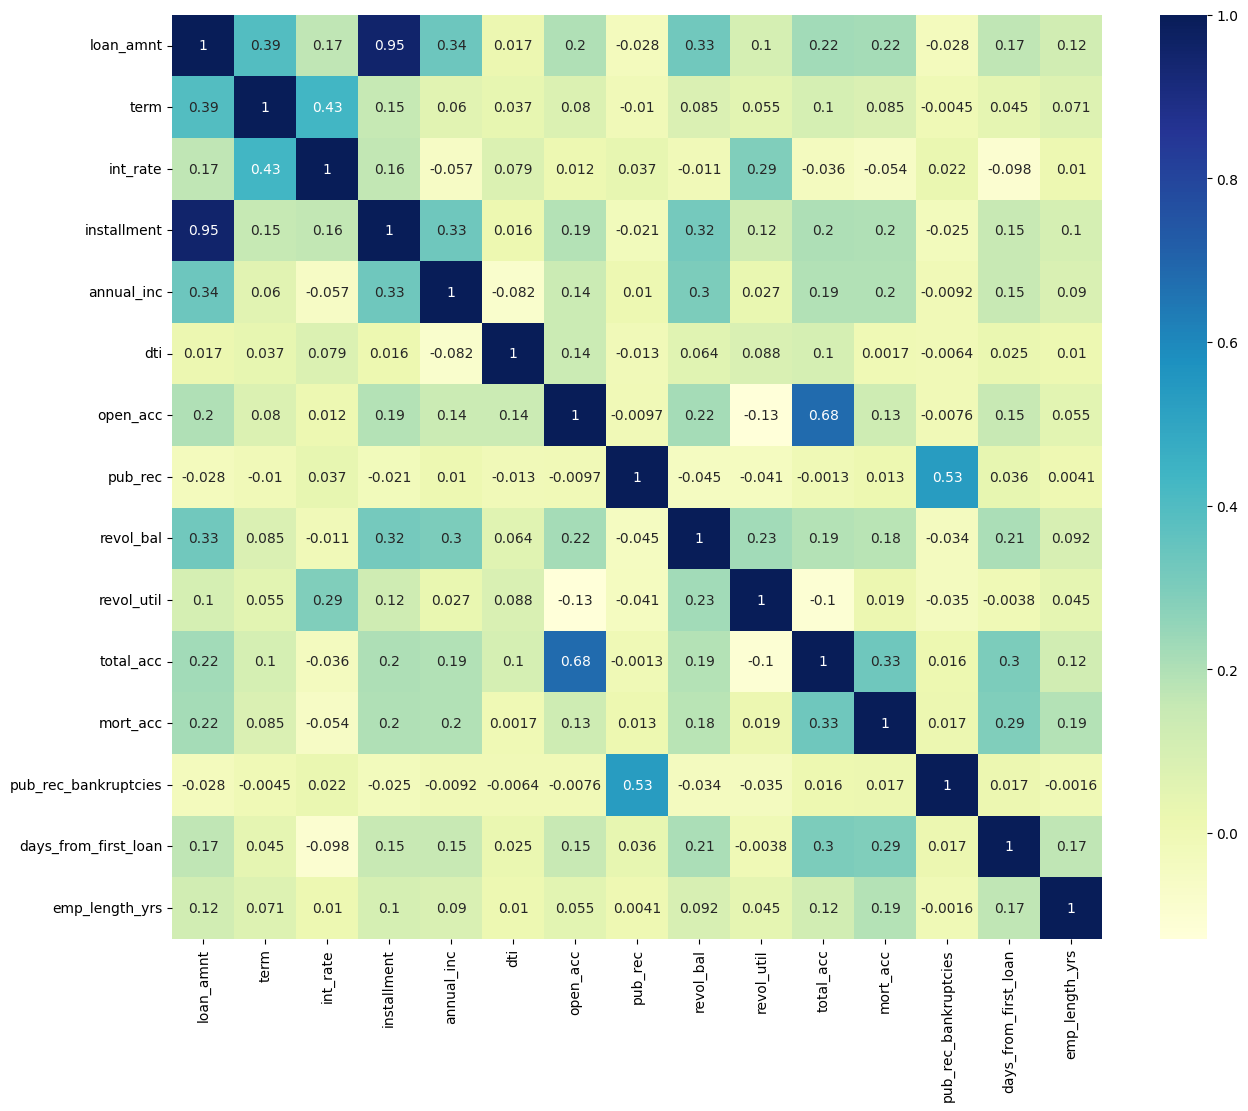

In [43]:
fig = plt.figure(figsize= (15,12))
sns.heatmap(loan_data.corr(numeric_only=True), cmap="YlGnBu", annot=True)

<Axes: >

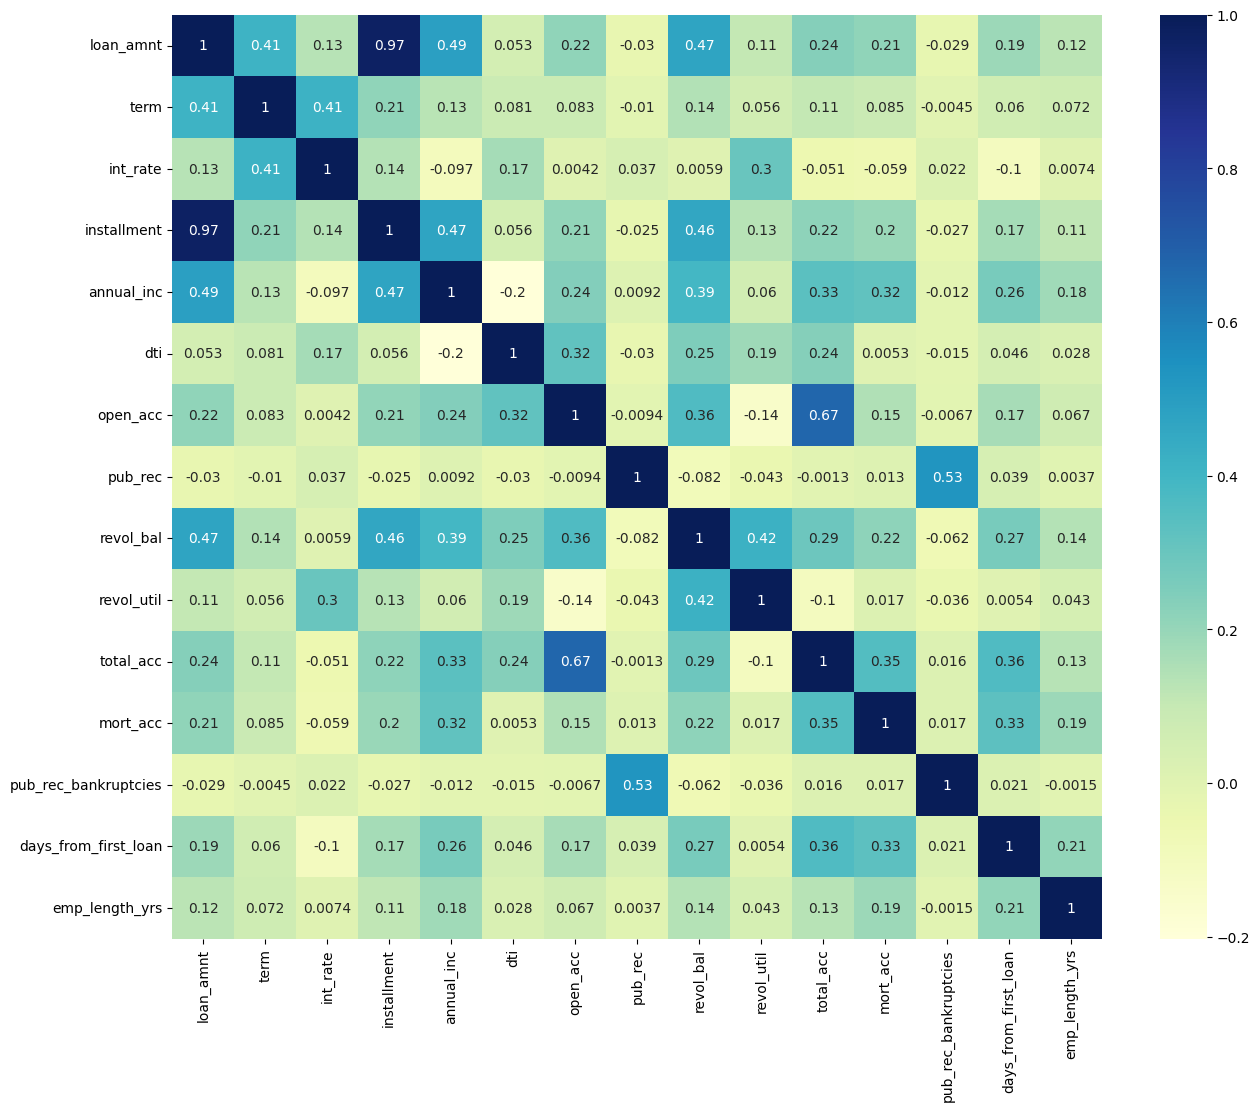

In [44]:
fig = plt.figure(figsize= (15,12))
sns.heatmap(loan_data.corr(numeric_only=True,method = 'spearman'), cmap="YlGnBu", annot=True)

Observations:
- Borrowers who defaulted (Charged Off) tend to have higher interest rates (int_rate) and larger loan terms (term) compared to those who fully paid, indicating that longer-term and costlier loans are riskier.
- Features like loan_amnt, installment, and dti are slightly higher for Charged Off loans, but the separation is not very sharp, suggesting they contribute moderately to default risk but are not individually strong separators.
- Categorical features like grade and sub_grade show clear patterns where lower grades (e.g., E, F, G) have a significantly higher proportion of Charged Off loans compared to higher grades (A, B, C), making credit grade a very important predictor.
- The purpose of the loan plays a role: categories like small_business, renewable_energy, and medical have higher Charge Off rates, implying the loan objective itself carries risk information.
- Strong multicollinearity is observed between loan_amnt and installment (correlation > 0.95), as well as between open_acc and total_acc, indicating redundant features that need removal or adjustment.
- Employment length (emp_length_yrs) and revol_utilization (revol_util) show minimal separation between Fully Paid and Charged Off groups, suggesting these features may be weaker predictors individually unless combined with others.


# Outlier Treatment

In [45]:
numerical_cols = ['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 'open_acc', 'revol_bal', 'revol_util', 'total_acc', 'days_from_first_loan']

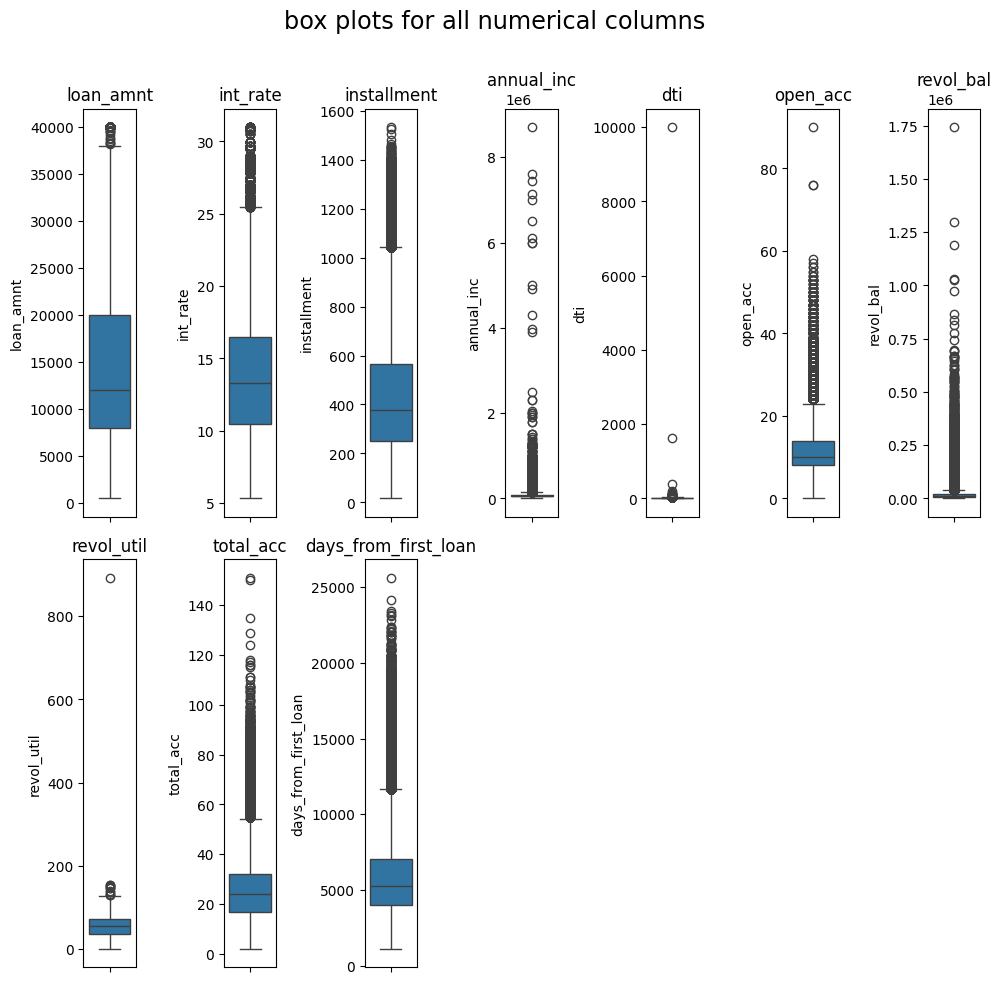

In [46]:
fig = plt.figure(figsize = (10,10))
fig.suptitle("box plots for all numerical columns\n",fontsize = "xx-large" )
k = 1
for i in numerical_cols:
    plt.subplot(2,7,k)
    plt.title("{}".format(i))
    sns.boxplot(data=loan_data[i])
    k = k+1
plt.tight_layout()
plt.show()

In [47]:
def detect_outliers_iqr(df,i):
    q1 = df[i].quantile(0.25)
    q3 = df[i].quantile(0.75)
    IQR = q3-q1
    lwr_bound = q1-(1.5*IQR)
    upr_bound = q3+(1.5*IQR)
    df[i]= pd.DataFrame(np.where(df[i] > upr_bound, upr_bound,(np.where(df[i] <lwr_bound,lwr_bound, df[i]))), columns=[i])
for i in numerical_cols:
    detect_outliers_iqr(loan_data,i)

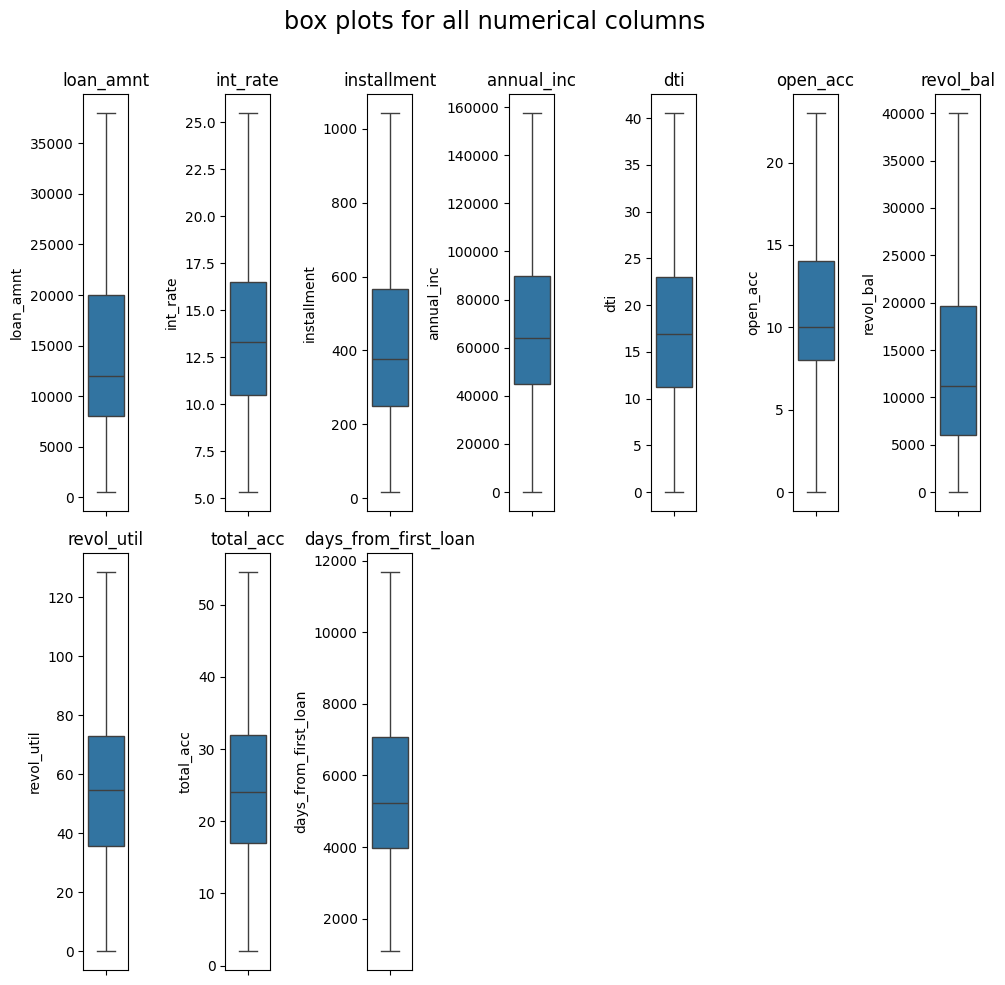

In [48]:
fig = plt.figure(figsize = (10,10))
fig.suptitle("box plots for all numerical columns\n",fontsize = "xx-large" )
k = 1
for i in numerical_cols:
    plt.subplot(2,7,k)
    plt.title("{}".format(i))
    sns.boxplot(data=loan_data[i])
    k = k+1
plt.tight_layout()
plt.show()

In [49]:
loan_data.drop(['emp_length_missing'], axis=1, inplace=True)

In [50]:
loan_data.head()

loan_amnt  term  int_rate  installment grade sub_grade  \
0    10000.0    36     11.44       329.48     B        B4   
1     8000.0    36     11.99       265.68     B        B5   
2    15600.0    36     10.49       506.97     B        B3   
3     7200.0    36      6.49       220.65     A        A2   
4    24375.0    60     17.27       609.33     C        C5   

                 emp_title home_ownership  annual_inc verification_status  \
0                Marketing           RENT    117000.0        Not Verified   
1          Credit analyst        MORTGAGE     65000.0        Not Verified   
2             Statistician           RENT     43057.0     Source Verified   
3          Client Advocate           RENT     54000.0        Not Verified   
4  Destiny Management Inc.       MORTGAGE     55000.0            Verified   

   loan_status             purpose                    title    dti  open_acc  \
0   Fully Paid            vacation                 Vacation  26.24      16.0   
1   Fully Paid  debt_consolidation       Debt consolidation  22.05      17.0   
2   Fully Paid         credit_card  Credit card refinancing  12.79      13.0   
3   Fully Paid         credit_card  Credit card refinancing   2.60       6.0   
4  Charged Off         credit_card    Credit Card Refinance  33.95      13.0   

   pub_rec  revol_bal  revol_util  total_acc initial_list_status  \
0        0    36369.0        41.8       25.0                   w   
1        0    20131.0        53.3       27.0                   f   
2        0    11987.0        92.2       26.0                   f   
3        0     5472.0        21.5       13.0                   f   
4        0    24584.0        69.8       43.0                   f   

  application_type  mort_acc  pub_rec_bankruptcies issue_month issue_year  \
0       INDIVIDUAL         0                     0         Jan       2015   
1       INDIVIDUAL         1                     0         Jan       2015   
2       INDIVIDUAL         0                     0         Jan       2015   
3       INDIVIDUAL         0                     0         Nov       2014   
4       INDIVIDUAL         0                     0         Apr       2013   

  er_cr_line_m er_cr_line_y  days_from_first_loan          state zipcode  \
0          Jun         1990                8980.0       Oklahoma   22690   
1          Jul         2004                3836.0   South Dakota   05113   
2          Aug         2007                2710.0  West Virginia   05113   
3          Sep         2006                2983.0  Massachusetts   00813   
4          Mar         1999                5145.0       Virginia   11650   

   emp_length_yrs  
0              10  
1               4  
2               1  
3               6  
4               9

In [51]:
loan_data['sub_grade'].value_counts()

sub_grade
B3    26655
B4    25601
C1    23662
C2    22580
B2    22495
B5    22085
C3    21221
C4    20280
B1    19182
A5    18526
C5    18244
D1    15993
A4    15789
D2    13951
D3    12223
D4    11657
A3    10576
A1     9729
D5     9700
A2     9567
E1     7917
E2     7431
E3     6207
E4     5361
E5     4572
F1     3536
F2     2766
F3     2286
F4     1787
F5     1397
G1     1058
G2      754
G3      552
G4      374
G5      316
Name: count, dtype: int64

In [52]:
loan_data['term'].value_counts()

term
36    302005
60     94025
Name: count, dtype: int64

In [53]:
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 31 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             396030 non-null  float64
 1   term                  396030 non-null  int64  
 2   int_rate              396030 non-null  float64
 3   installment           396030 non-null  float64
 4   grade                 396030 non-null  object 
 5   sub_grade             396030 non-null  object 
 6   emp_title             396030 non-null  object 
 7   home_ownership        396030 non-null  object 
 8   annual_inc            396030 non-null  float64
 9   verification_status   396030 non-null  object 
 10  loan_status           396030 non-null  object 
 11  purpose               396030 non-null  object 
 12  title                 396030 non-null  object 
 13  dti                   396030 non-null  float64
 14  open_acc              396030 non-null  float64
 15  

Observations: 
- Outliers are removed by using IQR + clipping method.
- Z-score method can also be used, but the current method is more robust in case skewed distributions.

# Encoding

## Manual Encoding

In [54]:
for i in loan_data.columns:
    print(i)
    print(loan_data[i].nunique())
    if loan_data[i].nunique() <= 10:
        print(loan_data[i].value_counts())
    print('-'*120)

loan_amnt
1385
------------------------------------------------------------------------------------------------------------------------
term
2
term
36    302005
60     94025
Name: count, dtype: int64
------------------------------------------------------------------------------------------------------------------------
int_rate
525
------------------------------------------------------------------------------------------------------------------------
installment
53616
------------------------------------------------------------------------------------------------------------------------
grade
7
grade
B    116018
C    105987
A     64187
D     63524
E     31488
F     11772
G      3054
Name: count, dtype: int64
------------------------------------------------------------------------------------------------------------------------
sub_grade
35
------------------------------------------------------------------------------------------------------------------------
emp_title
173106
----------

In [55]:
loan_data['loan_status']=loan_data.loan_status.map({'Fully Paid':0, 'Charged Off':1})

In [56]:
loan_data['loan_status'].value_counts()

loan_status
0    318357
1     77673
Name: count, dtype: int64

In [57]:
loan_data['issue_month'].value_counts()

issue_month
Oct    42130
Jul    39714
Jan    34682
Nov    34068
Apr    33223
Aug    32816
Mar    31919
May    31895
Jun    30140
Dec    29082
Feb    28742
Sep    27619
Name: count, dtype: int64

Observations:
- Charged off should be `Class 1` and Fully paid should be `Class 0` strictly for maintaing the correctness in Confusion Matrix. There Manual encoding is used.


## One hot encoding

In [58]:
loan_data.dtypes

loan_amnt               float64
term                      int64
int_rate                float64
installment             float64
grade                    object
sub_grade                object
emp_title                object
home_ownership           object
annual_inc              float64
verification_status      object
loan_status               int64
purpose                  object
title                    object
dti                     float64
open_acc                float64
pub_rec                   int64
revol_bal               float64
revol_util              float64
total_acc               float64
initial_list_status      object
application_type         object
mort_acc                  int64
pub_rec_bankruptcies      int64
issue_month              object
issue_year               object
er_cr_line_m             object
er_cr_line_y             object
days_from_first_loan    float64
state                    object
zipcode                  object
emp_length_yrs            int64
dtype: o

In [59]:
loan_data.drop(['emp_title','title','sub_grade','issue_year','issue_month','er_cr_line_m','er_cr_line_y'], axis=1, inplace=True)

In [60]:
loan_data.head()

loan_amnt  term  int_rate  installment grade home_ownership  annual_inc  \
0    10000.0    36     11.44       329.48     B           RENT    117000.0   
1     8000.0    36     11.99       265.68     B       MORTGAGE     65000.0   
2    15600.0    36     10.49       506.97     B           RENT     43057.0   
3     7200.0    36      6.49       220.65     A           RENT     54000.0   
4    24375.0    60     17.27       609.33     C       MORTGAGE     55000.0   

  verification_status  loan_status             purpose    dti  open_acc  \
0        Not Verified            0            vacation  26.24      16.0   
1        Not Verified            0  debt_consolidation  22.05      17.0   
2     Source Verified            0         credit_card  12.79      13.0   
3        Not Verified            0         credit_card   2.60       6.0   
4            Verified            1         credit_card  33.95      13.0   

   pub_rec  revol_bal  revol_util  total_acc initial_list_status  \
0        0    36369.0        41.8       25.0                   w   
1        0    20131.0        53.3       27.0                   f   
2        0    11987.0        92.2       26.0                   f   
3        0     5472.0        21.5       13.0                   f   
4        0    24584.0        69.8       43.0                   f   

  application_type  mort_acc  pub_rec_bankruptcies  days_from_first_loan  \
0       INDIVIDUAL         0                     0                8980.0   
1       INDIVIDUAL         1                     0                3836.0   
2       INDIVIDUAL         0                     0                2710.0   
3       INDIVIDUAL         0                     0                2983.0   
4       INDIVIDUAL         0                     0                5145.0   

           state zipcode  emp_length_yrs  
0       Oklahoma   22690              10  
1   South Dakota   05113               4  
2  West Virginia   05113               1  
3  Massachusetts   00813               6  
4       Virginia   11650               9

In [61]:
# Select categorical columns you want to encode
categorical_cols = ['grade', 'home_ownership', 'verification_status', 'application_type', 'initial_list_status','zipcode']

# Initialize OneHotEncoder
ohe = OneHotEncoder(drop='first', sparse_output=False)

# Fit and transform
encoded_array = ohe.fit_transform(loan_data[categorical_cols])

# Get the encoded feature names
encoded_cols = ohe.get_feature_names_out(categorical_cols)

# Create a DataFrame from the encoded array
encoded_df = pd.DataFrame(encoded_array, columns=encoded_cols, index=loan_data.index)

# Drop the original categorical columns and concatenate the new encoded columns
loan_data_encoded = pd.concat([loan_data.drop(columns=categorical_cols), encoded_df], axis=1)

# Now loan_data_encoded is ready


In [62]:
loan_data_encoded.head()

loan_amnt  term  int_rate  installment  annual_inc  loan_status  \
0    10000.0    36     11.44       329.48    117000.0            0   
1     8000.0    36     11.99       265.68     65000.0            0   
2    15600.0    36     10.49       506.97     43057.0            0   
3     7200.0    36      6.49       220.65     54000.0            0   
4    24375.0    60     17.27       609.33     55000.0            1   

              purpose    dti  open_acc  pub_rec  revol_bal  revol_util  \
0            vacation  26.24      16.0        0    36369.0        41.8   
1  debt_consolidation  22.05      17.0        0    20131.0        53.3   
2         credit_card  12.79      13.0        0    11987.0        92.2   
3         credit_card   2.60       6.0        0     5472.0        21.5   
4         credit_card  33.95      13.0        0    24584.0        69.8   

   total_acc  mort_acc  pub_rec_bankruptcies  days_from_first_loan  \
0       25.0         0                     0                8980.0   
1       27.0         1                     0                3836.0   
2       26.0         0                     0                2710.0   
3       13.0         0                     0                2983.0   
4       43.0         0                     0                5145.0   

           state  emp_length_yrs  grade_B  grade_C  grade_D  grade_E  grade_F  \
0       Oklahoma              10      1.0      0.0      0.0      0.0      0.0   
1   South Dakota               4      1.0      0.0      0.0      0.0      0.0   
2  West Virginia               1      1.0      0.0      0.0      0.0      0.0   
3  Massachusetts               6      0.0      0.0      0.0      0.0      0.0   
4       Virginia               9      0.0      1.0      0.0      0.0      0.0   

   grade_G  home_ownership_MORTGAGE  home_ownership_NONE  \
0      0.0                      0.0                  0.0   
1      0.0                      1.0                  0.0   
2      0.0                      0.0                  0.0   
3      0.0                      0.0                  0.0   
4      0.0                      1.0                  0.0   

   home_ownership_OTHER  home_ownership_OWN  home_ownership_RENT  \
0                   0.0                 0.0                  1.0   
1                   0.0                 0.0                  0.0   
2                   0.0                 0.0                  1.0   
3                   0.0                 0.0                  1.0   
4                   0.0                 0.0                  0.0   

   verification_status_Source Verified  verification_status_Verified  \
0                                  0.0                           0.0   
1                                  0.0                           0.0   
2                                  1.0                           0.0   
3                                  0.0                           0.0   
4                                  0.0                           1.0   

   application_type_INDIVIDUAL  application_type_JOINT  initial_list_status_w  \
0                          1.0                     0.0                    1.0   
1                          1.0                     0.0                    0.0   
2                          1.0                     0.0                    0.0   
3                          1.0                     0.0                    0.0   
4                          1.0                     0.0                    0.0   

   zipcode_05113  zipcode_11650  zipcode_22690  zipcode_29597  zipcode_30723  \
0            0.0            0.0            1.0            0.0            0.0   
1            1.0            0.0            0.0            0.0            0.0   
2            1.0            0.0            0.0            0.0            0.0   
3            0.0            0.0            0.0            0.0            0.0   
4            0.0            1.0            0.0            0.0            0.0   

   zipcode_48052  zipcode_70466  zipcode_86630  zipcode_93

In [63]:
loan_data_encoded.dtypes

loan_amnt                              float64
term                                     int64
int_rate                               float64
installment                            float64
annual_inc                             float64
loan_status                              int64
purpose                                 object
dti                                    float64
open_acc                               float64
pub_rec                                  int64
revol_bal                              float64
revol_util                             float64
total_acc                              float64
mort_acc                                 int64
pub_rec_bankruptcies                     int64
days_from_first_loan                   float64
state                                   object
emp_length_yrs                           int64
grade_B                                float64
grade_C                                float64
grade_D                                float64
grade_E      

Observations:
- If the features have unique values <=10, One Hot encoding is used.

## Target Encoding

In [64]:
target_enc = ['purpose','state']
for col in target_enc:
    te = TargetEncoder()
    loan_data_encoded[col] = te.fit_transform(loan_data_encoded[col], loan_data_encoded['loan_status'])

In [65]:
loan_data_encoded.head()

loan_amnt  term  int_rate  installment  annual_inc  loan_status   purpose  \
0    10000.0    36     11.44       329.48    117000.0            0  0.189233   
1     8000.0    36     11.99       265.68     65000.0            0  0.207414   
2    15600.0    36     10.49       506.97     43057.0            0  0.167118   
3     7200.0    36      6.49       220.65     54000.0            0  0.167118   
4    24375.0    60     17.27       609.33     55000.0            1  0.167118   

     dti  open_acc  pub_rec  revol_bal  revol_util  total_acc  mort_acc  \
0  26.24      16.0        0    36369.0        41.8       25.0         0   
1  22.05      17.0        0    20131.0        53.3       27.0         1   
2  12.79      13.0        0    11987.0        92.2       26.0         0   
3   2.60       6.0        0     5472.0        21.5       13.0         0   
4  33.95      13.0        0    24584.0        69.8       43.0         0   

   pub_rec_bankruptcies  days_from_first_loan     state  emp_length_yrs  \
0                     0                8980.0  0.192013              10   
1                     0                3836.0  0.197038               4   
2                     0                2710.0  0.204061               1   
3                     0                2983.0  0.196098               6   
4                     0                5145.0  0.195101               9   

   grade_B  grade_C  grade_D  grade_E  grade_F  grade_G  \
0      1.0      0.0      0.0      0.0      0.0      0.0   
1      1.0      0.0      0.0      0.0      0.0      0.0   
2      1.0      0.0      0.0      0.0      0.0      0.0   
3      0.0      0.0      0.0      0.0      0.0      0.0   
4      0.0      1.0      0.0      0.0      0.0      0.0   

   home_ownership_MORTGAGE  home_ownership_NONE  home_ownership_OTHER  \
0                      0.0                  0.0                   0.0   
1                      1.0                  0.0                   0.0   
2                      0.0                  0.0                   0.0   
3                      0.0                  0.0                   0.0   
4                      1.0                  0.0                   0.0   

   home_ownership_OWN  home_ownership_RENT  \
0                 0.0                  1.0   
1                 0.0                  0.0   
2                 0.0                  1.0   
3                 0.0                  1.0   
4                 0.0                  0.0   

   verification_status_Source Verified  verification_status_Verified  \
0                                  0.0                           0.0   
1                                  0.0                           0.0   
2                                  1.0                           0.0   
3                                  0.0                           0.0   
4                                  0.0                           1.0   

   application_type_INDIVIDUAL  application_type_JOINT  initial_list_status_w  \
0                          1.0                     0.0                    1.0   
1                          1.0                     0.0                    0.0   
2                          1.0                     0.0                    0.0   
3                          1.0                     0.0                    0.0   
4                          1.0                     0.0                    0.0   

   zipcode_05113  zipcode_11650  zipcode_22690  zipcode_29597  zipcode_30723  \
0            0.0            0.0            1.0            0.0            0.0   
1            1.0            0.0            0.0            0.0            0.0   
2            1.0            0.0            0.0            0.0            0.0   
3            0.0            0.0            0.0            0.0            0.0   
4            0.0            1.0            0.0            0.0            0.0   

   zipcode_48052  zipcode_70466  zipcode_86630  zipcode_93700  
0            0.0            0.0            0.0            0.0  
1            0.0    

In [66]:
loan_data_encoded.dtypes

loan_amnt                              float64
term                                     int64
int_rate                               float64
installment                            float64
annual_inc                             float64
loan_status                              int64
purpose                                float64
dti                                    float64
open_acc                               float64
pub_rec                                  int64
revol_bal                              float64
revol_util                             float64
total_acc                              float64
mort_acc                                 int64
pub_rec_bankruptcies                     int64
days_from_first_loan                   float64
state                                  float64
emp_length_yrs                           int64
grade_B                                float64
grade_C                                float64
grade_D                                float64
grade_E      

Observations:
- Target encoding is used for features with unique values > 10 and Date realted and features with high unique values(like emp_title,title, issue_month etc) are removed form the data.

# Train test split

In [117]:
X=loan_data_encoded.drop('loan_status',axis=1)
y=loan_data_encoded['loan_status']

In [118]:
X_tr_cv, X_test, y_tr_cv, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_tr_cv, y_tr_cv, test_size=0.25,random_state=42,stratify=y_tr_cv)
print("train data shape: ",X_train.shape)
print("val data shape: ",X_val.shape)
print("test data shape: ",X_test.shape)

train data shape:  (237618, 42)
val data shape:  (79206, 42)
test data shape:  (79206, 42)


Observations:
- Dataset is sufficient enough for train, validation and test split.
- Used stratified splitting.

# Standardization

In [119]:
StdSclr = StandardScaler()
StdSclr.fit(X_train) # fit on training data
X_train = StdSclr.transform(X_train)
X_val = StdSclr.transform(X_val)
X_test = StdSclr.transform(X_test)

# Removal of Un-Wanted features using `ols method`

In [120]:
X_sm = sm.add_constant(np.array(X_train))  #Statmodels default is without intercept, to add intercept we need to add constant

sm_model = sm.OLS(y_train, X_sm).fit()

print(sm_model.summary())

                            OLS Regression Results                            
Dep. Variable:            loan_status   R-squared:                       0.460
Model:                            OLS   Adj. R-squared:                  0.459
Method:                 Least Squares   F-statistic:                     4810.
Date:                Sun, 27 Apr 2025   Prob (F-statistic):               0.00
Time:                        01:00:13   Log-Likelihood:                -44583.
No. Observations:              237618   AIC:                         8.925e+04
Df Residuals:                  237575   BIC:                         8.970e+04
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1961      0.001    327.490      0.0

In [121]:
col_names = list(X.columns)
i = 1
for j in col_names:
    if sm_model.pvalues[i] > 0.05:
        print(f"{j:<20} --> Weight = {sm_model.params[i]:<10.5}, p-value = {sm_model.pvalues[i]:<10.5}")
    i += 1

mort_acc             --> Weight = -0.0011301, p-value = 0.12503   
pub_rec_bankruptcies --> Weight = -4.9982e-05, p-value = 0.94368   
home_ownership_MORTGAGE --> Weight = 0.1026    , p-value = 0.3203    
home_ownership_NONE  --> Weight = 0.0016236 , p-value = 0.3792    
home_ownership_OTHER --> Weight = 0.0036121 , p-value = 0.31145   
home_ownership_OWN   --> Weight = 0.063605  , p-value = 0.29526   
home_ownership_RENT  --> Weight = 0.11072   , p-value = 0.27422   
application_type_INDIVIDUAL --> Weight = 0.00040965, p-value = 0.67046   
initial_list_status_w --> Weight = 0.00076636, p-value = 0.21474   
zipcode_05113        --> Weight = -0.00020821, p-value = 0.79348   
zipcode_29597        --> Weight = -0.00027647, p-value = 0.72834   


C:\Users\sreem\AppData\Local\Temp\ipykernel_34316\1762540305.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if sm_model.pvalues[i] > 0.05:
C:\Users\sreem\AppData\Local\Temp\ipykernel_34316\1762540305.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"{j:<20} --> Weight = {sm_model.params[i]:<10.5}, p-value = {sm_model.pvalues[i]:<10.5}")


In [122]:
X_working = X_train.copy()  # still NumPy array
col_names = list(col_names) # still list of strings

In [123]:
# Ensure you have the feature names list
iteration = 1

while True:
    X_sm = sm.add_constant(X_working)  # add intercept
    sm_model = sm.OLS(y_train, X_sm).fit()

    p_values = sm_model.pvalues[1:]  # skip intercept
    max_p_value = p_values.max()

    if max_p_value > 0.05:
        max_p_index = p_values.argmax()  # get integer index of max p-value
        max_p_feature = col_names[max_p_index]  # corresponding feature name

        print(f"Iteration {iteration}:")
        print(f"Removing feature '{max_p_feature}' with p-value {max_p_value:.5f}\n")

        # Remove feature from both X_working and col_names
        X_working = np.delete(X_working, max_p_index, axis=1)
        X_val = np.delete(X_val, max_p_index, axis=1)
        X_test = np.delete(X_test, max_p_index, axis=1)
        col_names.pop(max_p_index)


        iteration += 1
    else:
        print("✅ All features have p-value ≤ 0.05. Backward elimination completed.\n")
        break

# Final summary after elimination
X_sm_final = sm.add_constant(X_working)
final_model = sm.OLS(y_train, X_sm_final).fit()
print(final_model.summary())

# Final selected features
final_selected_features = col_names
print("\n🎯 Final Selected Features:")
print(final_selected_features)


Iteration 1:
Removing feature 'pub_rec_bankruptcies' with p-value 0.94368

Iteration 2:
Removing feature 'zipcode_05113' with p-value 0.79335

Iteration 3:
Removing feature 'zipcode_29597' with p-value 0.80240

Iteration 4:
Removing feature 'application_type_INDIVIDUAL' with p-value 0.67036

Iteration 5:
Removing feature 'home_ownership_NONE' with p-value 0.37922

Iteration 6:
Removing feature 'home_ownership_MORTGAGE' with p-value 0.61772

Iteration 7:
Removing feature 'home_ownership_OTHER' with p-value 0.84677

Iteration 8:
Removing feature 'initial_list_status_w' with p-value 0.21703

Iteration 9:
Removing feature 'mort_acc' with p-value 0.15024

✅ All features have p-value ≤ 0.05. Backward elimination completed.

                            OLS Regression Results                            
Dep. Variable:            loan_status   R-squared:                       0.460
Model:                            OLS   Adj. R-squared:                  0.459
Method:                 Least Squar

Observations:
- P-value > 0.05 is indicating that the even if the weights of those features are made to 0, accuracy wouldnot be effected. 
- Therefore these are to treated as redundant features, hereby removing them in Train, Validation, Test data.

# Automatic multicollinearity removal based on VIF

In [124]:
vif = pd.DataFrame()
vif['Features'] = col_names
vif['VIF'] = [variance_inflation_factor(X_working, i) for i in range(X_working.shape[1])]

vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features    VIF
0                             loan_amnt  58.40
3                           installment  50.54
2                              int_rate  12.30
17                              grade_D   9.72
18                              grade_E   8.51
16                              grade_C   7.47
1                                  term   5.99
19                              grade_F   5.60
15                              grade_B   3.77
20                              grade_G   2.46
7                              open_acc   2.19
11                            total_acc   2.15
9                             revol_bal   2.03
4                            annual_inc   1.83
24         verification_status_Verified   1.61
10                           revol_util   1.58
23  verification_status_Source Verified   1.48
6                                   dti   1.45
22                  home_ownership_RENT   1.25
12                 days_from_first_loan   1.24
28                        zipcode_30723   1.22
30                        zipcode_70466   1.22
29                        zipcode_48052   1.21
27                        zipcode_22690   1.21
21                   home_ownership_OWN   1.11
14                       emp_length_yrs   1.08
31                        zipcode_86630   1.07
32                        zipcode_93700   1.07
26                        zipcode_11650   1.07
5                               purpose   1.04
8                               pub_rec   1.02
13                                state   1.00
25               application_type_JOINT   1.00

In [125]:
iteration = 1

while True:
    # Calculate VIFs
    vif = pd.DataFrame()
    vif['Features'] = col_names
    vif['VIF'] = [variance_inflation_factor(X_working, i) for i in range(X_working.shape[1])]
    
    # Find feature with maximum VIF
    max_vif = vif['VIF'].max()
    max_vif_feature = vif.loc[vif['VIF'].idxmax(), 'Features']

    if max_vif > 10:
        print(f"VIF Iteration {iteration}:")
        print(f"Removing feature '{max_vif_feature}' with VIF = {max_vif:.2f}\n")

        # Find column index corresponding to feature
        max_vif_index = col_names.index(max_vif_feature)

        # Remove feature from both X_working and col_names
        X_working = np.delete(X_working, max_vif_index, axis=1)
        X_val = np.delete(X_val, max_vif_index, axis=1)
        X_test = np.delete(X_test, max_vif_index, axis=1)
        # Remove feature from col_names
        col_names.pop(max_vif_index)

        iteration += 1
    else:
        print("✅ All features have VIF ≤ 10. Multicollinearity removal completed.\n")
        break

# Final Output
final_selected_features = col_names
print("🎯 Final Selected Features after p-value and VIF elimination:")
print(final_selected_features)


VIF Iteration 1:
Removing feature 'loan_amnt' with VIF = 58.40

VIF Iteration 2:
Removing feature 'int_rate' with VIF = 11.73

✅ All features have VIF ≤ 10. Multicollinearity removal completed.

🎯 Final Selected Features after p-value and VIF elimination:
['term', 'installment', 'annual_inc', 'purpose', 'dti', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'days_from_first_loan', 'state', 'emp_length_yrs', 'grade_B', 'grade_C', 'grade_D', 'grade_E', 'grade_F', 'grade_G', 'home_ownership_OWN', 'home_ownership_RENT', 'verification_status_Source Verified', 'verification_status_Verified', 'application_type_JOINT', 'zipcode_11650', 'zipcode_22690', 'zipcode_30723', 'zipcode_48052', 'zipcode_70466', 'zipcode_86630', 'zipcode_93700']


In [126]:
X_train = X_working.copy()

In [127]:
column_names = ['term', 'installment', 'annual_inc', 'purpose', 'dti', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'days_from_first_loan', 'state', 'emp_length_yrs', 'grade_B', 'grade_C', 'grade_D', 'grade_E', 'grade_F', 'grade_G', 'home_ownership_OWN', 'home_ownership_RENT', 'verification_status_Source Verified', 'verification_status_Verified', 'application_type_JOINT', 'zipcode_11650', 'zipcode_22690', 'zipcode_30723', 'zipcode_48052', 'zipcode_70466', 'zipcode_86630', 'zipcode_93700']

In [128]:
len(column_names)

31

Observations:
- Applied the Mutli-collinearity check and removed the features with VIF value >=10.

# Balancing the data - Smote

In [129]:
print("Train data shape: ",X_train.shape, y_train.shape)

Train data shape:  (237618, 31) (237618,)


In [130]:
SmoteBL = SMOTE(k_neighbors=5, random_state=42)
X_smote, y_smote = SmoteBL.fit_resample(X_train, y_train)
print("Shape of X_smote: ",X_smote.shape)
print("Shape of y_smote: ",y_smote.shape)

Shape of X_smote:  (382028, 31)
Shape of y_smote:  (382028,)


# MLFlow Logging Function

In [131]:
def auc_plots(model, X, y):
    try:
        y_pred_prob = model.predict_proba(X)[:, 1]
        fpr, tpr, _ = roc_curve(y, y_pred_prob)
        pr, re, _ = precision_recall_curve(y, y_pred_prob)
        roc_auc = auc(fpr, tpr)
        pr_auc = auc(re, pr)
        return fpr, tpr, pr, re, roc_auc, pr_auc
    except Exception as e:
        print(f"Error in auc_plots: {e}")
        return None, None, None, None, None, None

In [132]:
def plot_learning_curve(model, X, y, run_name):
    try:
        train_sizes, train_scores, validation_scores = learning_curve(model, X, y, cv=5, n_jobs=-1)
        train_mean = train_scores.mean(axis=1)
        train_std = train_scores.std(axis=1)
        validation_mean = validation_scores.mean(axis=1)
        validation_std = validation_scores.std(axis=1)

        plt.figure(figsize=(10, 6))
        plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training score')
        plt.plot(train_sizes, validation_mean, 'o-', color='red', label='Validation score')
        plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
        plt.fill_between(train_sizes, validation_mean - validation_std, validation_mean + validation_std, alpha=0.1, color='red')

        plt.xlabel('Training examples')
        plt.ylabel('Score')
        plt.title('Learning Curve')
        plt.legend(loc='best')
        plt.grid(True)

        path = f"{run_name}_learning_curve.png"
        plt.savefig(path)
        plt.show()
        plt.close()
        return path

    except Exception as e:
        print(f"Error in plot_learning_curve: {e}")
        return None

In [133]:
def mlflow_logging_and_metric_printing(model, run_name, bal_type, 
                                       X_train, y_train, y_pred_train,
                                       X_val, y_val, y_pred_val,
                                       X_test, y_test, y_pred_test,
                                       hyper_tuning_score=0, feature_names=None, **params):
    
    mlflow.set_experiment("Loan_Tap_Classification")

    with mlflow.start_run(run_name=run_name):
        try:
            # Log parameters
            if params:
                mlflow.log_params(params)
            mlflow.log_param("bal_type", bal_type)

            datasets = {
                'train': (X_train, y_train, y_pred_train),
                'val': (X_val, y_val, y_pred_val),
                'test': (X_test, y_test, y_pred_test)
            }

            for set_name, (X, y_true, y_pred) in datasets.items():
                metrics = {
                    f"Accuracy_{set_name}": accuracy_score(y_true, y_pred),
                    f"Precision_{set_name}": precision_score(y_true, y_pred),
                    f"Recall_{set_name}": recall_score(y_true, y_pred),
                    f"F1_score_{set_name}": f1_score(y_true, y_pred),
                    f"F2_score_{set_name}": fbeta_score(y_true, y_pred, beta=2)
                }

                # Print and Log metrics
                print(f"\n{set_name.capitalize()} Metrics:")
                for key, value in metrics.items():
                    print(f"  {key}: {value:.4f}")
                    mlflow.log_metric(key, value)

                # AUC plots and metrics
                fpr, tpr, pr, re, roc_auc, pr_auc = auc_plots(model, X, y_true)

                if roc_auc is not None:
                    mlflow.log_metric(f"Roc_auc_{set_name}", roc_auc)
                    print(f"  Roc_auc_{set_name}: {roc_auc:.4f}")
                if pr_auc is not None:
                    mlflow.log_metric(f"Pr_auc_{set_name}", pr_auc)
                    print(f"  Pr_auc_{set_name}: {pr_auc:.4f}")

                # Classification Report
                clf_report = classification_report(y_true, y_pred)
                print(f"\n{set_name.capitalize()} Classification Report:")
                print(clf_report)

                clf_report_dict = classification_report(y_true, y_pred, output_dict=True)
                clf_report_df = pd.DataFrame(clf_report_dict).transpose()

                clf_csv = f"{run_name}_{set_name}_classification_report.csv"
                clf_report_df.to_csv(clf_csv)
                mlflow.log_artifact(clf_csv)

            # Log Tuning Metric
            print(f"\nHyperparameter Tuning Best Validation Score: {hyper_tuning_score:.4f}")
            mlflow.log_metric("hyperparameter_tuning_best_val_score", hyper_tuning_score)

            # Confusion Matrices
            fig, axes = plt.subplots(1, 3, figsize=(18, 5))
            for i, (set_name, (X, y_true, y_pred)) in enumerate(datasets.items()):
                cm_display = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred), display_labels=["Class 0", "Class 1"])
                cm_display.plot(ax=axes[i], cmap="Blues")
                axes[i].set_title(f"{set_name.capitalize()} Confusion Matrix")
            plt.tight_layout()
            cm_path = f"{run_name}_confusion_matrices.png"
            plt.savefig(cm_path)
            plt.show()
            plt.close()
            mlflow.log_artifact(cm_path)

            # ROC and PR curves
            fig, axes = plt.subplots(2, 3, figsize=(18, 12))
            for idx, (set_name, (X, y_true, y_pred)) in enumerate(datasets.items()):
                fpr, tpr, pr, re, roc_auc, pr_auc = auc_plots(model, X, y_true)
                if fpr is None:
                    continue

                # ROC curve
                axes[0, idx].plot(fpr, tpr, label=f'AUC={roc_auc:.2f}')
                axes[0, idx].plot([0,1],[0,1],'k--')
                axes[0, idx].set_title(f"{set_name.capitalize()} ROC Curve")
                axes[0, idx].set_xlabel('FPR')
                axes[0, idx].set_ylabel('TPR')
                axes[0, idx].legend()

                # PR curve
                axes[1, idx].plot(re, pr, label=f'PR AUC={pr_auc:.2f}')
                axes[1, idx].set_title(f"{set_name.capitalize()} Precision-Recall Curve")
                axes[1, idx].set_xlabel('Recall')
                axes[1, idx].set_ylabel('Precision')
                axes[1, idx].legend()
            plt.tight_layout()
            auc_plot_path = f"{run_name}_auc_pr_plots.png"
            plt.savefig(auc_plot_path)
            plt.show()
            plt.close()
            mlflow.log_artifact(auc_plot_path)

            # Learning Curve
            lc_path = plot_learning_curve(model, X_train, y_train, run_name)
            if lc_path:
                mlflow.log_artifact(lc_path)

            # --- New Part: Feature Importance Logging ---
            if hasattr(model, "coef_") and feature_names is not None:
                coef_df = pd.DataFrame(data=model.coef_, columns=feature_names).T
                coef_df.columns = ["Coefficient"]
                coef_df = coef_df.sort_values("Coefficient", ascending=False)

                # Save feature importance dataframe
                coef_csv_path = f"{run_name}_feature_importance.csv"
                coef_df.to_csv(coef_csv_path)
                mlflow.log_artifact(coef_csv_path)

                # Plot feature importance
                plt.figure(figsize=(12, 8))
                coef_df.plot(kind='bar')
                plt.title("Feature Importance (Coefficients)")
                plt.tight_layout()
                fi_plot_path = f"{run_name}_feature_importance_plot.png"
                plt.savefig(fi_plot_path)
                plt.show()
                plt.close()
                mlflow.log_artifact(fi_plot_path)

                # Log Intercept
                intercept_value = model.intercept_[0]
                mlflow.log_param("model_intercept", intercept_value)
                print(f"\nModel Intercept: {intercept_value:.4f}")

            # Log the model itself
            mlflow.sklearn.log_model(model, artifact_path=f"{run_name}_model")
            print("\n MLFLOW Logging Completed.")

        except Exception as e:
            print(f"Error during MLflow logging: {e}")

Obsrevations:
- ML flow is an experimental tracking tool, which will be useful for the comprison of Metrics of the Models exprimented.
- Above `mlflow_logging_and_metric_printing` function will be used to log hyperparameters, metrics, artifacts and model with **run_names** (useful for diffrentiation between models).

# Model Building

## Simple Logistic Regression - Imbalanced Data

### Before Thresholding

In [134]:
model = LogisticRegression()
model.fit(X_train,y_train)

LogisticRegression()

In [135]:
y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_val)
y_pred_test = model.predict(X_test)


Train Metrics:
  Accuracy_train: 0.8891
  Precision_train: 0.9480
  Recall_train: 0.4598
  F1_score_train: 0.6193
  F2_score_train: 0.5126
  Roc_auc_train: 0.9063
  Pr_auc_train: 0.7782

Train Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.99      0.94    191014
           1       0.95      0.46      0.62     46604

    accuracy                           0.89    237618
   macro avg       0.92      0.73      0.78    237618
weighted avg       0.90      0.89      0.87    237618


Val Metrics:
  Accuracy_val: 0.8892
  Precision_val: 0.9511
  Recall_val: 0.4585
  F1_score_val: 0.6188
  F2_score_val: 0.5115
  Roc_auc_val: 0.9049
  Pr_auc_val: 0.7760

Val Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.99      0.94     63672
           1       0.95      0.46      0.62     15534

    accuracy                           0.89     79206
   macro avg       0.92      0.73      

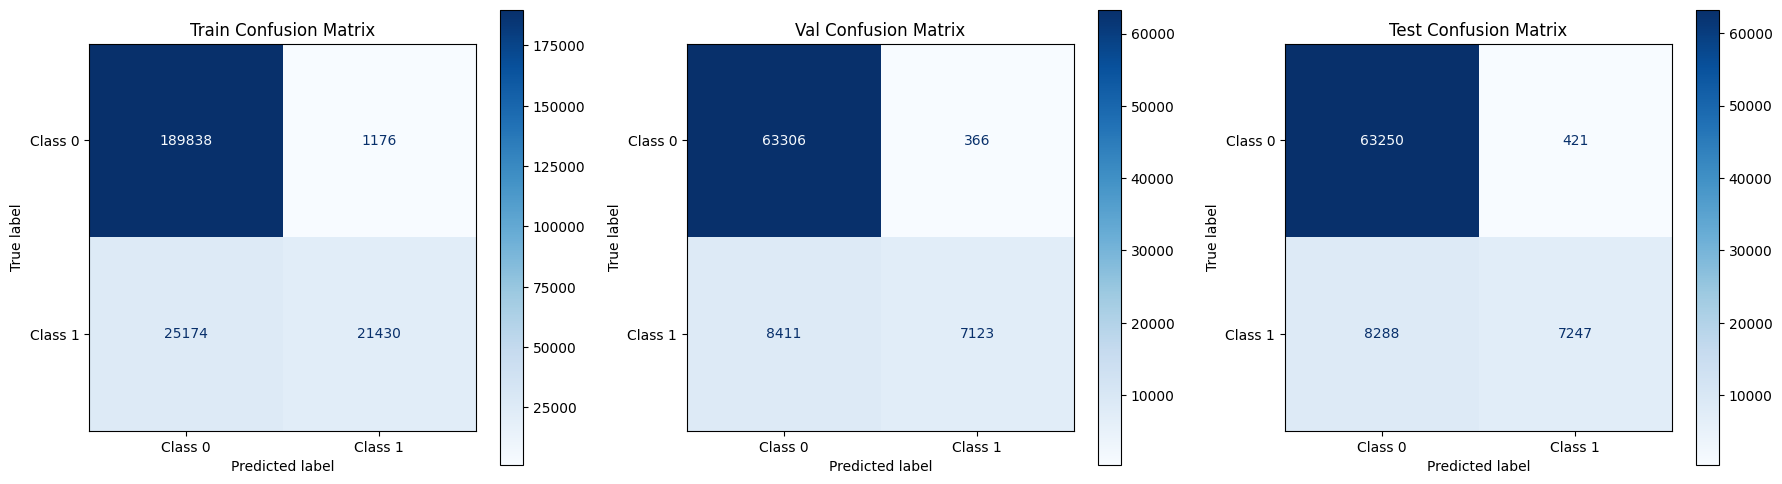

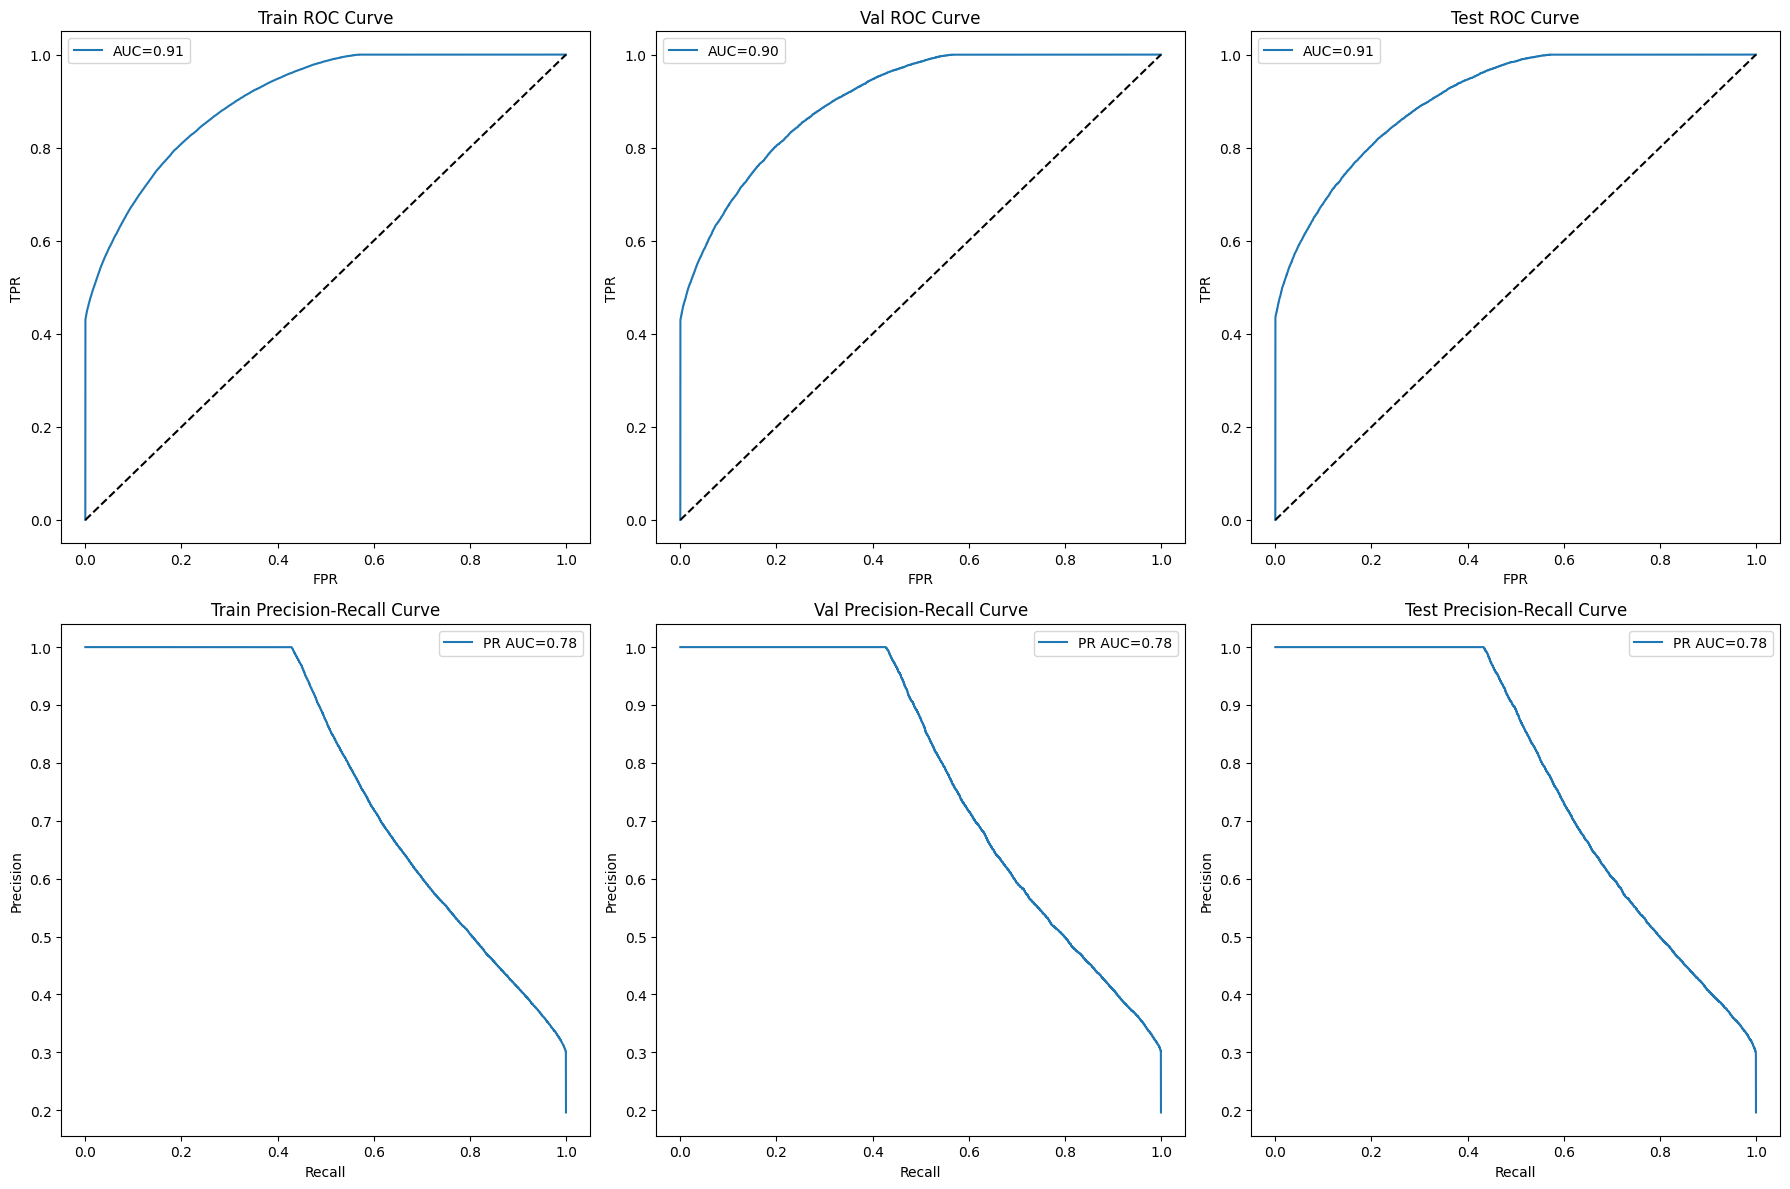

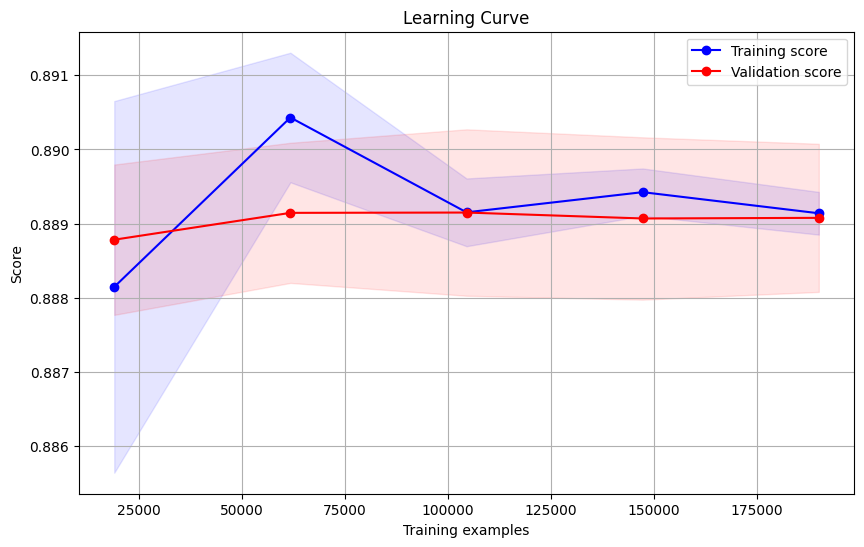

<Figure size 1200x800 with 0 Axes>

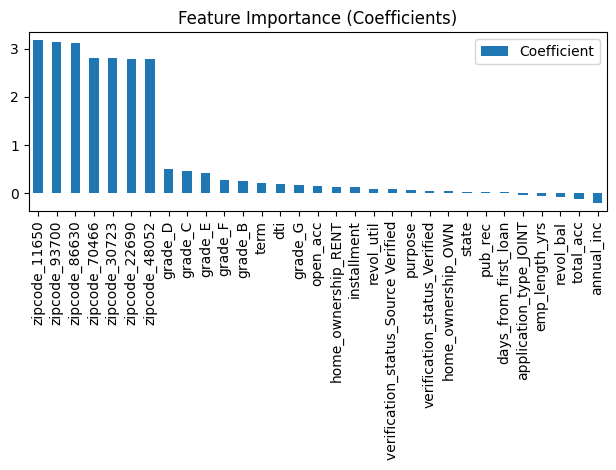


Model Intercept: -3.4376


2025/04/27 01:02:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



 MLFLOW Logging Completed.


In [136]:
feature_names = column_names

mlflow_logging_and_metric_printing(
    model=model,
    run_name="Imbalanced_simple_logistic_regression_before_thresholding",
    bal_type="Imbalanced",
    X_train=X_train, y_train=y_train, y_pred_train=y_pred_train,
    X_val=X_val, y_val=y_val, y_pred_val=y_pred_val,
    X_test=X_test, y_test=y_test, y_pred_test=y_pred_test,
    hyper_tuning_score=0,
    feature_names=feature_names
)

### After Thresholding

In [137]:
def find_best_threshold(y_true, y_pred_prob):
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_pred_prob)

    # Find where precision and recall are closest
    differences = np.abs(precisions - recalls)
    best_idx = np.argmin(differences)
    best_threshold = thresholds[best_idx]
    
    print(f"Best Threshold where Precision ≈ Recall: {best_threshold:.4f}")

    # Plot Precision-Recall vs Threshold
    threshold_boundary = thresholds.shape[0]  # Because precisions has 1 more element than thresholds

    plt.figure(figsize=(10,6))
    plt.plot(thresholds, precisions[:threshold_boundary], label="Precision", linestyle="--")
    plt.plot(thresholds, recalls[:threshold_boundary], label="Recall")
    plt.axvline(x=best_threshold, color='green', linestyle='--', label=f'Best Threshold = {best_threshold:.2f}')
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.title("Precision and Recall vs Threshold")
    plt.legend(loc='best')
    plt.grid()
    plt.show()

    return best_threshold


Best Threshold where Precision ≈ Recall: 0.2970


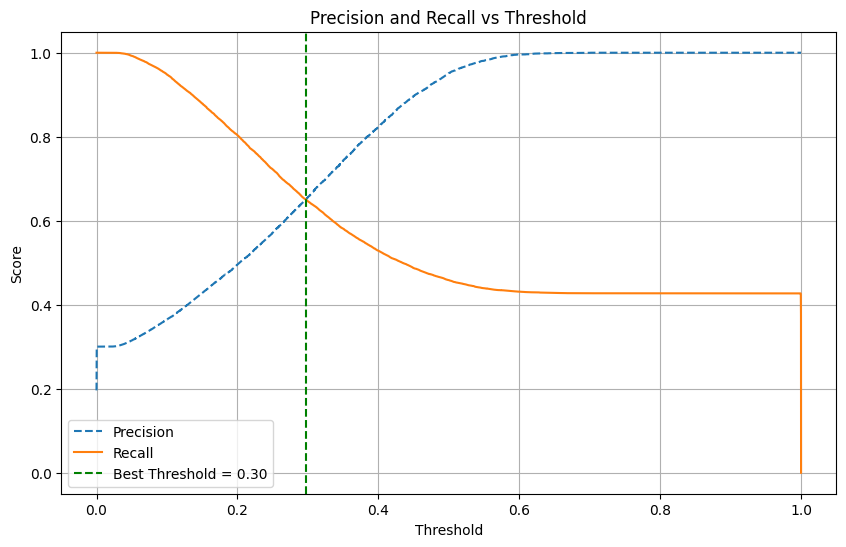

In [138]:
# 2. Predict probabilities
y_pred_proba_train = model.predict_proba(X_train)[:, 1]
y_pred_proba_val = model.predict_proba(X_val)[:, 1]
y_pred_proba_test = model.predict_proba(X_test)[:, 1]
# 3. Find Best Threshold
best_threshold = find_best_threshold(y_val, y_pred_proba_val)

In [139]:
# After threshold tuning outside
y_pred_train = (y_pred_proba_train >= best_threshold).astype(int)
y_pred_val = (y_pred_proba_val >= best_threshold).astype(int)
y_pred_test = (y_pred_proba_test >= best_threshold).astype(int)


Train Metrics:
  Accuracy_train: 0.8633
  Precision_train: 0.6498
  Recall_train: 0.6572
  F1_score_train: 0.6535
  F2_score_train: 0.6557
  Roc_auc_train: 0.9063
  Pr_auc_train: 0.7782

Train Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.91      0.91    191014
           1       0.65      0.66      0.65     46604

    accuracy                           0.86    237618
   macro avg       0.78      0.79      0.78    237618
weighted avg       0.86      0.86      0.86    237618


Val Metrics:
  Accuracy_val: 0.8630
  Precision_val: 0.6508
  Recall_val: 0.6508
  F1_score_val: 0.6508
  F2_score_val: 0.6508
  Roc_auc_val: 0.9049
  Pr_auc_val: 0.7760

Val Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91     63672
           1       0.65      0.65      0.65     15534

    accuracy                           0.86     79206
   macro avg       0.78      0.78      

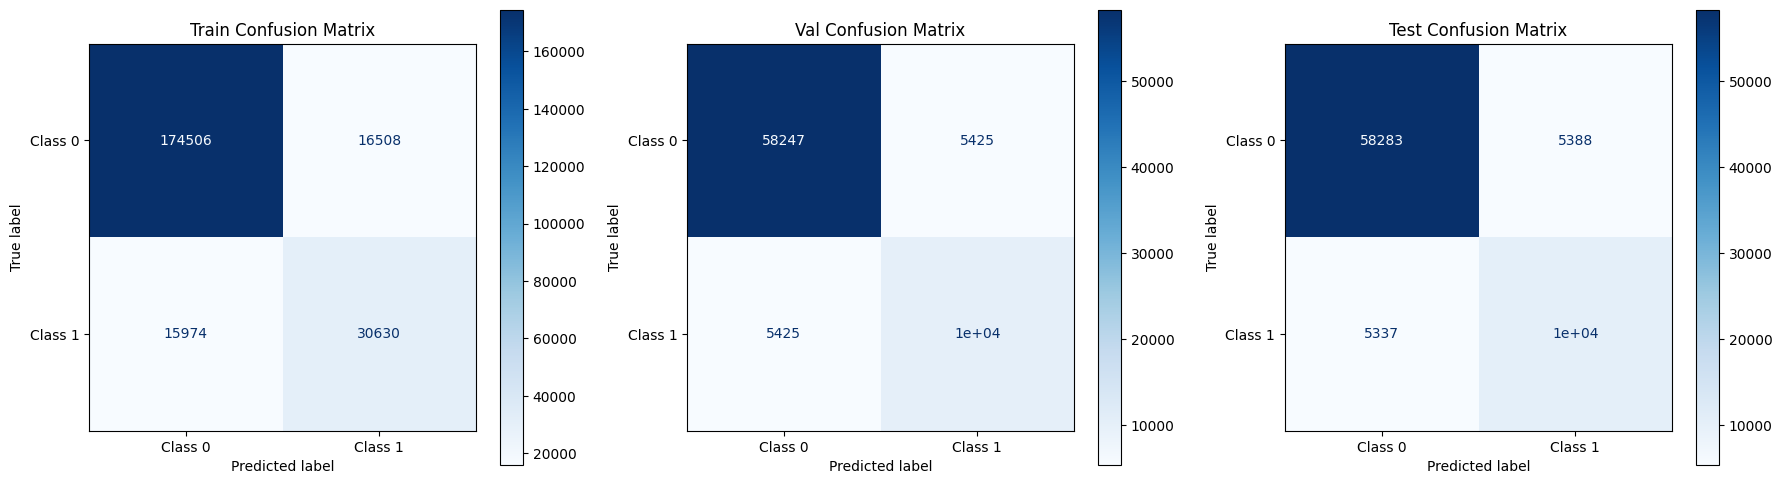

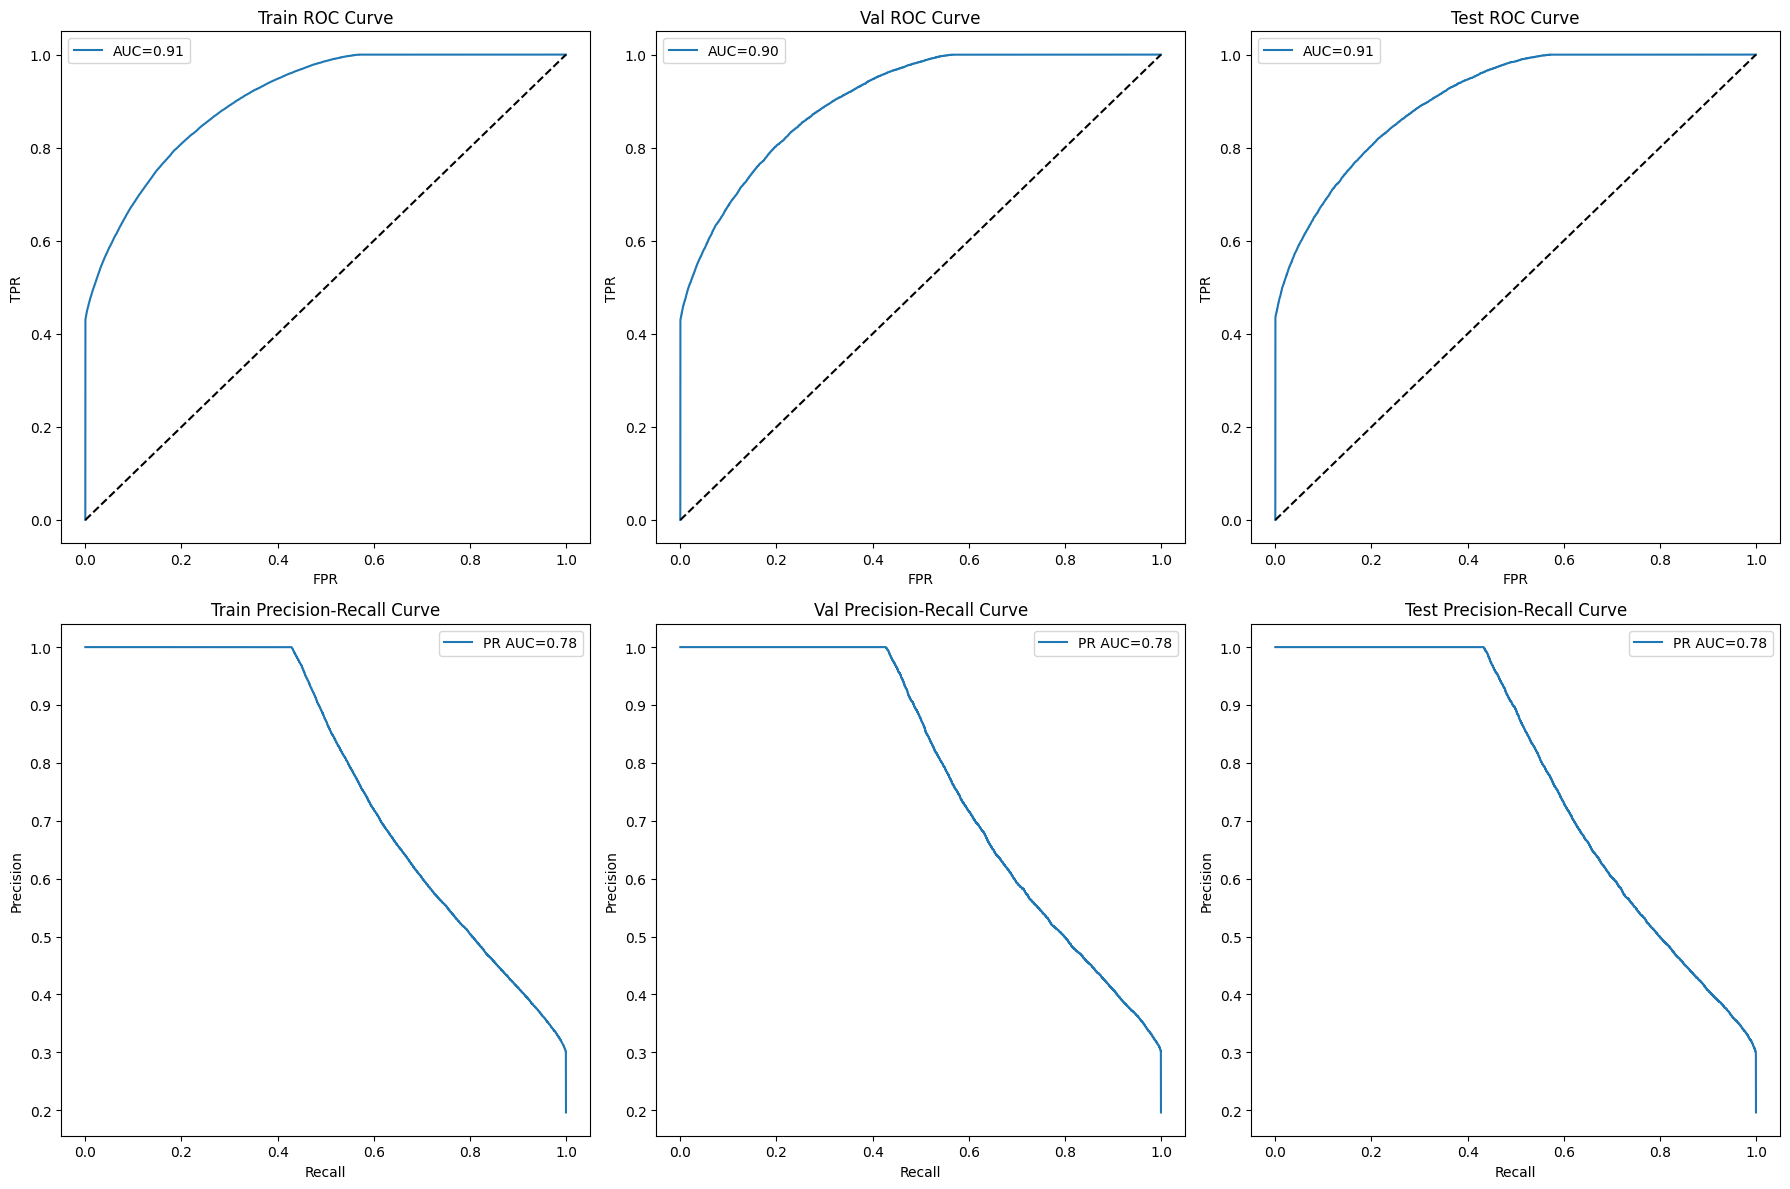

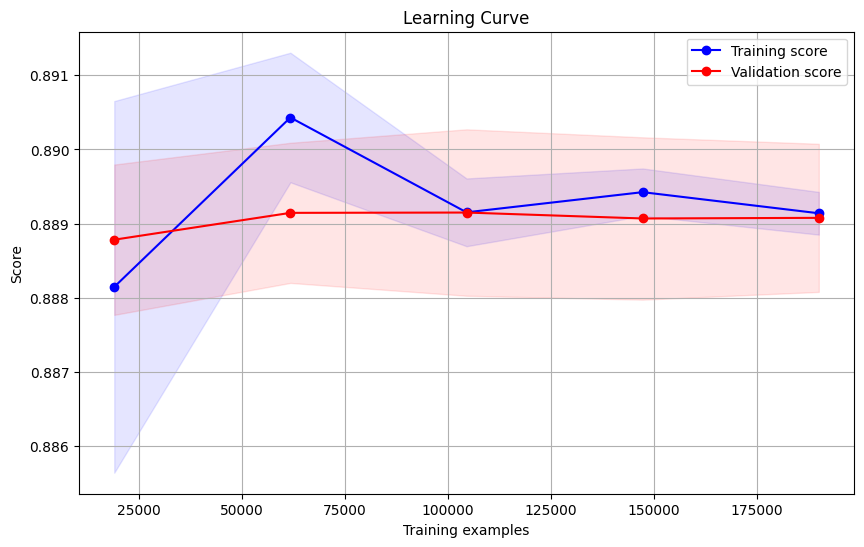

<Figure size 1200x800 with 0 Axes>

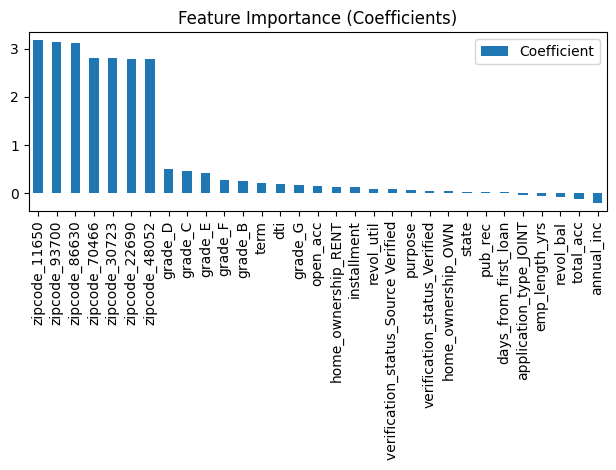


Model Intercept: -3.4376


2025/04/27 01:02:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



 MLFLOW Logging Completed.


In [140]:
mlflow_logging_and_metric_printing(
    model=model,
    run_name="Imbalanced_simple_logistic_regression_after_thresholding",
    bal_type="Imbalanced",
    X_train=X_train, y_train=y_train, y_pred_train=y_pred_train,
    X_val=X_val, y_val=y_val, y_pred_val=y_pred_val,
    X_test=X_test, y_test=y_test, y_pred_test=y_pred_test,
    hyper_tuning_score=0,
    feature_names=feature_names,
    best_threshold=best_threshold
)

## Simple Logistic Regression on Balanced Data

### Before Thresholding

In [141]:
model = LogisticRegression()
model.fit(X_smote,y_smote)

LogisticRegression()

In [142]:
y_pred_smote = model.predict(X_smote)
y_pred_val_smote = model.predict(X_val)
y_pred_test_smote = model.predict(X_test)


Train Metrics:
  Accuracy_train: 0.8633
  Precision_train: 0.6498
  Recall_train: 0.6572
  F1_score_train: 0.6535
  F2_score_train: 0.6557
  Roc_auc_train: 0.9060
  Pr_auc_train: 0.7777

Train Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.91      0.91    191014
           1       0.65      0.66      0.65     46604

    accuracy                           0.86    237618
   macro avg       0.78      0.79      0.78    237618
weighted avg       0.86      0.86      0.86    237618


Val Metrics:
  Accuracy_val: 0.8630
  Precision_val: 0.6508
  Recall_val: 0.6508
  F1_score_val: 0.6508
  F2_score_val: 0.6508
  Roc_auc_val: 0.9046
  Pr_auc_val: 0.7754

Val Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91     63672
           1       0.65      0.65      0.65     15534

    accuracy                           0.86     79206
   macro avg       0.78      0.78      

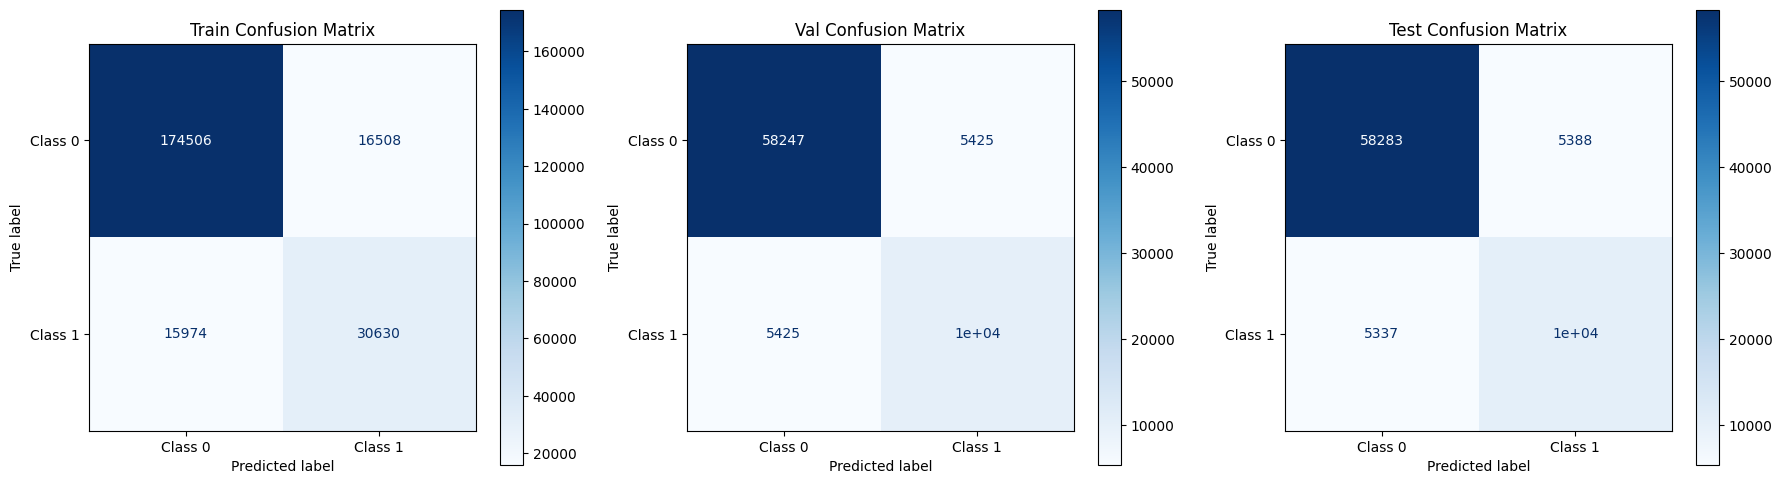

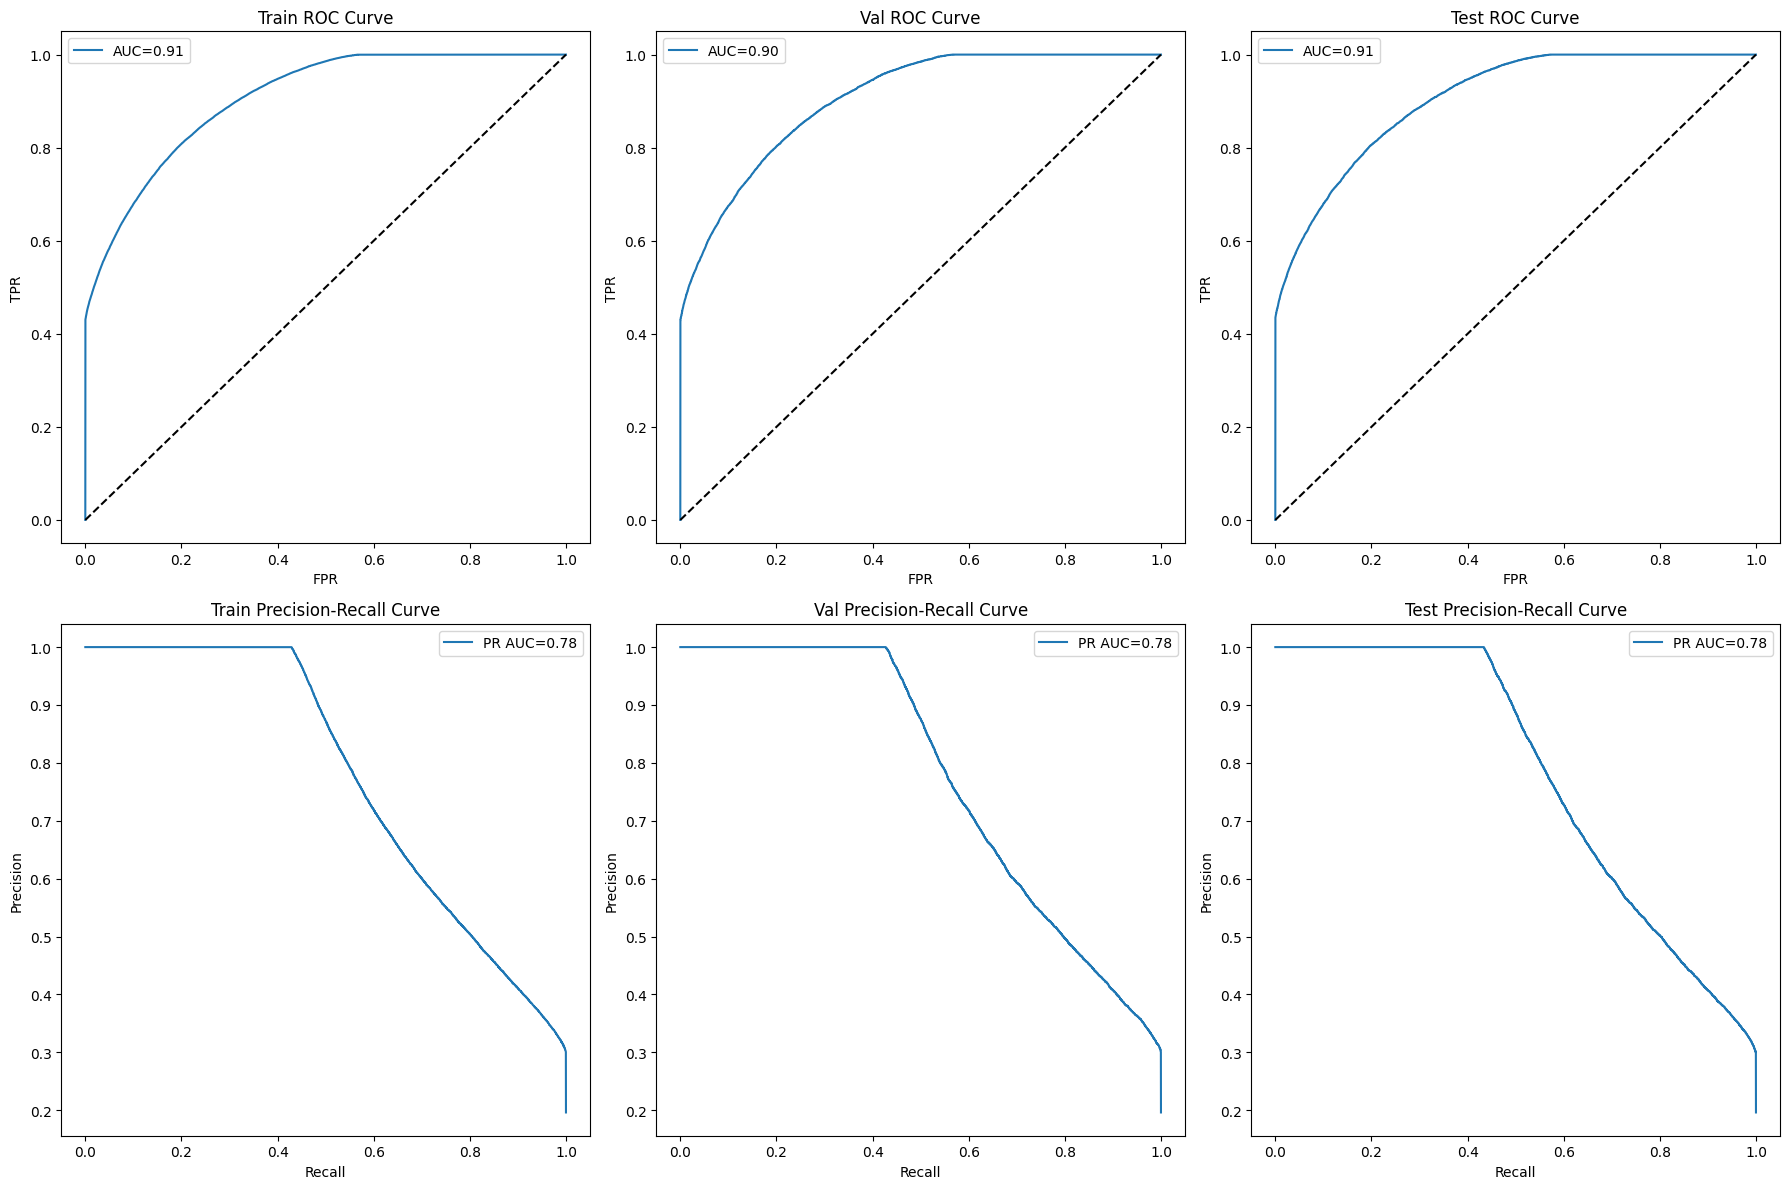

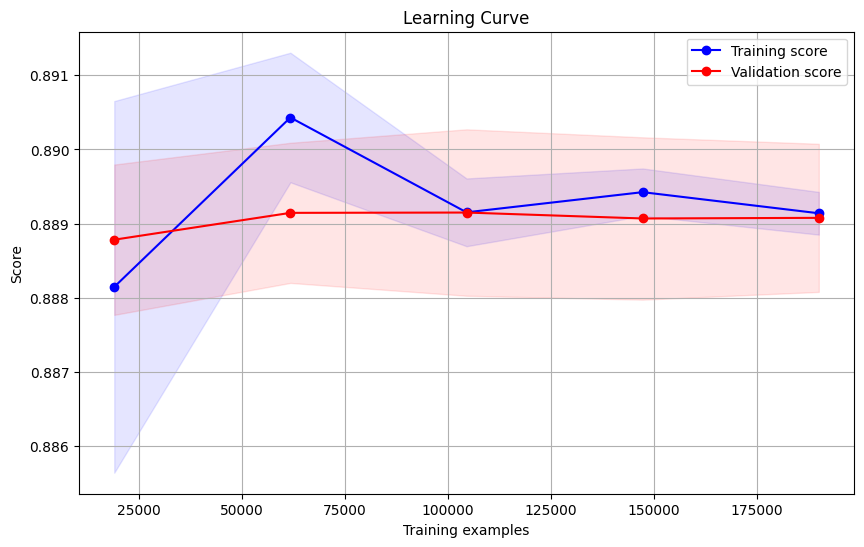

<Figure size 1200x800 with 0 Axes>

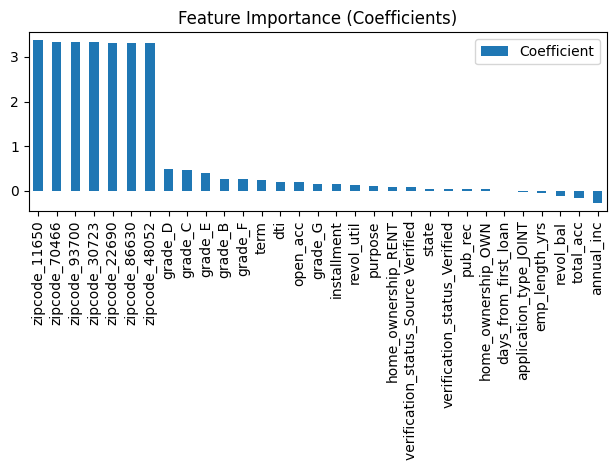


Model Intercept: -2.6004


2025/04/27 01:02:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



 MLFLOW Logging Completed.


In [143]:
feature_names = column_names

mlflow_logging_and_metric_printing(
    model=model,
    run_name="Balanced_simple_logistic_regression_before_thresholding",
    bal_type="Balanced_Smote",
    X_train=X_train, y_train=y_train, y_pred_train=y_pred_train,
    X_val=X_val, y_val=y_val, y_pred_val=y_pred_val,
    X_test=X_test, y_test=y_test, y_pred_test=y_pred_test,
    hyper_tuning_score=0,
    feature_names=feature_names
)

### after thresholding

Best Threshold where Precision ≈ Recall: 0.6368


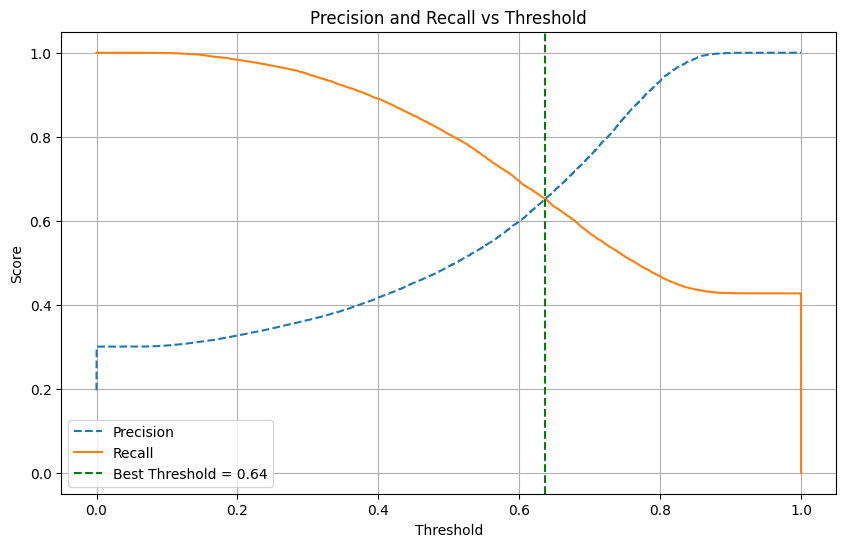

In [144]:
# 2. Predict probabilities
y_pred_proba_smote = model.predict_proba(X_smote)[:, 1]
y_pred_proba_val = model.predict_proba(X_val)[:, 1]
y_pred_proba_test = model.predict_proba(X_test)[:, 1]
# 3. Find Best Threshold
best_threshold = find_best_threshold(y_val, y_pred_proba_val)

In [145]:
# After threshold tuning outside
y_pred_smote = (y_pred_proba_smote >= best_threshold).astype(int)
y_pred_val = (y_pred_proba_val >= best_threshold).astype(int)
y_pred_test = (y_pred_proba_test >= best_threshold).astype(int)


Train Metrics:
  Accuracy_train: 0.8633
  Precision_train: 0.6498
  Recall_train: 0.6572
  F1_score_train: 0.6535
  F2_score_train: 0.6557
  Roc_auc_train: 0.9060
  Pr_auc_train: 0.7777

Train Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.91      0.91    191014
           1       0.65      0.66      0.65     46604

    accuracy                           0.86    237618
   macro avg       0.78      0.79      0.78    237618
weighted avg       0.86      0.86      0.86    237618


Val Metrics:
  Accuracy_val: 0.8634
  Precision_val: 0.6519
  Recall_val: 0.6519
  F1_score_val: 0.6519
  F2_score_val: 0.6519
  Roc_auc_val: 0.9046
  Pr_auc_val: 0.7754

Val Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92     63672
           1       0.65      0.65      0.65     15534

    accuracy                           0.86     79206
   macro avg       0.78      0.78      

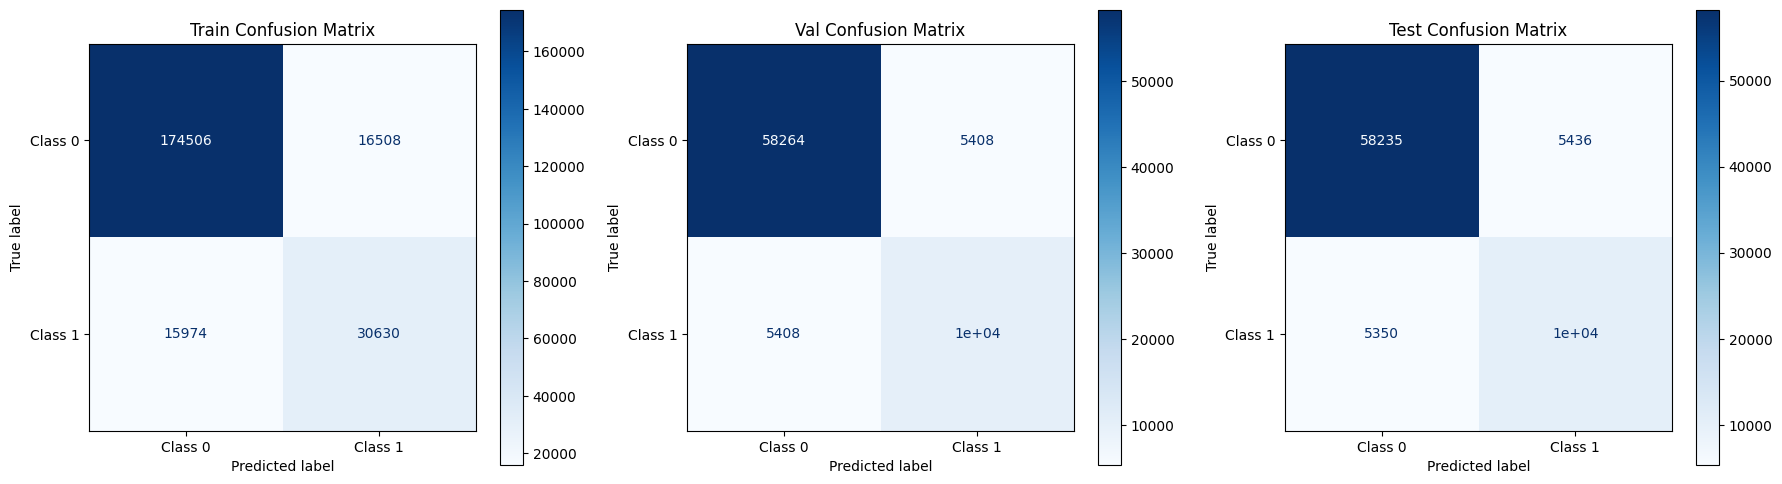

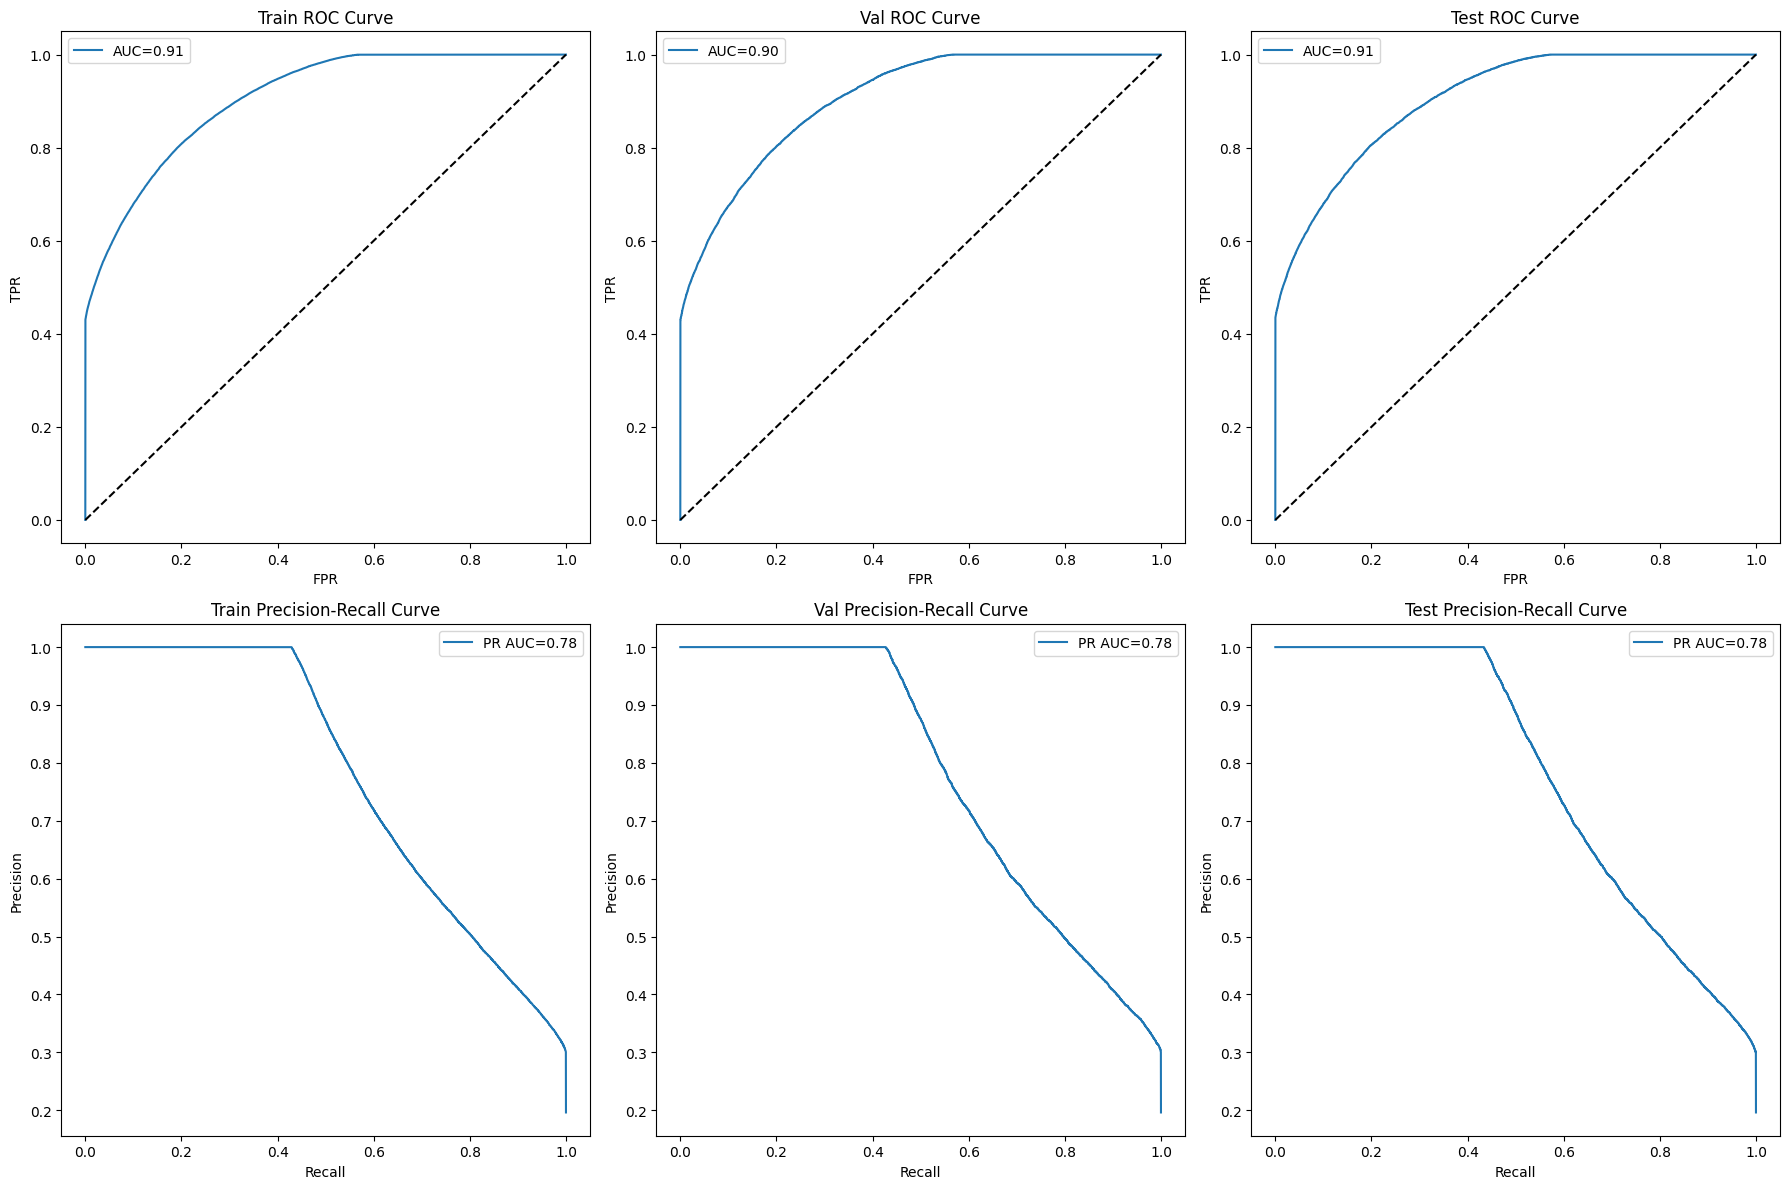

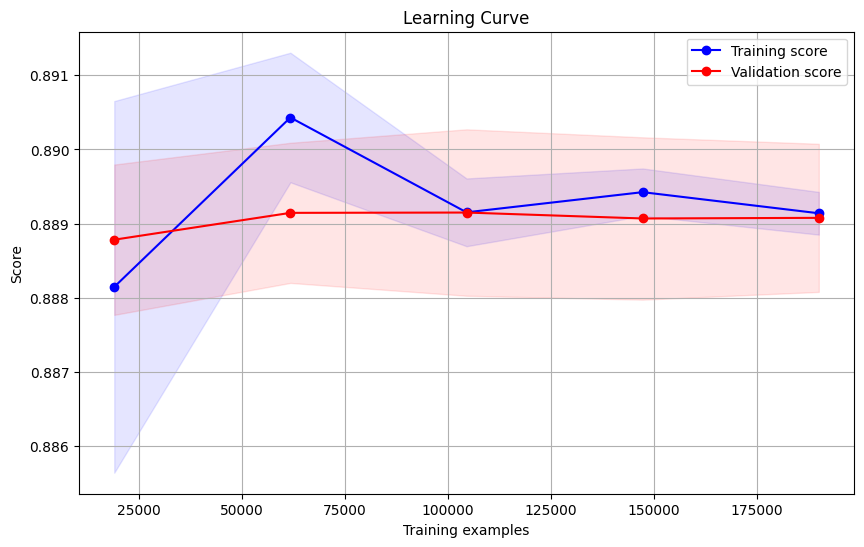

<Figure size 1200x800 with 0 Axes>

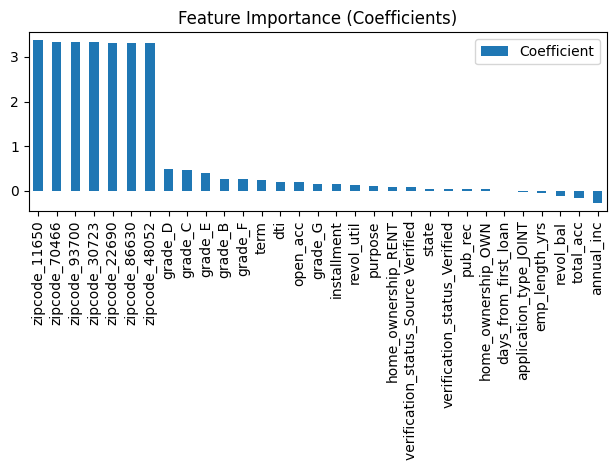


Model Intercept: -2.6004


2025/04/27 01:02:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



 MLFLOW Logging Completed.


In [146]:
feature_names = column_names

mlflow_logging_and_metric_printing(
    model=model,
    run_name="Balanced_simple_logistic_regression_after_thresholding",
    bal_type="Balanced_smote",
    X_train=X_train, y_train=y_train, y_pred_train=y_pred_train,
    X_val=X_val, y_val=y_val, y_pred_val=y_pred_val,
    X_test=X_test, y_test=y_test, y_pred_test=y_pred_test,
    hyper_tuning_score=0,
    feature_names=feature_names,
    best_threshold=best_threshold
)

# Hyperparameter Tuning for Lambda.

## Hyperparamter Tuning on Imbalanced data

In [147]:
train_scores = []
val_scores = []
for la in np.arange(0.01, 5000.0, 100): # range of values of Lambda
  model = LogisticRegression(C=1/la,class_weight="balanced")
  model.fit(X_train, y_train)
  train_score = accuracy_score(y_train, model.predict(X_train))
  val_score = accuracy_score(y_val, model.predict(X_val))
  train_scores.append(train_score)
  val_scores.append(val_score)

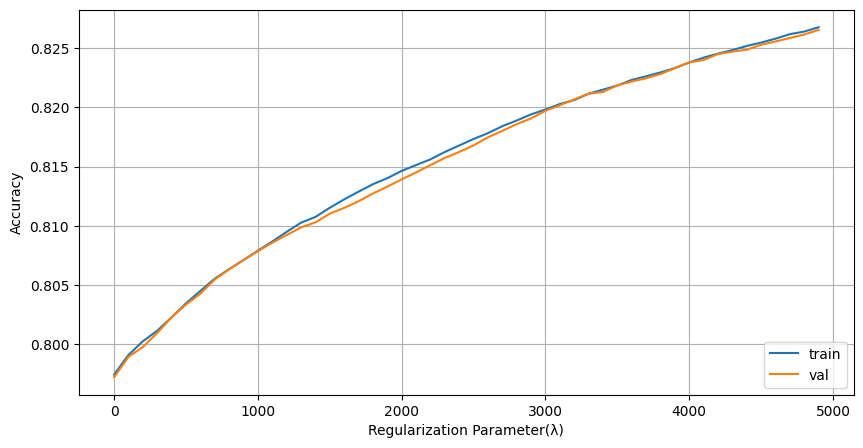

In [148]:
plt.figure(figsize=(10,5))
plt.plot(list(np.arange(0.01, 5000.0, 100)), train_scores, label="train")
plt.plot(list(np.arange(0.01, 5000.0, 100)), val_scores, label="val")
plt.legend(loc='lower right')
plt.xlabel("Regularization Parameter(λ)")
plt.ylabel("Accuracy")
plt.grid()
plt.show()

In [149]:
# Find best lambda
lambdas = np.arange(0.01, 5000.0, 100)
best_lambda_index = np.argmax(val_scores)
best_lambda = lambdas[best_lambda_index]
best_val_score = val_scores[best_lambda_index]

print(f"Best Lambda (λ): {best_lambda}")
print(f"Best Validation Accuracy: {best_val_score:.4f}")


Best Lambda (λ): 4900.01
Best Validation Accuracy: 0.8265


## Regularised Logistic Regression - Imbalanced Data

In [150]:
model = LogisticRegression(C=1/4900,class_weight="balanced")
model.fit(X_train,y_train)

LogisticRegression(C=0.00020408163265306123, class_weight='balanced')

In [151]:
y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_val)
y_pred_test = model.predict(X_test)


Train Metrics:
  Accuracy_train: 0.8268
  Precision_train: 0.5417
  Recall_train: 0.7593
  F1_score_train: 0.6323
  F2_score_train: 0.7028
  Roc_auc_train: 0.9043
  Pr_auc_train: 0.7769

Train Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.84      0.89    191014
           1       0.54      0.76      0.63     46604

    accuracy                           0.83    237618
   macro avg       0.74      0.80      0.76    237618
weighted avg       0.86      0.83      0.84    237618


Val Metrics:
  Accuracy_val: 0.8265
  Precision_val: 0.5415
  Recall_val: 0.7534
  F1_score_val: 0.6301
  F2_score_val: 0.6987
  Roc_auc_val: 0.9029
  Pr_auc_val: 0.7748

Val Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.84      0.89     63672
           1       0.54      0.75      0.63     15534

    accuracy                           0.83     79206
   macro avg       0.74      0.80      

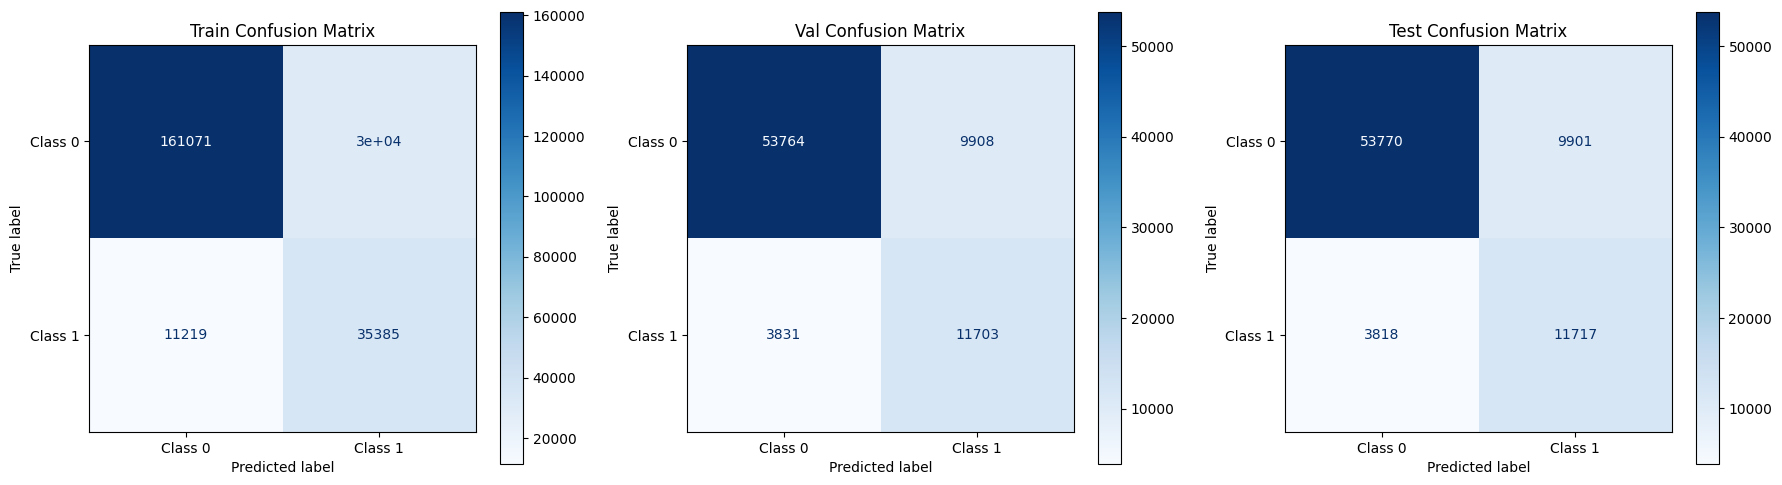

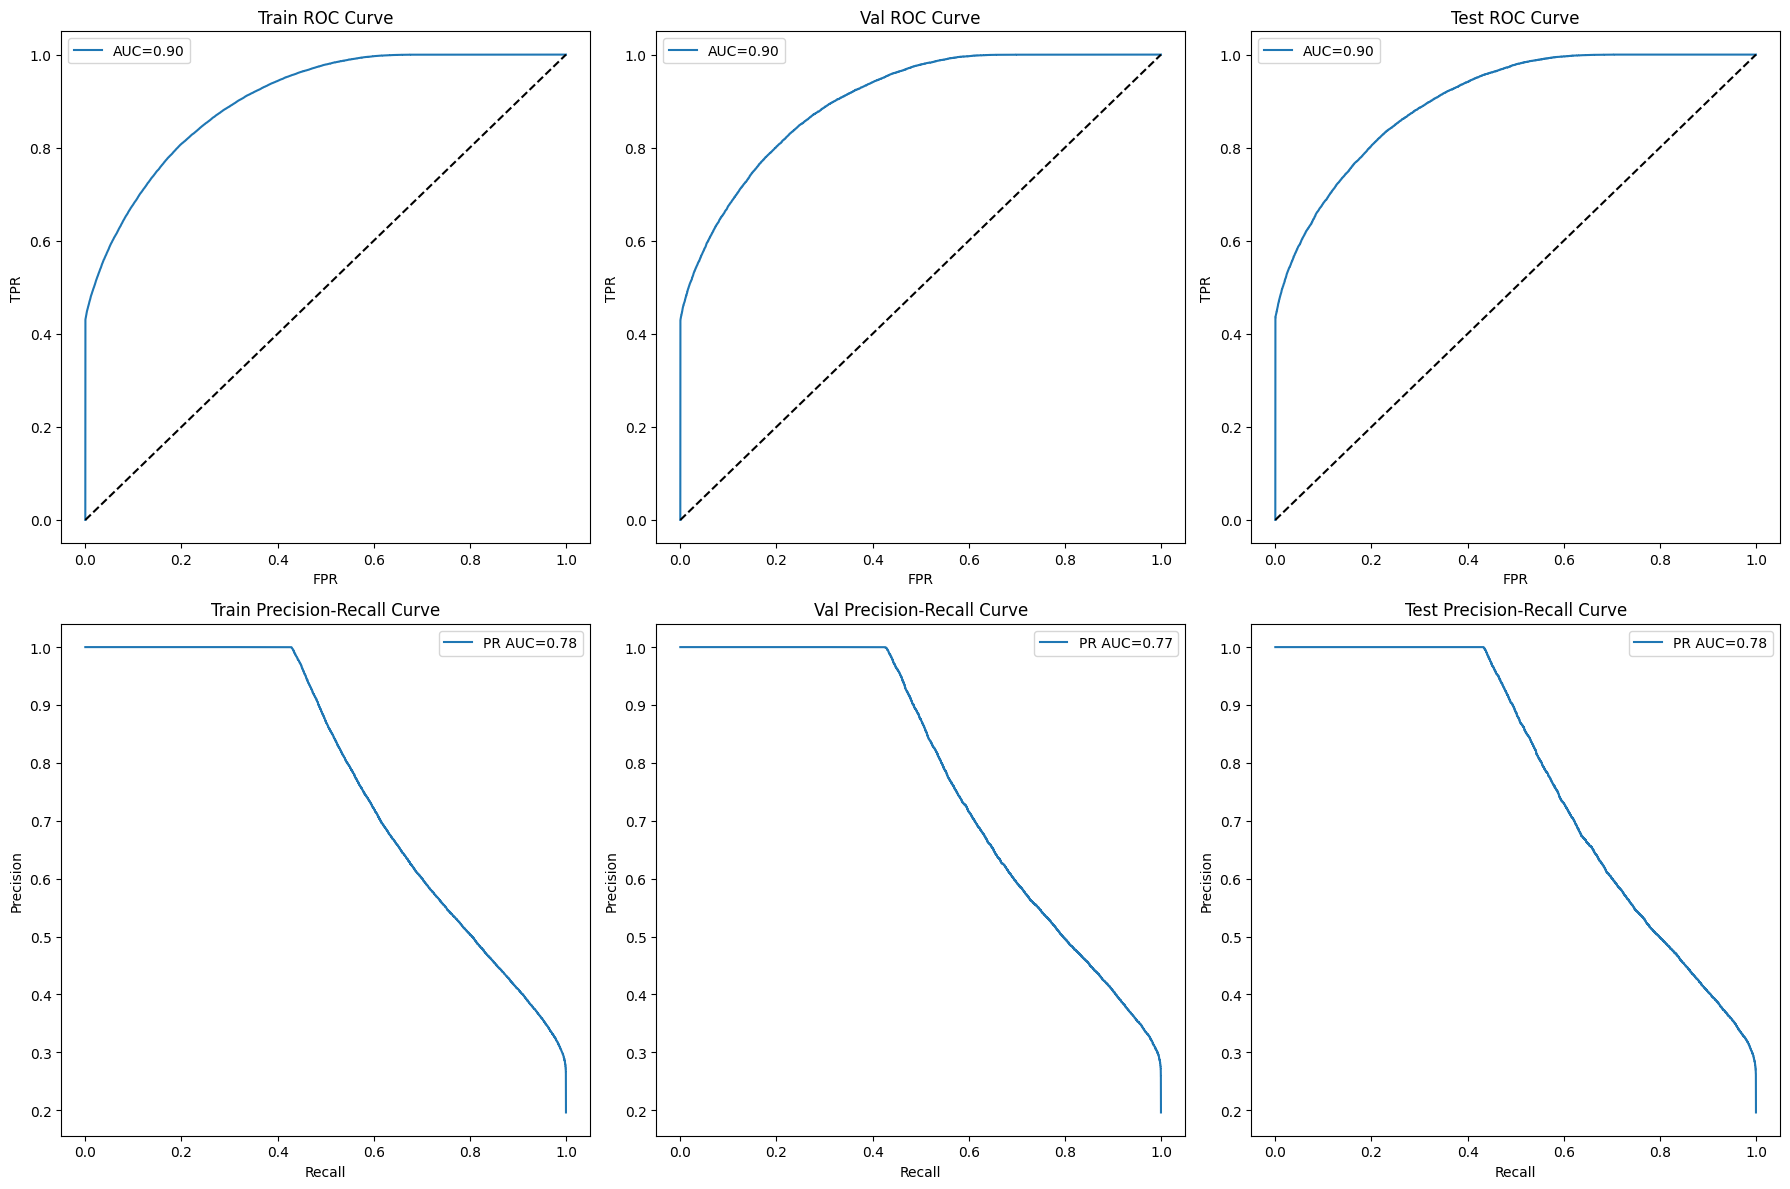

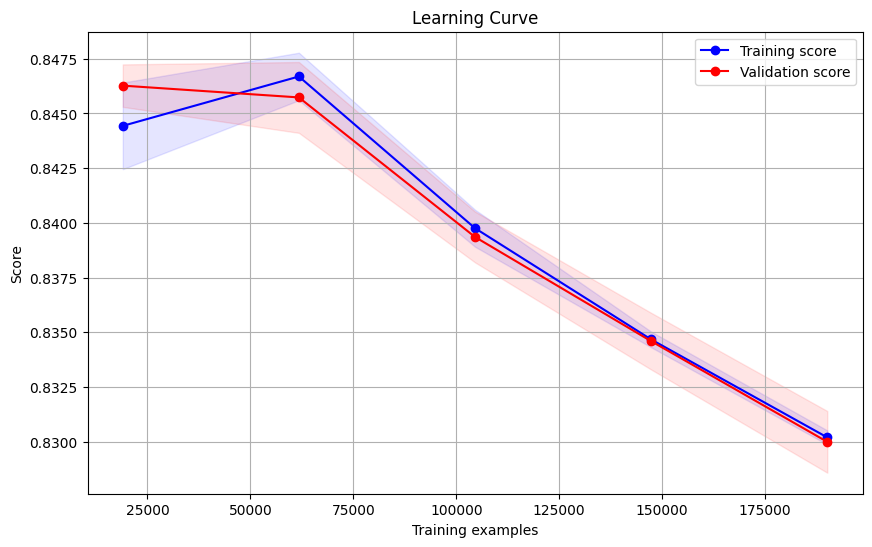

<Figure size 1200x800 with 0 Axes>

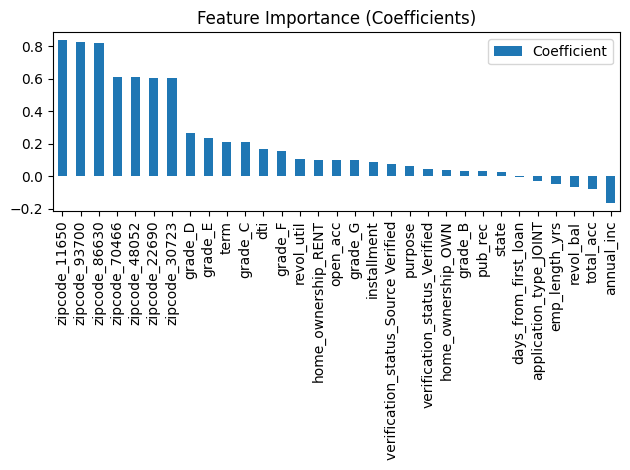


Model Intercept: -0.6082


2025/04/27 01:02:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



 MLFLOW Logging Completed.


In [152]:
feature_names = column_names

mlflow_logging_and_metric_printing(
    model=model,
    run_name="Imbalanced_Regularized_logistic_regression_before_thresholding",
    bal_type="Imbalanced",
    X_train=X_train, y_train=y_train, y_pred_train=y_pred_train,
    X_val=X_val, y_val=y_val, y_pred_val=y_pred_val,
    X_test=X_test, y_test=y_test, y_pred_test=y_pred_test,
    hyper_tuning_score=0,
    feature_names=feature_names,
    best_lambda=best_lambda
)

Best Threshold where Precision ≈ Recall: 0.5746


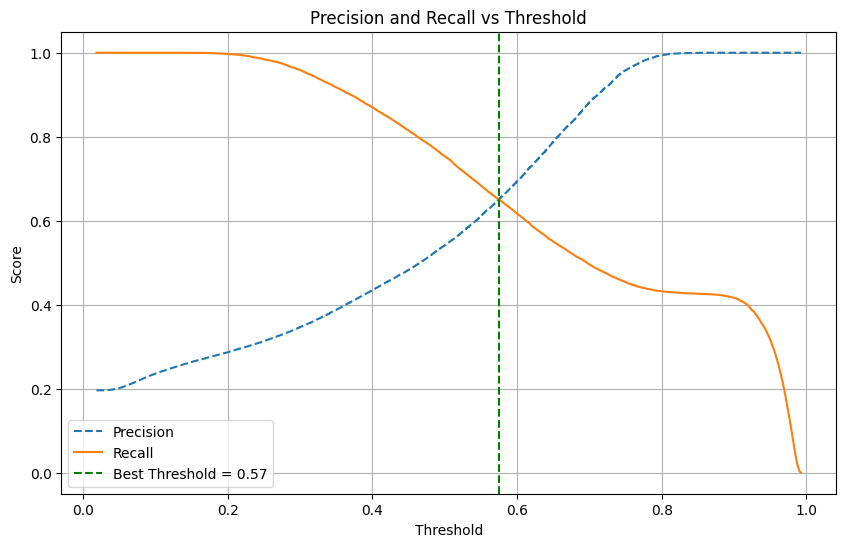

In [153]:
# 2. Predict probabilities
y_pred_proba_train = model.predict_proba(X_train)[:, 1]
y_pred_proba_val = model.predict_proba(X_val)[:, 1]
y_pred_proba_test = model.predict_proba(X_test)[:, 1]
# 3. Find Best Threshold
best_threshold = find_best_threshold(y_val, y_pred_proba_val)

In [154]:
# After threshold tuning outside
y_pred_train = (y_pred_proba_train >= best_threshold).astype(int)
y_pred_val = (y_pred_proba_val >= best_threshold).astype(int)
y_pred_test = (y_pred_proba_test >= best_threshold).astype(int)

In [155]:
# 4. Apply threshold to create final predictions
y_pred_train = (y_pred_proba_train >= best_threshold).astype(int)
y_pred_val = (y_pred_proba_val >= best_threshold).astype(int)
y_pred_test = (y_pred_proba_test >= best_threshold).astype(int)


Train Metrics:
  Accuracy_train: 0.8631
  Precision_train: 0.6495
  Recall_train: 0.6561
  F1_score_train: 0.6528
  F2_score_train: 0.6548
  Roc_auc_train: 0.9043
  Pr_auc_train: 0.7769

Train Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.91      0.91    191014
           1       0.65      0.66      0.65     46604

    accuracy                           0.86    237618
   macro avg       0.78      0.78      0.78    237618
weighted avg       0.86      0.86      0.86    237618


Val Metrics:
  Accuracy_val: 0.8631
  Precision_val: 0.6510
  Recall_val: 0.6510
  F1_score_val: 0.6510
  F2_score_val: 0.6510
  Roc_auc_val: 0.9029
  Pr_auc_val: 0.7748

Val Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91     63672
           1       0.65      0.65      0.65     15534

    accuracy                           0.86     79206
   macro avg       0.78      0.78      

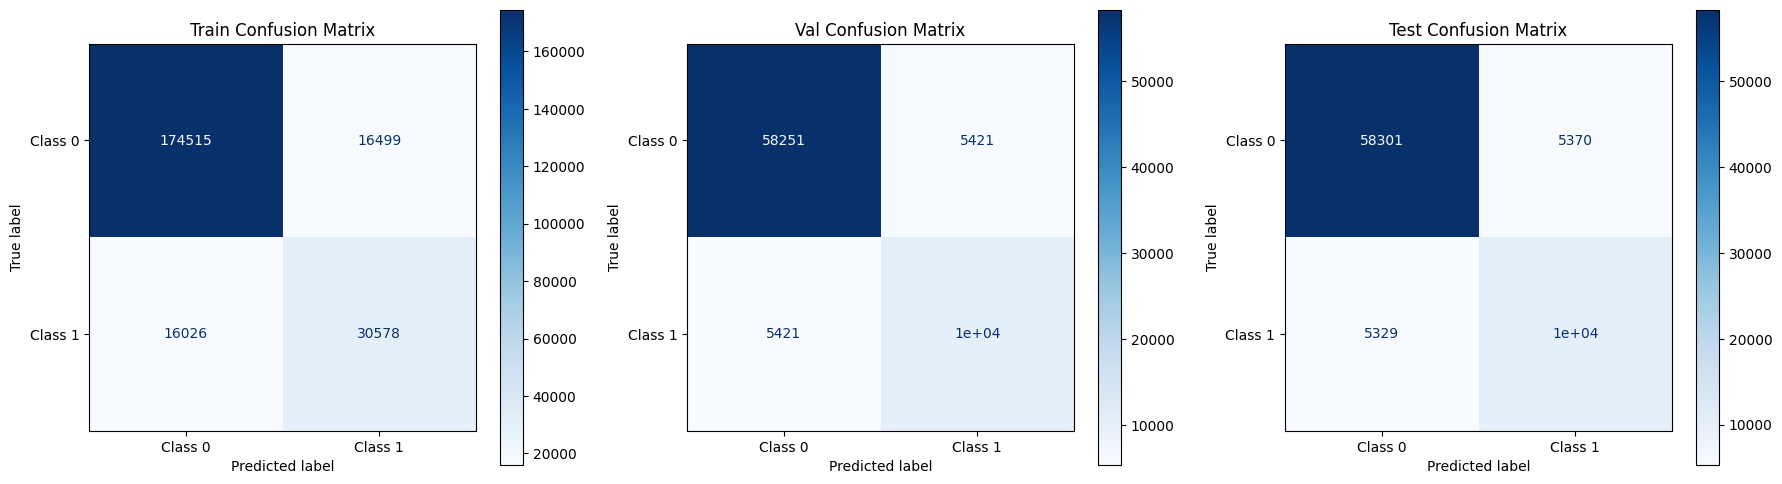

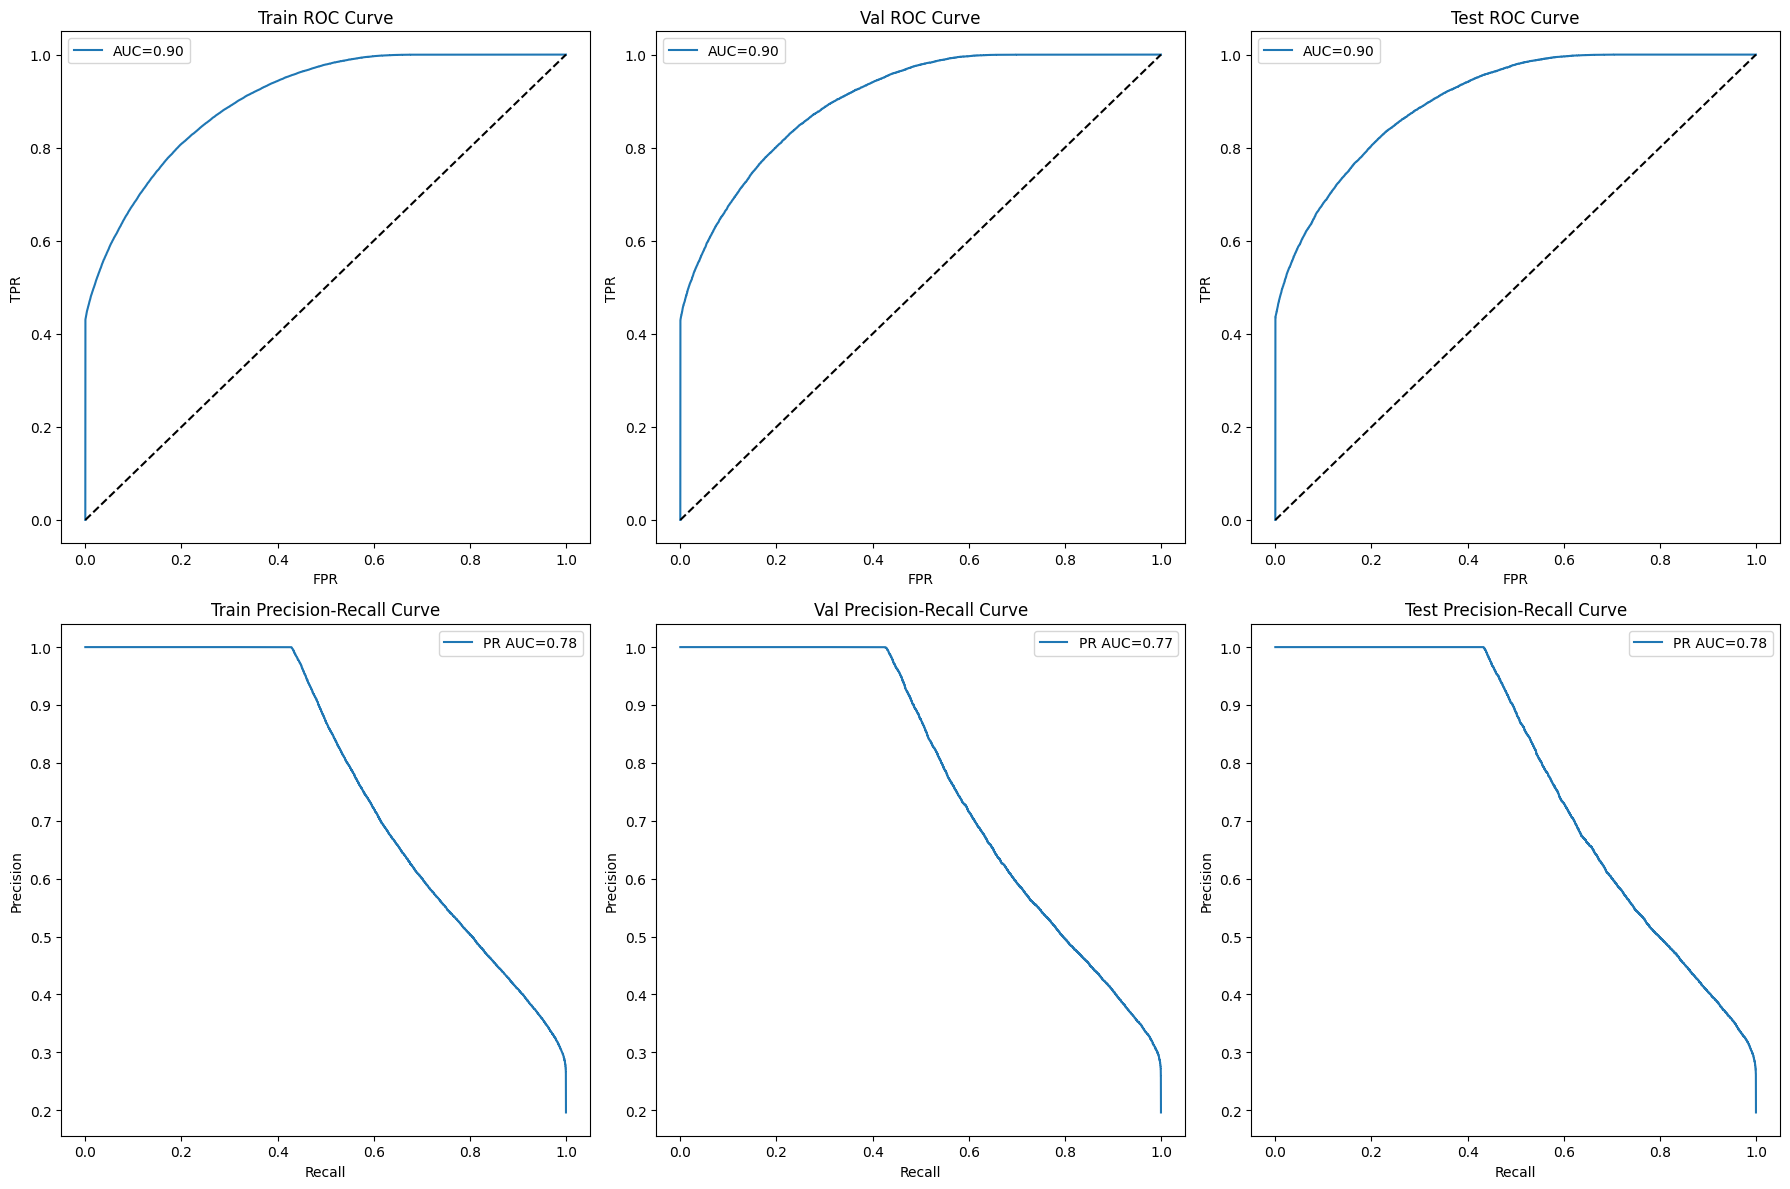

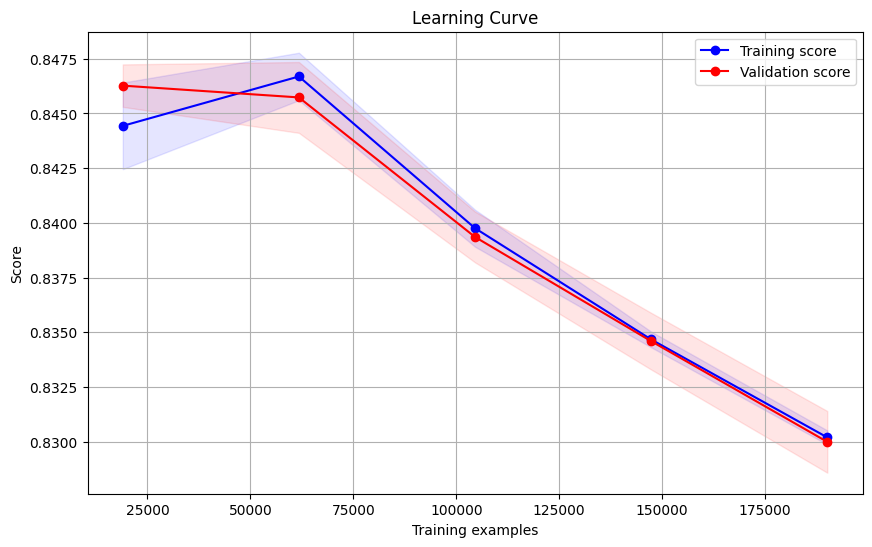

<Figure size 1200x800 with 0 Axes>

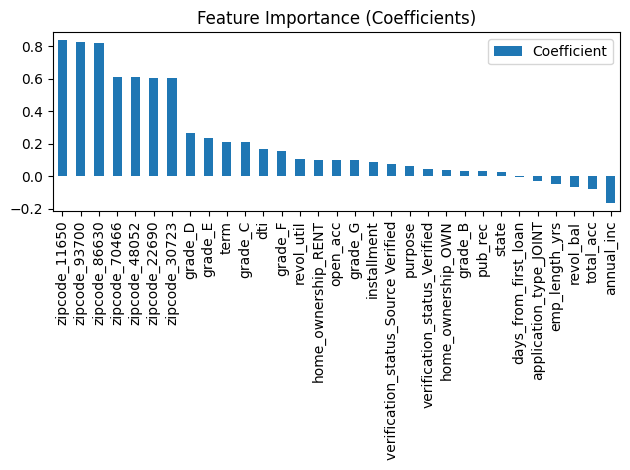


Model Intercept: -0.6082


2025/04/27 01:03:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



 MLFLOW Logging Completed.


In [156]:
mlflow_logging_and_metric_printing(
    model=model,
    run_name="Imbalanced_Regularized_logistic_regression_after_thresholding",
    bal_type="Imbalanced",
    X_train=X_train, y_train=y_train, y_pred_train=y_pred_train,
    X_val=X_val, y_val=y_val, y_pred_val=y_pred_val,
    X_test=X_test, y_test=y_test, y_pred_test=y_pred_test,
    hyper_tuning_score=0,
    feature_names=feature_names,
    best_threshold=best_threshold,
    best_lambda=best_lambda
)

## Hyperparamter Tuning on Balanced data

In [157]:
smote_scores = []
val_scores = []
for la in np.arange(0.01, 5000.0, 100): # range of values of Lambda
  model = LogisticRegression(C=1/la,class_weight="balanced")
  model.fit(X_smote, y_smote)
  smote_score = accuracy_score(y_smote, model.predict(X_smote))
  val_score = accuracy_score(y_val, model.predict(X_val))
  smote_scores.append(smote_score)
  val_scores.append(val_score)

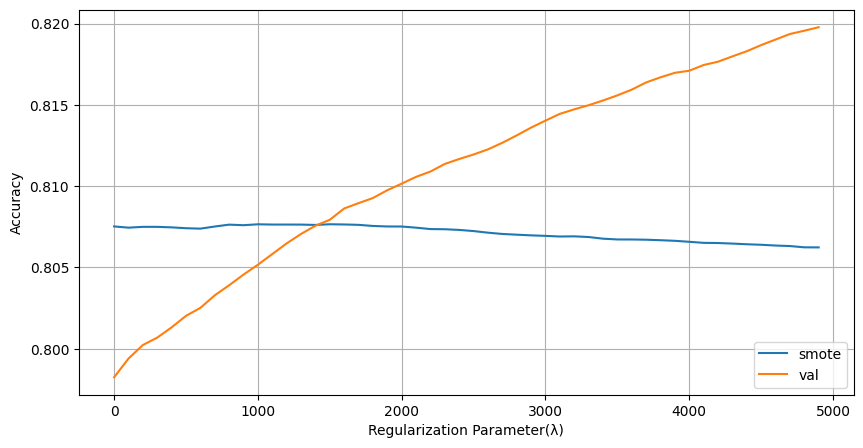

In [158]:

plt.figure(figsize=(10,5))
plt.plot(list(np.arange(0.01, 5000.0, 100)), smote_scores, label="smote")
plt.plot(list(np.arange(0.01, 5000.0, 100)), val_scores, label="val")
plt.legend(loc='lower right')
plt.xlabel("Regularization Parameter(λ)")
plt.ylabel("Accuracy")
plt.grid()
plt.show()

In [159]:
# Find best lambda
lambdas = np.arange(0.01, 5000.0, 100)
best_lambda_index = np.argmax(val_scores)
best_lambda = lambdas[best_lambda_index]
best_val_score = val_scores[best_lambda_index]

print(f"Best Lambda (λ): {best_lambda}")
print(f"Best Validation Accuracy: {best_val_score:.4f}")

Best Lambda (λ): 4900.01
Best Validation Accuracy: 0.8198


## Simple Logistic Regression on Balanced Data

### Before thresholding

In [160]:
model = LogisticRegression(C=1/4900,class_weight="balanced")
model.fit(X_smote,y_smote)

LogisticRegression(C=0.00020408163265306123, class_weight='balanced')

In [161]:
y_pred_smote = model.predict(X_smote)
y_pred_val_smote = model.predict(X_val)
y_pred_test_smote = model.predict(X_test)


Train Metrics:
  Accuracy_train: 0.8062
  Precision_train: 0.8228
  Recall_train: 0.7806
  F1_score_train: 0.8011
  F2_score_train: 0.7887
  Roc_auc_train: 0.9079
  Pr_auc_train: 0.9139

Train Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.83      0.81    191014
           1       0.82      0.78      0.80    191014

    accuracy                           0.81    382028
   macro avg       0.81      0.81      0.81    382028
weighted avg       0.81      0.81      0.81    382028


Val Metrics:
  Accuracy_val: 0.8631
  Precision_val: 0.6510
  Recall_val: 0.6510
  F1_score_val: 0.6510
  F2_score_val: 0.6510
  Roc_auc_val: 0.9034
  Pr_auc_val: 0.7747

Val Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91     63672
           1       0.65      0.65      0.65     15534

    accuracy                           0.86     79206
   macro avg       0.78      0.78      

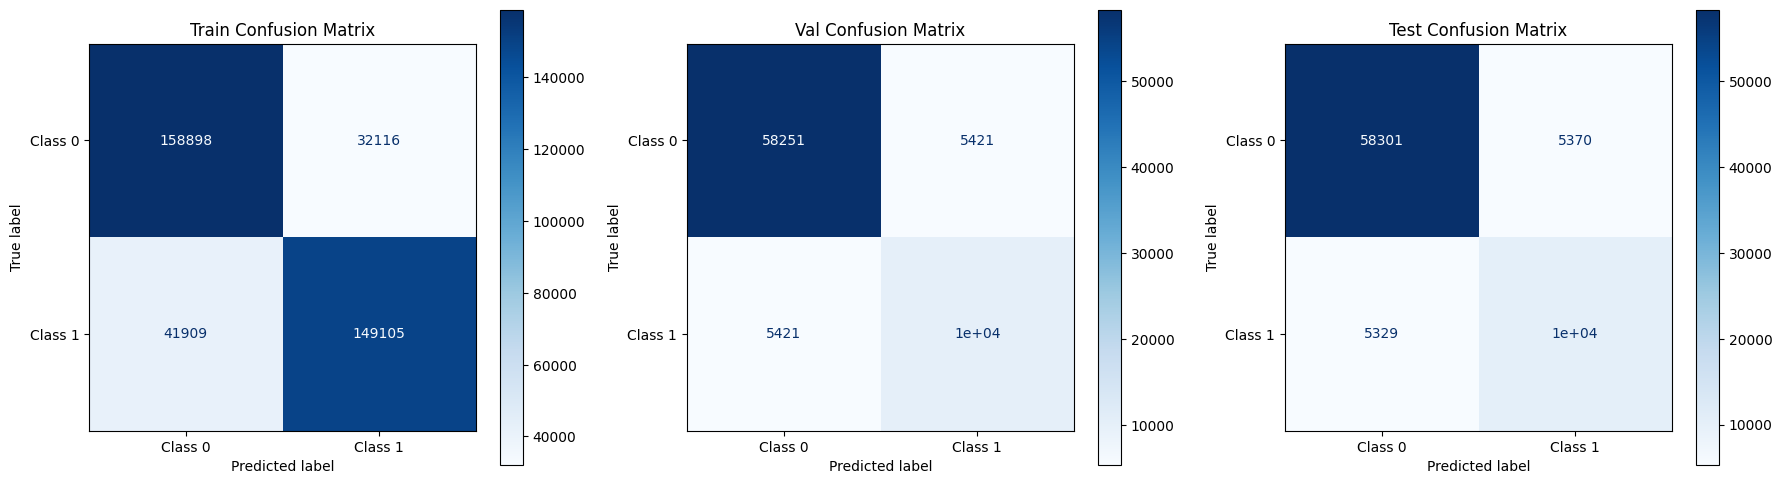

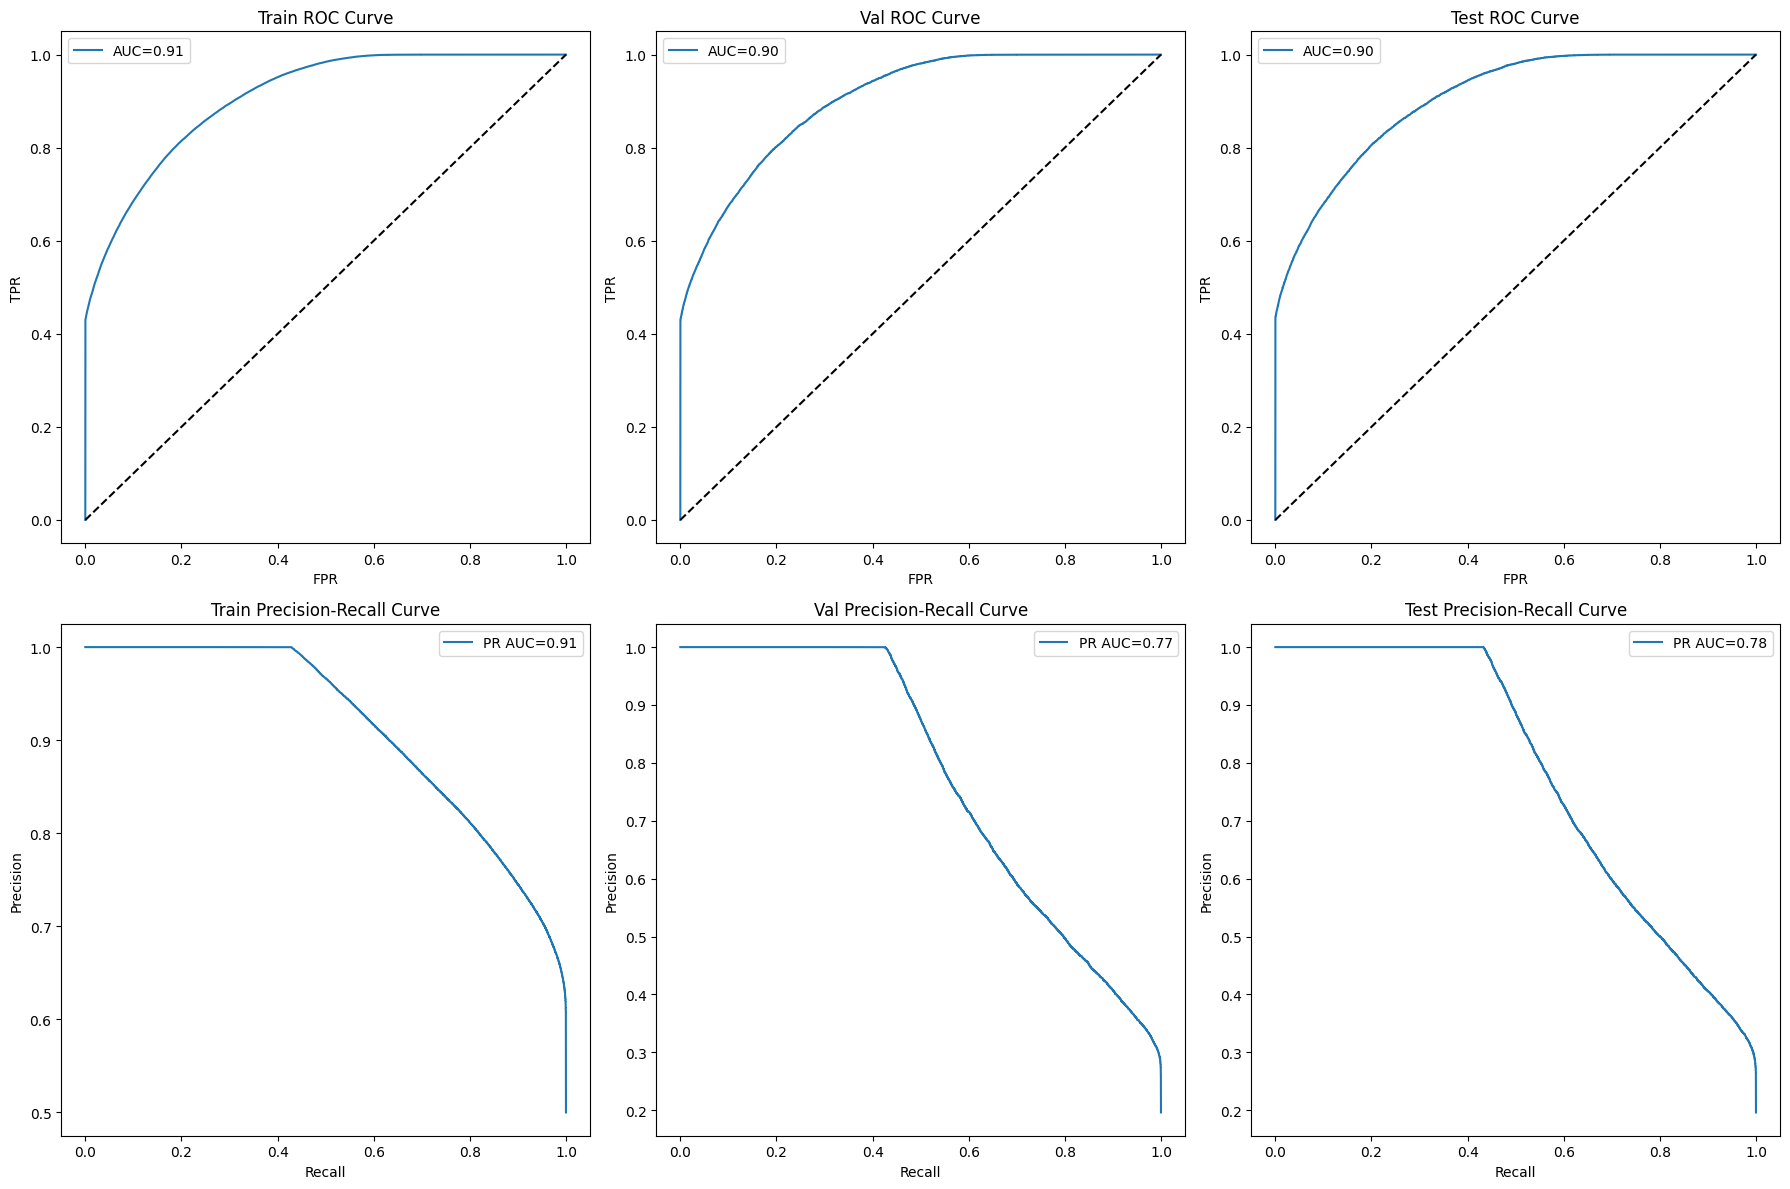

c:\Users\sreem\.conda\envs\ml_env\lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
2 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\sreem\.conda\envs\ml_env\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\sreem\.conda\envs\ml_env\lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\sreem\.conda\envs\ml_env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1301, in fit
    raise ValueError(
ValueErr

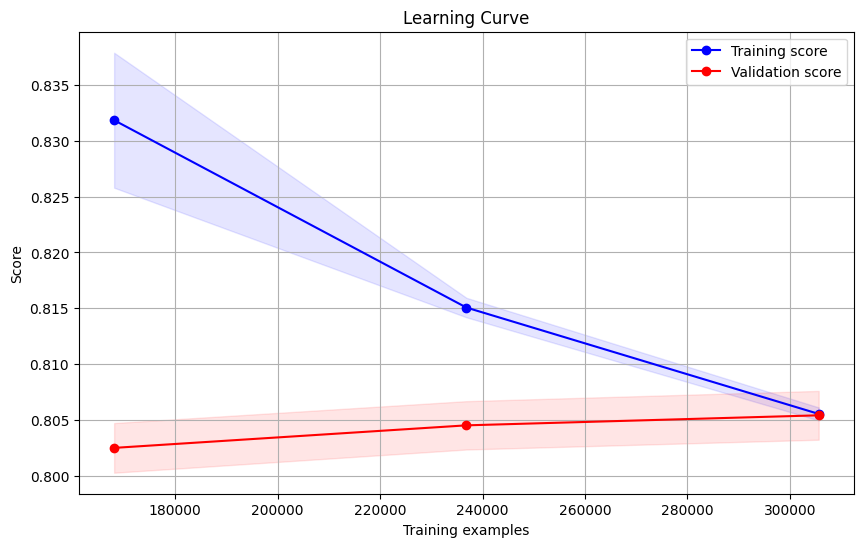

<Figure size 1200x800 with 0 Axes>

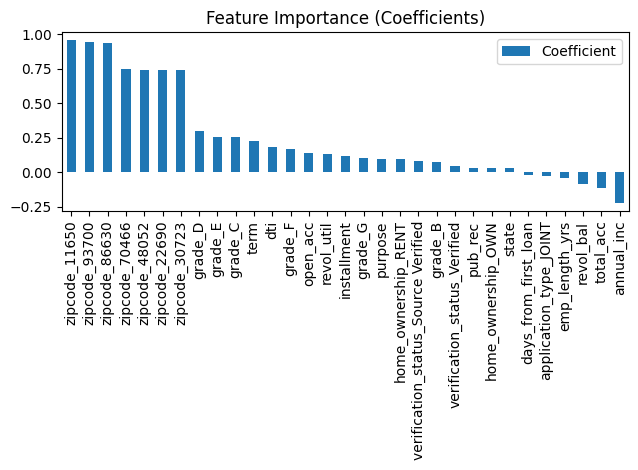


Model Intercept: -0.7093


2025/04/27 01:03:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



 MLFLOW Logging Completed.


In [162]:
feature_names = column_names

mlflow_logging_and_metric_printing(
    model=model,
    run_name="Balanced_Regularized_logistic_regression_before_thresholding",
    bal_type="Balanced_Smote",
    X_train=X_smote, y_train=y_smote, y_pred_train=y_pred_smote,
    X_val=X_val, y_val=y_val, y_pred_val=y_pred_val,
    X_test=X_test, y_test=y_test, y_pred_test=y_pred_test,
    hyper_tuning_score=0,
    feature_names=feature_names,
    best_lambda=best_lambda
)

### After Thresholding

Best Threshold where Precision ≈ Recall: 0.5911


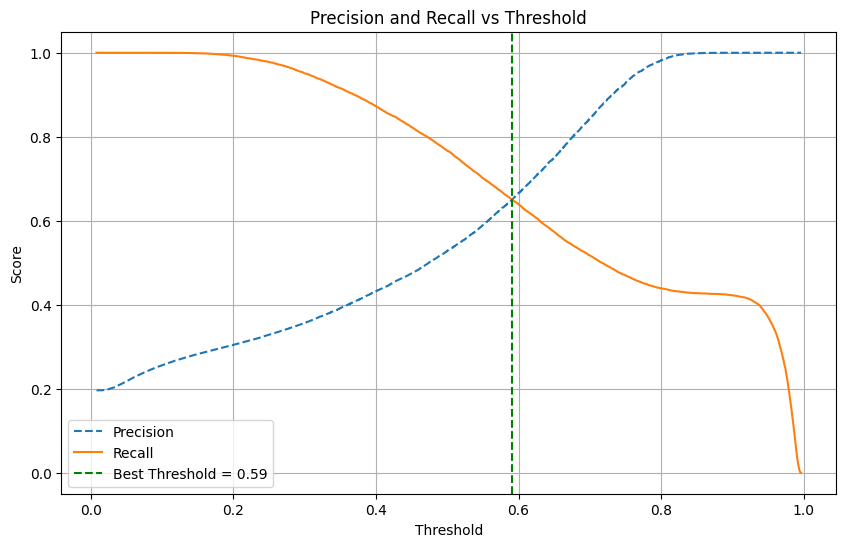

In [163]:
# 2. Predict probabilities
y_pred_proba_smote = model.predict_proba(X_smote)[:, 1]
y_pred_proba_val = model.predict_proba(X_val)[:, 1]
y_pred_proba_test = model.predict_proba(X_test)[:, 1]
# 3. Find Best Threshold
best_threshold = find_best_threshold(y_val, y_pred_proba_val)

In [164]:
# After threshold tuning outside
y_pred_smote = (y_pred_proba_smote >= best_threshold).astype(int)
y_pred_val = (y_pred_proba_val >= best_threshold).astype(int)
y_pred_test = (y_pred_proba_test >= best_threshold).astype(int)


Train Metrics:
  Accuracy_train: 0.7881
  Precision_train: 0.8848
  Recall_train: 0.6625
  F1_score_train: 0.7577
  F2_score_train: 0.6975
  Roc_auc_train: 0.9079
  Pr_auc_train: 0.9139

Train Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.91      0.81    191014
           1       0.88      0.66      0.76    191014

    accuracy                           0.79    382028
   macro avg       0.81      0.79      0.78    382028
weighted avg       0.81      0.79      0.78    382028


Val Metrics:
  Accuracy_val: 0.8628
  Precision_val: 0.6503
  Recall_val: 0.6503
  F1_score_val: 0.6503
  F2_score_val: 0.6503
  Roc_auc_val: 0.9034
  Pr_auc_val: 0.7747

Val Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91     63672
           1       0.65      0.65      0.65     15534

    accuracy                           0.86     79206
   macro avg       0.78      0.78      

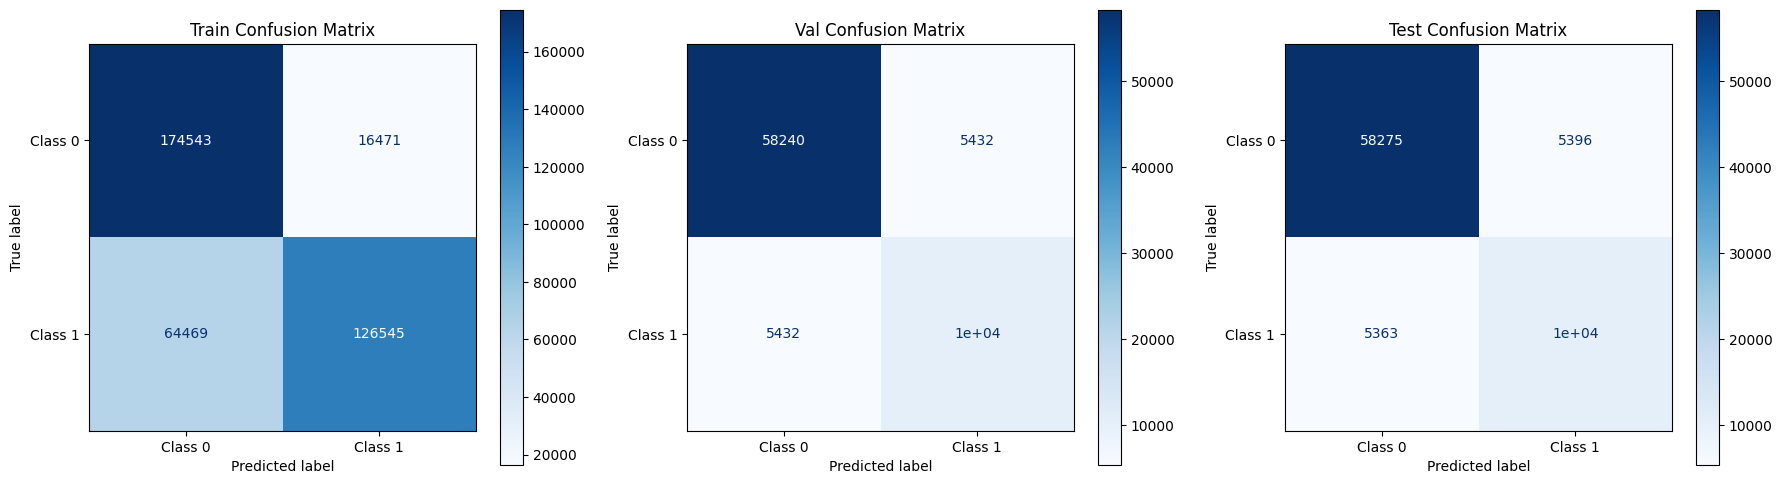

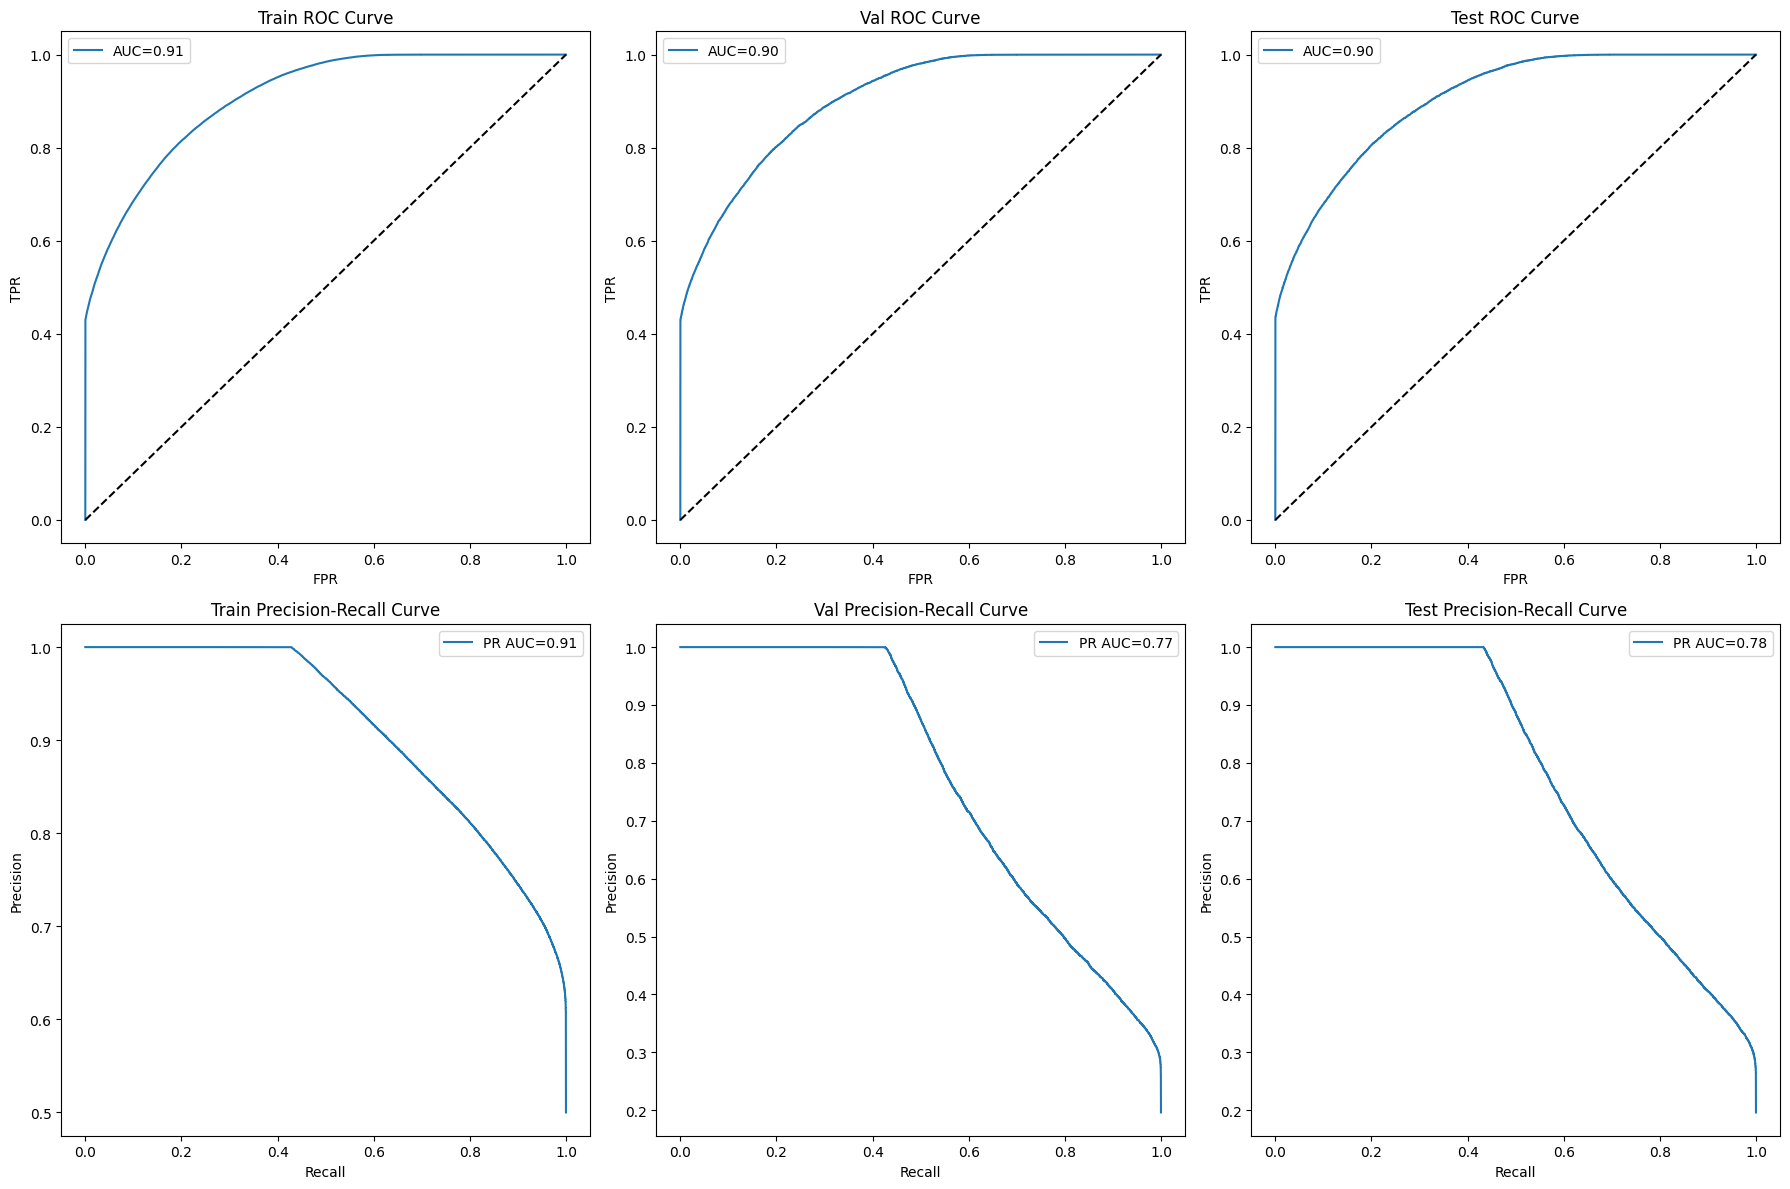

c:\Users\sreem\.conda\envs\ml_env\lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
2 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\sreem\.conda\envs\ml_env\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\sreem\.conda\envs\ml_env\lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\sreem\.conda\envs\ml_env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1301, in fit
    raise ValueError(
ValueErr

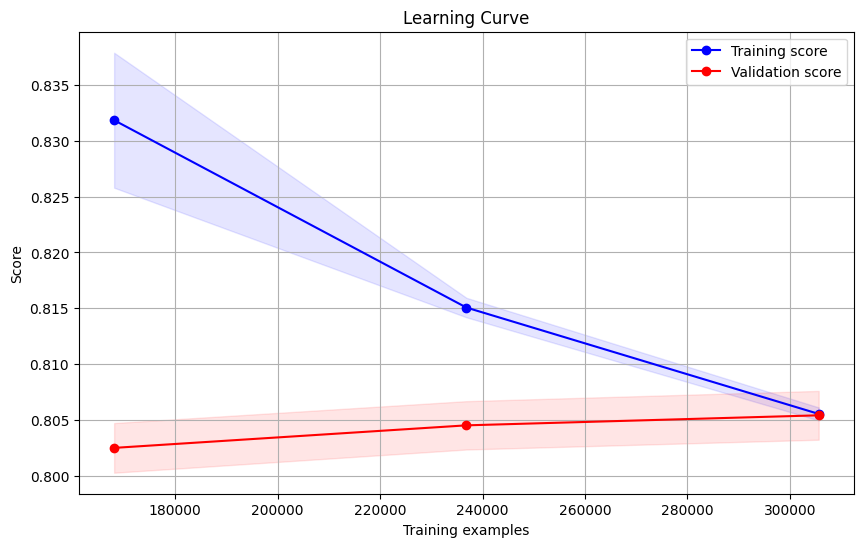

<Figure size 1200x800 with 0 Axes>

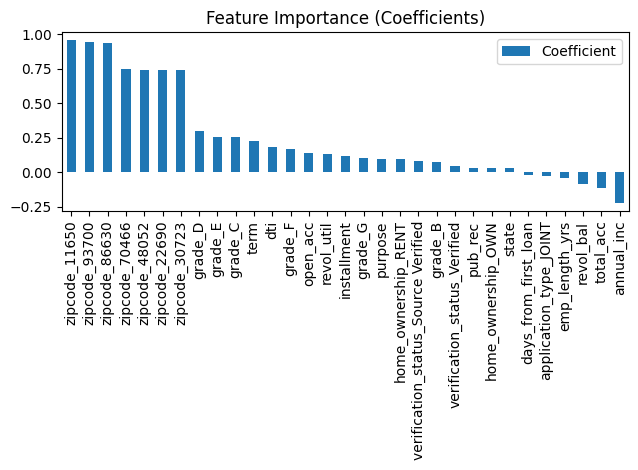


Model Intercept: -0.7093


2025/04/27 01:03:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



 MLFLOW Logging Completed.


In [165]:
feature_names = column_names

mlflow_logging_and_metric_printing(
    model=model,
    run_name="Balanced_Regularized_logistic_regression_after_thresholding",
    bal_type="Balanced_Smote",
    X_train=X_smote, y_train=y_smote, y_pred_train=y_pred_smote,
    X_val=X_val, y_val=y_val, y_pred_val=y_pred_val,
    X_test=X_test, y_test=y_test, y_pred_test=y_pred_test,
    hyper_tuning_score=0,
    feature_names=feature_names,
    best_threshold=best_threshold,
    best_lambda=best_lambda
)

Observations:
- 

# Trade-off questions:

### How can we make sure that our model can detect real defaulters and there are less false positives? This is important as we can lose out on an opportunity to finance more individuals and earn interest on it.

> Real Defaulters means True positives. So to give more importance to TP and Reduce False Positives. It is indicating that to improve the precision score. That means more weightage should be given for Precision score

> f beta score with Beta less than 1 should be selected. Beta can be taken as hyper parameter to find best Beta score. But On decrease of Beta, Recall score will decrease. We can take Specificity as metric, Where TN increases and FP decreases 

> If False Negatives increases, We lose out an oppurtunity to finance more individuals. SO to minimise the FN, We have use Recall or sensitivity or f Beta score with Beta greater than 1 or False Negative Rate

### Since NPA (non-performing asset) is a real problem in this industry, it’s important we play safe and shouldn’t disburse loans to anyone.

> To play safe, False positive should be minimised. So we have to use F Beta score with Beta less than 1 or Specificity or Recall score as hyper parameter tuning metric

# Actionable Insights and Recommendations

## 